# Design CTP-14 human genome DNA-MERFISH library 

by Pu Zheng

2022.10.14


# Table of contents


> 0. [Minimum required packages and settings](#0)
>>
>> 0.1: [import required packages](#0.1)
>
> 1. [Extract region sequences](#1)

<a id='0'></a>
# 0 Minimum required packages and settings

<a id='0.1'></a>
## 0.1 load required packages

In [95]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

11860


<a id='1'></a>
# 1 Extract region sequences

In [96]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain


In [97]:
resolution = 0
flanking = 10000
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'human_genome_library')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports


<a id='1.1'></a>
## 1.1 select regions

In [29]:
# prepare sequence reader
reload(ia.library_tools.sequences)
seq_rd = ia.library_tools.sequences.sequence_reader(genome_folder)
seq_rd.load_ref_sequences() # load genomic sequences

-- load sequence: 1, size=248956422
-- load sequence: 10, size=133797422
-- load sequence: 11, size=135086622
-- load sequence: 12, size=133275309
-- load sequence: 13, size=114364328
-- load sequence: 14, size=107043718
-- load sequence: 15, size=101991189
-- load sequence: 16, size=90338345
-- load sequence: 17, size=83257441
-- load sequence: 18, size=80373285
-- load sequence: 19, size=58617616
-- load sequence: 2, size=242193529
-- load sequence: 20, size=64444167
-- load sequence: 21, size=46709983
-- load sequence: 22, size=50818468
-- load sequence: 3, size=198295559
-- load sequence: 4, size=190214555
-- load sequence: 5, size=181538259
-- load sequence: 6, size=170805979
-- load sequence: 7, size=159345973
-- load sequence: 8, size=145138636
-- load sequence: 9, size=138394717
-- load sequence: MT, size=16569
-- load sequence: X, size=156040895
-- load sequence: Y, size=57227415
-- load sequence: KI270728.1, size=1872759
-- load sequence: KI270727.1, size=448248
-- load seque

In [31]:
# calculate total length
min_chr_len = 2000000 # ONLY taking care of chromosomes longer than 1Mb
chr_len_dict = {_name:len(_record) for _name, _record in seq_rd.ref_seq_dict.items() if len(_record) > min_chr_len}
total_len = sum(list(chr_len_dict.values()))
print(total_len)

3088269832


## select resolution for each chromosome

In [45]:
overwrite = False
region_num_filename = os.path.join(library_folder, 'chr_2_design_region_num.pkl')
resolution_filename = os.path.join(library_folder, 'chr_2_design_resolution.pkl')

# if both files exists, directly load
if os.path.exists(region_num_filename) and os.path.exists(resolution_filename) and not overwrite:
    print(f"Loading from file: {region_num_filename}")
    chr_2_region_num = pickle.load(open(region_num_filename, 'rb'))
    print(f"Loading from file: {resolution_filename}")
    chr_2_resolution = pickle.load(open(resolution_filename, 'rb'))
else:
    # Selecte regions in an adaptive manner to gaurentee 
    allowed_resolutions = (np.arange(25,0,-5) * 1e5).astype(np.int32)
    min_chr_region_num = 40
    chr_2_region_num = {}
    chr_2_resolution = {}
    for _name, _len in sorted(chr_len_dict.items(), key=lambda v:v[1]): 
        # iterative
        for _resolution in allowed_resolutions:
            # select the shortest chromosome first
            _curr_num = np.floor(_len/_resolution).astype(np.int32)
            if _curr_num >= min_chr_region_num:
                chr_2_region_num[_name] = _curr_num
                chr_2_resolution[_name] = _resolution
                print(_name, _resolution, _curr_num)
                min_chr_region_num = max(_curr_num * 0.8, min_chr_region_num)
                break    
    print(np.sum(list(chr_2_region_num.values())))
    # save
    print(f"Saving to file: {region_num_filename}")
    pickle.dump(chr_2_region_num, open(region_num_filename, 'wb'))
    print(f"Saving to file: {resolution_filename}")
    pickle.dump(chr_2_resolution, open(resolution_filename, 'wb'))

Loading from file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\chr_2_design_region_num.pkl
Loading from file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\chr_2_design_resolution.pkl


## For each chromosome, calculate region center:

In [46]:
from ImageAnalysis3.structure_tools.distance import sort_chr
region_size = 30000 # extract 30kb around the targets

In [47]:
region_dict_savefile = os.path.join(sequence_folder, 'region_dicts.pkl')
if os.path.exists(region_dict_savefile) and not overwrite:
    print(f"Loading from file: {region_dict_savefile}")
    region_dicts = pickle.load(open(region_dict_savefile, 'rb'))
else:
    region_seqs = []
    region_dicts = []
    region_id = 0
    for _chr in sorted(chr_2_region_num.keys(), key=lambda _v:sort_chr(_v)):
        print(_chr)
        _region_num = chr_2_region_num[_chr]
        _resolution = chr_2_resolution[_chr]
        # get region center
        _reg_centers = (np.arange(0.5,_region_num+0.5, 1) * _resolution ).astype(np.int32)
        _reg_starts = _reg_centers - int(region_size/2) + 1
        _reg_ends = _reg_centers + int(region_size/2)
        _seqs = [seq_rd.ref_seq_dict[_chr][_s:_e] for _s,_e in zip(_reg_starts, _reg_ends)]
        region_seqs.extend(_seqs)

        for _s,_e in zip(_reg_starts, _reg_ends):
            _reg_dict = {
                'Chr':_chr,
                'Start':_s,
                'End':_e,
                'Region':f"{_chr}:{_s}-{_e}",
                'Strand':'+',
                'Gene': region_id,
            }
            region_dicts.append(_reg_dict)
            region_id += 1
    # save
    print(f"Saving to file: {region_dict_savefile}")
    pickle.dump(region_dicts, open(region_dict_savefile, 'wb'))

Loading from file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\region_dicts.pkl


In [48]:
seqs = seq_rd.find_sequence_for_region(region_dicts)

-- searching among 24 references
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a match found in record: 1.
-- a m

In [49]:
seq_rd.save_sequences(save_folder=sequence_folder)

-- saving sequences into folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\0_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\2_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\3_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\4_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\5_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Librarie

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\87_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\88_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\89_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\90_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\91_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\92_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\93_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Lib

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\181_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\182_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\183_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\184_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\185_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\186_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\187_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\273_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\274_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\275_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\276_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\277_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\278_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\279_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\363_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\364_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\365_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\366_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\367_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\368_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\369_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\455_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\456_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\457_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\458_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\459_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\460_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\461_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\518_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\519_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\520_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\521_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\522_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\523_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\524_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\605_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\606_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\607_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\608_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\609_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\610_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\611_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\684_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\685_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\686_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\687_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\688_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\689_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\690_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\766_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\767_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\768_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\769_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\770_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\771_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\772_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\850_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\851_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\852_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\853_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\854_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\855_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\856_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\958_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\959_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\960_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\961_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\962_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\963_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\964_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chroma

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1021_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1022_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1023_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1024_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1025_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1026_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1027_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1083_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1084_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1085_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1086_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1087_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1088_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1089_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1146_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1147_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1148_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1149_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1150_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1151_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1152_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1209_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1210_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1211_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1212_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1213_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1214_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1215_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1304_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1305_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1306_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1307_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1308_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1309_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1310_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1397_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1398_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1399_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1400_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1401_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1402_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1403_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1497_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1498_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1499_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1500_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1501_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1502_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1503_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2

<a id='2'></a>
# 2. Design probe targeting sequences by probe_designer

run probe_designer, remeber to clear the memory usage because each table should take ~32GB

<a id='2.1'></a>
## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires hg38 genome

In [50]:
overwrite_table = False

### construct map for whole genome

In [51]:
from ImageAnalysis3 import library_tools

In [52]:
reload(library_tools.design)
 
genome_table_file = os.path.join(reference_folder, 'hg38_genome_17w.npy')

if not os.path.exists(genome_table_file) or overwrite_table:
    # genome
    _genome_filenames = [os.path.join(genome_folder, _fl) 
         for _fl in os.listdir(genome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_genome_filenames))

    ct = library_tools.design.countTable(word=17,save_file=genome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_genome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()

    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {genome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\hg38_genome_17w.npy already exist, skip.


### construct map for transcriptome

In [53]:
from tqdm import tqdm
# transcriptome
transcriptome_folder = os.path.join(reference_folder, 'Transcriptome')

transcriptome_table_file = os.path.join(reference_folder, 'hg38_transcriptome_17w.npy')

if not os.path.exists(transcriptome_table_file) or overwrite_table:
    # transcriptome
    _transcriptome_filenames = [os.path.join(transcriptome_folder, _fl) 
         for _fl in os.listdir(transcriptome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_transcriptome_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=transcriptome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_transcriptome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {transcriptome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\hg38_transcriptome_17w.npy already exist, skip.


### construct map for repeats from RepBase

In [54]:
from tqdm import tqdm
# repeat
repeat_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\Repbase'

repeat_table_file = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

if not os.path.exists(repeat_table_file) or overwrite_table:
    # repeat
    _repeat_filenames = [os.path.join(repeat_folder, _fl) 
         for _fl in os.listdir(repeat_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_repeat_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=repeat_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_repeat_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {repeat_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\Repbase_v2603_repeat_17w.npy already exist, skip.


<a id='2.2'></a>
## 2.2 Design probes

In [55]:
from ImageAnalysis3 import library_tools
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(reference_folder, 'hg38_genome_17w.npy')
transcriptome_index = os.path.join(reference_folder, 'hg38_transcriptome_17w.npy') 
repeat_index = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')
#ref_merfish_index = os.path.join(reference_folder, 'M1_meng_MERFISH_17w.npy') # merfish designed by Meng
# get input files 
input_files = glob.glob(os.path.join(sequence_folder, '*.fasta'))

print(f"{len(input_files)} regions loaded to design probes.")

if not os.path.exists(report_folder):
    os.makedirs(report_folder)
    
# filename to save probe reports
probe_savefile = os.path.join(report_folder, f'merged_probes.pbr')
print(probe_savefile)

1579 regions loaded to design probes.
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr


### create pb_designer class

In [57]:
reload(library_tools)
reload(library_tools.design)

pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':True, # design two strands
                  'two_stranded':True},
    map_dic={'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True},
             #'ref_merfish':{'file':ref_merfish_index,'rev_com':False,'two_stranded':True},
             },
        save_file=probe_savefile,
    params_dic={'word_size':17,'pb_len':42,'buffer_len':2,'max_count':2**16-1,
                'check_on_go': False, # whether automatically check probes
                'auto': False, # whether automatically convert reference maps
               },
    check_dic={('genome','self_sequences'): 25,
               'rep_genome': 0,
               'transcriptome': 25, # 14
               #'ref_merfish': 14,
               'gc':[0.25,0.75],'tm': 37+0.62*50+5,
               }
    )
print(pb_designer)
pb_designer.load_from_file(load_probes_only=True)


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_complement (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 1579
    - save_file location: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr

- Fail to load from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr, file doesn't exist.


False

### calculate probe reports

In [58]:
%%time
pb_designer.computeOTmaps() # load the tables 
pb_designer.compute_pb_report() # design candidate probes

-- setting attribute: map_genome
--- finish map_genome in 117.838s.
-- setting attribute: map_transcriptome
--- finish map_transcriptome in 121.144s.
-- setting attribute: map_rep_genome
--- finish map_rep_genome in 111.222s.
Time(s): 350.2070834636688
- Designing targeting sequence for 1579 regions
-- designing region: 1:1235001-1265000_strand_+_gene_0 -- region: 0, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\0_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.308s.
- Designed 59918 candidate probes in 16.210s.
-- designing region: 1:3735001-3765000_strand_+_gene_1 -- region: 1, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.343s.
- Designed 59918 candidate probes in 23.067s.

--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.444s.
-- designing region: 1:58735001-58765000_strand_+_gene_23 -- region: 23, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\23_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.575s.
-- designing region: 1:61235001-61265000_strand_+_gene_24 -- region: 24, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\24_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.401s.
-- designing region: 1:63735001-63765000_strand_+_gene_25 -- region: 25, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\25_reg_0.fasta
-

- Designed 59918 candidate probes in 15.656s.
-- designing region: 1:116235001-116265000_strand_+_gene_46 -- region: 46, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\46_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.691s.
-- designing region: 1:118735001-118765000_strand_+_gene_47 -- region: 47, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\47_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.892s.
-- designing region: 1:121235001-121265000_strand_+_gene_48 -- region: 48, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\48_reg_0.fasta
-- setting attribute: map_self_seque

--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.318s.
-- designing region: 1:176235001-176265000_strand_+_gene_70 -- region: 70, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\70_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.563s.
-- designing region: 1:178735001-178765000_strand_+_gene_71 -- region: 71, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\71_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.554s.
-- designing region: 1:181235001-181265000_strand_+_gene_72 -- region: 72, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\72_reg_0.f

--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.578s.
-- designing region: 1:233735001-233765000_strand_+_gene_93 -- region: 93, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\93_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.612s.
-- designing region: 1:236235001-236265000_strand_+_gene_94 -- region: 94, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\94_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.563s.
-- designing region: 1:238735001-238765000_strand_+_gene_95 -- region: 95, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\95_reg_0.f

--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.440s.
-- designing region: 2:43735001-43765000_strand_+_gene_116 -- region: 116, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\116_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.455s.
-- designing region: 2:46235001-46265000_strand_+_gene_117 -- region: 117, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\117_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.493s.
-- designing region: 2:48735001-48765000_strand_+_gene_118 -- region: 118, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\118_reg_

--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.558s.
-- designing region: 2:101235001-101265000_strand_+_gene_139 -- region: 139, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\139_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 25.058s.
-- designing region: 2:103735001-103765000_strand_+_gene_140 -- region: 140, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\140_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.551s.
-- designing region: 2:106235001-106265000_strand_+_gene_141 -- region: 141, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\14

--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.531s.
-- designing region: 2:158735001-158765000_strand_+_gene_162 -- region: 162, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\162_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 15.563s.
-- designing region: 2:161235001-161265000_strand_+_gene_163 -- region: 163, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\163_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.503s.
-- designing region: 2:163735001-163765000_strand_+_gene_164 -- region: 164, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\16

--- finish map_self_sequences in 0.301s.
- Designed 59918 candidate probes in 15.456s.
-- designing region: 2:216235001-216265000_strand_+_gene_185 -- region: 185, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\185_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.542s.
-- designing region: 2:218735001-218765000_strand_+_gene_186 -- region: 186, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\186_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.507s.
-- designing region: 2:221235001-221265000_strand_+_gene_187 -- region: 187, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\18

--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.554s.
-- designing region: 3:33735001-33765000_strand_+_gene_208 -- region: 208, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\208_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.509s.
-- designing region: 3:36235001-36265000_strand_+_gene_209 -- region: 209, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\209_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.559s.
-- designing region: 3:38735001-38765000_strand_+_gene_210 -- region: 210, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\210_reg_

--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.578s.
-- designing region: 3:91235001-91265000_strand_+_gene_231 -- region: 231, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\231_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.236s.
- Designed 41860 candidate probes in 11.001s.
-- designing region: 3:93735001-93765000_strand_+_gene_232 -- region: 232, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\232_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.481s.
-- designing region: 3:96235001-96265000_strand_+_gene_233 -- region: 233, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\233_reg_

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.646s.
-- designing region: 3:148735001-148765000_strand_+_gene_254 -- region: 254, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\254_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.559s.
-- designing region: 3:151235001-151265000_strand_+_gene_255 -- region: 255, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\255_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 31.099s.
-- designing region: 3:153735001-153765000_strand_+_gene_256 -- region: 256, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\25

--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.686s.
-- designing region: 4:8735001-8765000_strand_+_gene_277 -- region: 277, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\277_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.580s.
-- designing region: 4:11235001-11265000_strand_+_gene_278 -- region: 278, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\278_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.828s.
-- designing region: 4:13735001-13765000_strand_+_gene_279 -- region: 279, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\279_reg_0.

--- finish map_self_sequences in 0.300s.
- Designed 59918 candidate probes in 15.596s.
-- designing region: 4:66235001-66265000_strand_+_gene_300 -- region: 300, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\300_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.594s.
-- designing region: 4:68735001-68765000_strand_+_gene_301 -- region: 301, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\301_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.593s.
-- designing region: 4:71235001-71265000_strand_+_gene_302 -- region: 302, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\302_reg_

--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.596s.
-- designing region: 4:123735001-123765000_strand_+_gene_323 -- region: 323, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\323_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.582s.
-- designing region: 4:126235001-126265000_strand_+_gene_324 -- region: 324, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\324_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.529s.
-- designing region: 4:128735001-128765000_strand_+_gene_325 -- region: 325, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\32

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.595s.
-- designing region: 4:181235001-181265000_strand_+_gene_346 -- region: 346, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\346_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.591s.
-- designing region: 4:183735001-183765000_strand_+_gene_347 -- region: 347, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\347_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.671s.
-- designing region: 4:186235001-186265000_strand_+_gene_348 -- region: 348, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\34

--- finish map_self_sequences in 0.259s.
- Designed 59918 candidate probes in 15.511s.
-- designing region: 5:48735001-48765000_strand_+_gene_369 -- region: 369, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\369_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.233s.
- Designed 59918 candidate probes in 15.364s.
-- designing region: 5:51235001-51265000_strand_+_gene_370 -- region: 370, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\370_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.486s.
-- designing region: 5:53735001-53765000_strand_+_gene_371 -- region: 371, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\371_reg_

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.510s.
-- designing region: 5:106235001-106265000_strand_+_gene_392 -- region: 392, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\392_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.285s.
- Designed 59918 candidate probes in 15.510s.
-- designing region: 5:108735001-108765000_strand_+_gene_393 -- region: 393, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\393_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 18.066s.
-- designing region: 5:111235001-111265000_strand_+_gene_394 -- region: 394, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\39

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.552s.
-- designing region: 5:163735001-163765000_strand_+_gene_415 -- region: 415, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\415_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.598s.
-- designing region: 5:166235001-166265000_strand_+_gene_416 -- region: 416, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\416_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.298s.
- Designed 59918 candidate probes in 15.593s.
-- designing region: 5:168735001-168765000_strand_+_gene_417 -- region: 417, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\41

--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.623s.
-- designing region: 6:41235001-41265000_strand_+_gene_438 -- region: 438, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\438_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.562s.
-- designing region: 6:43735001-43765000_strand_+_gene_439 -- region: 439, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\439_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.552s.
-- designing region: 6:46235001-46265000_strand_+_gene_440 -- region: 440, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\440_reg_

--- finish map_self_sequences in 0.649s.
- Designed 59918 candidate probes in 19.907s.
-- designing region: 6:98735001-98765000_strand_+_gene_461 -- region: 461, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\461_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.553s.
-- designing region: 6:101235001-101265000_strand_+_gene_462 -- region: 462, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\462_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.296s.
- Designed 59918 candidate probes in 15.630s.
-- designing region: 6:103735001-103765000_strand_+_gene_463 -- region: 463, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\463_

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.689s.
-- designing region: 6:156235001-156265000_strand_+_gene_484 -- region: 484, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\484_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.621s.
-- designing region: 6:158735001-158765000_strand_+_gene_485 -- region: 485, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\485_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.632s.
-- designing region: 6:161235001-161265000_strand_+_gene_486 -- region: 486, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\48

--- finish map_self_sequences in 0.304s.
- Designed 59918 candidate probes in 15.604s.
-- designing region: 7:43735001-43765000_strand_+_gene_507 -- region: 507, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\507_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.493s.
-- designing region: 7:46235001-46265000_strand_+_gene_508 -- region: 508, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\508_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.489s.
-- designing region: 7:48735001-48765000_strand_+_gene_509 -- region: 509, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\509_reg_

--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.651s.
-- designing region: 7:101235001-101265000_strand_+_gene_530 -- region: 530, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\530_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 7:103735001-103765000_strand_+_gene_531 -- region: 531, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\531_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.653s.
-- designing region: 7:106235001-106265000_strand_+_gene_532 -- region: 532, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\53

--- finish map_self_sequences in 0.294s.
- Designed 59918 candidate probes in 15.675s.
-- designing region: 8:1235001-1265000_strand_+_gene_553 -- region: 553, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\553_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.251s.
- Designed 59918 candidate probes in 15.478s.
-- designing region: 8:3735001-3765000_strand_+_gene_554 -- region: 554, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\554_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.537s.
-- designing region: 8:6235001-6265000_strand_+_gene_555 -- region: 555, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\555_reg_0.fast

--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.593s.
-- designing region: 8:58735001-58765000_strand_+_gene_576 -- region: 576, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\576_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.296s.
- Designed 59918 candidate probes in 15.637s.
-- designing region: 8:61235001-61265000_strand_+_gene_577 -- region: 577, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\577_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.574s.
-- designing region: 8:63735001-63765000_strand_+_gene_578 -- region: 578, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\578_reg_

--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.585s.
-- designing region: 8:116235001-116265000_strand_+_gene_599 -- region: 599, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\599_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.688s.
-- designing region: 8:118735001-118765000_strand_+_gene_600 -- region: 600, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\600_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.285s.
- Designed 59918 candidate probes in 15.631s.
-- designing region: 8:121235001-121265000_strand_+_gene_601 -- region: 601, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\60

--- finish map_self_sequences in 0.272s.
- Designed 59918 candidate probes in 15.531s.
-- designing region: 9:22985001-23015000_strand_+_gene_622 -- region: 622, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\622_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.302s.
- Designed 59918 candidate probes in 15.580s.
-- designing region: 9:24985001-25015000_strand_+_gene_623 -- region: 623, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\623_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.266s.
- Designed 59918 candidate probes in 15.510s.
-- designing region: 9:26985001-27015000_strand_+_gene_624 -- region: 624, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\624_reg_

--- finish map_self_sequences in 0.298s.
- Designed 59918 candidate probes in 15.545s.
-- designing region: 9:68985001-69015000_strand_+_gene_645 -- region: 645, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\645_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.264s.
- Designed 59918 candidate probes in 15.567s.
-- designing region: 9:70985001-71015000_strand_+_gene_646 -- region: 646, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\646_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.547s.
-- designing region: 9:72985001-73015000_strand_+_gene_647 -- region: 647, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\647_reg_

--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.618s.
-- designing region: 9:114985001-115015000_strand_+_gene_668 -- region: 668, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\668_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.570s.
-- designing region: 9:116985001-117015000_strand_+_gene_669 -- region: 669, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\669_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.643s.
-- designing region: 9:118985001-119015000_strand_+_gene_670 -- region: 670, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\67

--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.621s.
-- designing region: 10:22985001-23015000_strand_+_gene_691 -- region: 691, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\691_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.567s.
-- designing region: 10:24985001-25015000_strand_+_gene_692 -- region: 692, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\692_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.588s.
-- designing region: 10:26985001-27015000_strand_+_gene_693 -- region: 693, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\693_r

--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 15.644s.
-- designing region: 10:68985001-69015000_strand_+_gene_714 -- region: 714, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\714_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.643s.
-- designing region: 10:70985001-71015000_strand_+_gene_715 -- region: 715, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\715_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.727s.
-- designing region: 10:72985001-73015000_strand_+_gene_716 -- region: 716, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\716_r

--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.651s.
-- designing region: 10:114985001-115015000_strand_+_gene_737 -- region: 737, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\737_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.595s.
-- designing region: 10:116985001-117015000_strand_+_gene_738 -- region: 738, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\738_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.600s.
-- designing region: 10:118985001-119015000_strand_+_gene_739 -- region: 739, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences

--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 15.533s.
-- designing region: 11:28985001-29015000_strand_+_gene_760 -- region: 760, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\760_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.518s.
-- designing region: 11:30985001-31015000_strand_+_gene_761 -- region: 761, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\761_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.268s.
- Designed 59918 candidate probes in 15.505s.
-- designing region: 11:32985001-33015000_strand_+_gene_762 -- region: 762, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\762_r

--- finish map_self_sequences in 0.640s.
- Designed 59918 candidate probes in 16.006s.
-- designing region: 11:74985001-75015000_strand_+_gene_783 -- region: 783, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\783_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.635s.
-- designing region: 11:76985001-77015000_strand_+_gene_784 -- region: 784, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\784_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.297s.
- Designed 59918 candidate probes in 15.678s.
-- designing region: 11:78985001-79015000_strand_+_gene_785 -- region: 785, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\785_r

--- finish map_self_sequences in 0.270s.
- Designed 59918 candidate probes in 15.591s.
-- designing region: 11:120985001-121015000_strand_+_gene_806 -- region: 806, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\806_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.566s.
-- designing region: 11:122985001-123015000_strand_+_gene_807 -- region: 807, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\807_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.273s.
- Designed 59918 candidate probes in 15.518s.
-- designing region: 11:124985001-125015000_strand_+_gene_808 -- region: 808, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences

--- finish map_self_sequences in 0.270s.
- Designed 59918 candidate probes in 15.531s.
-- designing region: 12:32985001-33015000_strand_+_gene_829 -- region: 829, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\829_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.526s.
-- designing region: 12:34985001-35015000_strand_+_gene_830 -- region: 830, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\830_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.217s.
- Designed 59918 candidate probes in 15.718s.
-- designing region: 12:36985001-37015000_strand_+_gene_831 -- region: 831, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\831_r

--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.604s.
-- designing region: 12:78985001-79015000_strand_+_gene_852 -- region: 852, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\852_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.296s.
- Designed 59918 candidate probes in 15.573s.
-- designing region: 12:80985001-81015000_strand_+_gene_853 -- region: 853, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\853_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.586s.
-- designing region: 12:82985001-83015000_strand_+_gene_854 -- region: 854, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\854_r

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.601s.
-- designing region: 12:124985001-125015000_strand_+_gene_875 -- region: 875, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\875_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 15.531s.
-- designing region: 12:126985001-127015000_strand_+_gene_876 -- region: 876, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\876_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.294s.
- Designed 59918 candidate probes in 15.571s.
-- designing region: 12:128985001-129015000_strand_+_gene_877 -- region: 877, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences

--- finish map_self_sequences in 0.275s.
- Designed 59918 candidate probes in 15.440s.
-- designing region: 13:38985001-39015000_strand_+_gene_898 -- region: 898, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\898_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.298s.
- Designed 59918 candidate probes in 15.462s.
-- designing region: 13:40985001-41015000_strand_+_gene_899 -- region: 899, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\899_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.437s.
-- designing region: 13:42985001-43015000_strand_+_gene_900 -- region: 900, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\900_r

--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.545s.
-- designing region: 13:84985001-85015000_strand_+_gene_921 -- region: 921, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\921_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.518s.
-- designing region: 13:86985001-87015000_strand_+_gene_922 -- region: 922, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\922_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.643s.
-- designing region: 13:88985001-89015000_strand_+_gene_923 -- region: 923, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\923_r

--- finish map_self_sequences in 0.549s.
- Designed 0 candidate probes in 0.842s.
-- designing region: 14:12735001-12765000_strand_+_gene_944 -- region: 944, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\944_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.574s.
- Designed 0 candidate probes in 0.868s.
-- designing region: 14:14235001-14265000_strand_+_gene_945 -- region: 945, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\945_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.557s.
- Designed 0 candidate probes in 0.850s.
-- designing region: 14:15735001-15765000_strand_+_gene_946 -- region: 946, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\946_reg_0.fasta
-- s

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.417s.
-- designing region: 14:47235001-47265000_strand_+_gene_967 -- region: 967, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\967_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.412s.
-- designing region: 14:48735001-48765000_strand_+_gene_968 -- region: 968, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\968_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.461s.
-- designing region: 14:50235001-50265000_strand_+_gene_969 -- region: 969, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\969_r

--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.594s.
-- designing region: 14:81735001-81765000_strand_+_gene_990 -- region: 990, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\990_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.603s.
-- designing region: 14:83235001-83265000_strand_+_gene_991 -- region: 991, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\991_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.559s.
-- designing region: 14:84735001-84765000_strand_+_gene_992 -- region: 992, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\992_r

--- finish map_self_sequences in 0.560s.
- Designed 0 candidate probes in 0.854s.
-- designing region: 15:9735001-9765000_strand_+_gene_1013 -- region: 1013, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1013_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.553s.
- Designed 0 candidate probes in 0.846s.
-- designing region: 15:11235001-11265000_strand_+_gene_1014 -- region: 1014, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1014_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.559s.
- Designed 0 candidate probes in 0.853s.
-- designing region: 15:12735001-12765000_strand_+_gene_1015 -- region: 1015, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1015_reg_0.fas

--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.428s.
-- designing region: 15:44235001-44265000_strand_+_gene_1036 -- region: 1036, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1036_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.276s.
- Designed 59918 candidate probes in 15.444s.
-- designing region: 15:45735001-45765000_strand_+_gene_1037 -- region: 1037, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1037_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.285s.
- Designed 59918 candidate probes in 15.448s.
-- designing region: 15:47235001-47265000_strand_+_gene_1038 -- region: 1038, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 15:78735001-78765000_strand_+_gene_1059 -- region: 1059, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1059_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.631s.
-- designing region: 15:80235001-80265000_strand_+_gene_1060 -- region: 1060, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1060_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.620s.
-- designing region: 15:81735001-81765000_strand_+_gene_1061 -- region: 1061, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.286s.
- Designed 59918 candidate probes in 15.346s.
-- designing region: 16:12735001-12765000_strand_+_gene_1082 -- region: 1082, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1082_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.273s.
- Designed 59918 candidate probes in 15.394s.
-- designing region: 16:14235001-14265000_strand_+_gene_1083 -- region: 1083, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1083_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.407s.
-- designing region: 16:15735001-15765000_strand_+_gene_1084 -- region: 1084, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.564s.
- Designed 0 candidate probes in 0.859s.
-- designing region: 16:47235001-47265000_strand_+_gene_1105 -- region: 1105, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1105_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.620s.
- Designed 59918 candidate probes in 15.649s.
-- designing region: 16:48735001-48765000_strand_+_gene_1106 -- region: 1106, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1106_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.455s.
-- designing region: 16:50235001-50265000_strand_+_gene_1107 -- region: 1107, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\11

--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.587s.
-- designing region: 16:81735001-81765000_strand_+_gene_1128 -- region: 1128, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1128_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.652s.
-- designing region: 16:83235001-83265000_strand_+_gene_1129 -- region: 1129, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1129_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.284s.
- Designed 59918 candidate probes in 15.567s.
-- designing region: 16:84735001-84765000_strand_+_gene_1130 -- region: 1130, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.220s.
- Designed 59918 candidate probes in 15.215s.
-- designing region: 17:26235001-26265000_strand_+_gene_1151 -- region: 1151, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1151_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.223s.
- Designed 59918 candidate probes in 15.257s.
-- designing region: 17:27735001-27765000_strand_+_gene_1152 -- region: 1152, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1152_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.364s.
-- designing region: 17:29235001-29265000_strand_+_gene_1153 -- region: 1153, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.583s.
- Designed 59918 candidate probes in 21.880s.
-- designing region: 17:60735001-60765000_strand_+_gene_1174 -- region: 1174, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1174_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.522s.
-- designing region: 17:62235001-62265000_strand_+_gene_1175 -- region: 1175, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1175_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.643s.
-- designing region: 17:63735001-63765000_strand_+_gene_1176 -- region: 1176, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.727s.
-- designing region: 18:12735001-12765000_strand_+_gene_1197 -- region: 1197, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1197_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.272s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 18:14235001-14265000_strand_+_gene_1198 -- region: 1198, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1198_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 18:15735001-15765000_strand_+_gene_1199 -- region: 1199, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 15.459s.
-- designing region: 18:47235001-47265000_strand_+_gene_1220 -- region: 1220, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1220_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 15.451s.
-- designing region: 18:48735001-48765000_strand_+_gene_1221 -- region: 1221, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1221_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.489s.
-- designing region: 18:50235001-50265000_strand_+_gene_1222 -- region: 1222, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.639s.
-- designing region: 19:1485001-1515000_strand_+_gene_1243 -- region: 1243, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1243_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.613s.
-- designing region: 19:2485001-2515000_strand_+_gene_1244 -- region: 1244, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1244_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.631s.
-- designing region: 19:3485001-3515000_strand_+_gene_1245 -- region: 1245, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\124

--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.504s.
-- designing region: 19:24485001-24515000_strand_+_gene_1266 -- region: 1266, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1266_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.224s.
- Designed 31958 candidate probes in 8.605s.
-- designing region: 19:25485001-25515000_strand_+_gene_1267 -- region: 1267, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1267_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.221s.
- Designed 59918 candidate probes in 15.242s.
-- designing region: 19:26485001-26515000_strand_+_gene_1268 -- region: 1268, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequence

--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.450s.
-- designing region: 19:47485001-47515000_strand_+_gene_1289 -- region: 1289, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1289_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.539s.
-- designing region: 19:48485001-48515000_strand_+_gene_1290 -- region: 1290, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1290_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.534s.
-- designing region: 19:49485001-49515000_strand_+_gene_1291 -- region: 1291, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 15.600s.
-- designing region: 20:12485001-12515000_strand_+_gene_1312 -- region: 1312, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1312_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.630s.
-- designing region: 20:13485001-13515000_strand_+_gene_1313 -- region: 1313, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1313_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.290s.
- Designed 59918 candidate probes in 15.672s.
-- designing region: 20:14485001-14515000_strand_+_gene_1314 -- region: 1314, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.429s.
-- designing region: 20:35485001-35515000_strand_+_gene_1335 -- region: 1335, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1335_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.265s.
- Designed 59918 candidate probes in 15.481s.
-- designing region: 20:36485001-36515000_strand_+_gene_1336 -- region: 1336, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1336_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.281s.
- Designed 59918 candidate probes in 15.500s.
-- designing region: 20:37485001-37515000_strand_+_gene_1337 -- region: 1337, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.721s.
-- designing region: 20:58485001-58515000_strand_+_gene_1358 -- region: 1358, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1358_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.737s.
-- designing region: 20:59485001-59515000_strand_+_gene_1359 -- region: 1359, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1359_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.279s.
- Designed 59918 candidate probes in 15.686s.
-- designing region: 20:60485001-60515000_strand_+_gene_1360 -- region: 1360, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.620s.
-- designing region: 21:17485001-17515000_strand_+_gene_1381 -- region: 1381, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1381_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.679s.
-- designing region: 21:18485001-18515000_strand_+_gene_1382 -- region: 1382, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1382_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.292s.
- Designed 59918 candidate probes in 15.654s.
-- designing region: 21:19485001-19515000_strand_+_gene_1383 -- region: 1383, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.293s.
- Designed 59918 candidate probes in 15.506s.
-- designing region: 21:40485001-40515000_strand_+_gene_1404 -- region: 1404, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1404_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.479s.
-- designing region: 21:41485001-41515000_strand_+_gene_1405 -- region: 1405, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1405_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.269s.
- Designed 59918 candidate probes in 15.511s.
-- designing region: 21:42485001-42515000_strand_+_gene_1406 -- region: 1406, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.273s.
- Designed 59918 candidate probes in 15.476s.
-- designing region: 22:17485001-17515000_strand_+_gene_1427 -- region: 1427, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1427_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.277s.
- Designed 59918 candidate probes in 15.481s.
-- designing region: 22:18485001-18515000_strand_+_gene_1428 -- region: 1428, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1428_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.483s.
-- designing region: 22:19485001-19515000_strand_+_gene_1429 -- region: 1429, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.278s.
- Designed 59918 candidate probes in 15.674s.
-- designing region: 22:40485001-40515000_strand_+_gene_1450 -- region: 1450, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1450_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 16.330s.
-- designing region: 22:41485001-41515000_strand_+_gene_1451 -- region: 1451, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1451_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.274s.
- Designed 59918 candidate probes in 15.632s.
-- designing region: 22:42485001-42515000_strand_+_gene_1452 -- region: 1452, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequenc

--- finish map_self_sequences in 0.289s.
- Designed 59918 candidate probes in 15.497s.
-- designing region: X:33735001-33765000_strand_+_gene_1473 -- region: 1473, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1473_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.280s.
- Designed 59918 candidate probes in 15.499s.
-- designing region: X:36235001-36265000_strand_+_gene_1474 -- region: 1474, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1474_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.287s.
- Designed 59918 candidate probes in 15.509s.
-- designing region: X:38735001-38765000_strand_+_gene_1475 -- region: 1475, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\

--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.488s.
-- designing region: X:91235001-91265000_strand_+_gene_1496 -- region: 1496, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1496_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.291s.
- Designed 59918 candidate probes in 20.020s.
-- designing region: X:93735001-93765000_strand_+_gene_1497 -- region: 1497, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1497_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.622s.
- Designed 59918 candidate probes in 22.269s.
-- designing region: X:96235001-96265000_strand_+_gene_1498 -- region: 1498, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\

--- finish map_self_sequences in 0.288s.
- Designed 59918 candidate probes in 15.862s.
-- designing region: X:148735001-148765000_strand_+_gene_1519 -- region: 1519, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1519_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.243s.
- Designed 59918 candidate probes in 16.043s.
-- designing region: X:151235001-151265000_strand_+_gene_1520 -- region: 1520, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1520_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.294s.
- Designed 59918 candidate probes in 15.940s.
-- designing region: X:153735001-153765000_strand_+_gene_1521 -- region: 1521, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequ

--- finish map_self_sequences in 0.283s.
- Designed 59918 candidate probes in 15.506s.
-- designing region: Y:20485001-20515000_strand_+_gene_1542 -- region: 1542, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1542_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.282s.
- Designed 59918 candidate probes in 15.500s.
-- designing region: Y:21485001-21515000_strand_+_gene_1543 -- region: 1543, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1543_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.295s.
- Designed 59918 candidate probes in 15.535s.
-- designing region: Y:22485001-22515000_strand_+_gene_1544 -- region: 1544, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\

--- finish map_self_sequences in 0.559s.
- Designed 0 candidate probes in 0.854s.
-- designing region: Y:43485001-43515000_strand_+_gene_1565 -- region: 1565, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1565_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.551s.
- Designed 0 candidate probes in 0.846s.
-- designing region: Y:44485001-44515000_strand_+_gene_1566 -- region: 1566, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1566_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.558s.
- Designed 0 candidate probes in 0.851s.
-- designing region: Y:45485001-45515000_strand_+_gene_1567 -- region: 1567, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\sequences\1567_reg_0.fast

### check probes

In [59]:
pbs, pb_scores = pb_designer.check_probes()

-- check region:0 1:1235001-1265000_strand_+_gene_0, 57068 candidate probes
--- 19930 probes passed check_dic selection.
finish in 1.719s, 344 probes kept.
-- check region:1 1:3735001-3765000_strand_+_gene_1, 57548 candidate probes
--- 17833 probes passed check_dic selection.
finish in 1.605s, 319 probes kept.
-- check region:2 1:6235001-6265000_strand_+_gene_2, 58584 candidate probes
--- 24326 probes passed check_dic selection.
finish in 1.832s, 377 probes kept.
-- check region:3 1:8735001-8765000_strand_+_gene_3, 58690 candidate probes
--- 12490 probes passed check_dic selection.
finish in 1.391s, 242 probes kept.
-- check region:4 1:11235001-11265000_strand_+_gene_4, 55772 candidate probes
--- 15903 probes passed check_dic selection.
finish in 1.482s, 256 probes kept.
-- check region:5 1:13735001-13765000_strand_+_gene_5, 58958 candidate probes
--- 16480 probes passed check_dic selection.
finish in 1.511s, 303 probes kept.
-- check region:6 1:16235001-16265000_strand_+_gene_6, 57896

-- check region:52 1:131235001-131265000_strand_+_gene_52, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:53 1:133735001-133765000_strand_+_gene_53, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:54 1:136235001-136265000_strand_+_gene_54, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:55 1:138735001-138765000_strand_+_gene_55, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:56 1:141235001-141265000_strand_+_gene_56, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:57 1:143735001-143765000_strand_+_gene_57, 57134 candidate probes
--- 1466 probes passed check_dic selection.
finish in 0.973s, 60 probes kept.
-- check region:58 1:146235001-146265000_strand_+_gene_58, 57912 candidate probe

--- 8477 probes passed check_dic selection.
finish in 1.215s, 205 probes kept.
-- check region:104 2:13735001-13765000_strand_+_gene_104, 52880 candidate probes
--- 3896 probes passed check_dic selection.
finish in 0.969s, 119 probes kept.
-- check region:105 2:16235001-16265000_strand_+_gene_105, 59376 candidate probes
--- 23556 probes passed check_dic selection.
finish in 1.818s, 352 probes kept.
-- check region:106 2:18735001-18765000_strand_+_gene_106, 57758 candidate probes
--- 13112 probes passed check_dic selection.
finish in 1.377s, 244 probes kept.
-- check region:107 2:21235001-21265000_strand_+_gene_107, 58946 candidate probes
--- 19363 probes passed check_dic selection.
finish in 1.624s, 305 probes kept.
-- check region:108 2:23735001-23765000_strand_+_gene_108, 53196 candidate probes
--- 9170 probes passed check_dic selection.
finish in 1.173s, 213 probes kept.
-- check region:109 2:26235001-26265000_strand_+_gene_109, 57444 candidate probes
--- 10774 probes passed check_d

--- 16035 probes passed check_dic selection.
finish in 1.518s, 283 probes kept.
-- check region:155 2:141235001-141265000_strand_+_gene_155, 59734 candidate probes
--- 11963 probes passed check_dic selection.
finish in 1.351s, 252 probes kept.
-- check region:156 2:143735001-143765000_strand_+_gene_156, 59532 candidate probes
--- 17151 probes passed check_dic selection.
finish in 1.552s, 292 probes kept.
-- check region:157 2:146235001-146265000_strand_+_gene_157, 59104 candidate probes
--- 11906 probes passed check_dic selection.
finish in 1.345s, 255 probes kept.
-- check region:158 2:148735001-148765000_strand_+_gene_158, 59332 candidate probes
--- 10875 probes passed check_dic selection.
finish in 1.304s, 227 probes kept.
-- check region:159 2:151235001-151265000_strand_+_gene_159, 57610 candidate probes
--- 12441 probes passed check_dic selection.
finish in 1.362s, 231 probes kept.
-- check region:160 2:153735001-153765000_strand_+_gene_160, 59614 candidate probes
--- 5641 probes 

-- check region:205 3:26235001-26265000_strand_+_gene_205, 53482 candidate probes
--- 12872 probes passed check_dic selection.
finish in 1.297s, 241 probes kept.
-- check region:206 3:28735001-28765000_strand_+_gene_206, 59384 candidate probes
--- 14205 probes passed check_dic selection.
finish in 1.451s, 262 probes kept.
-- check region:207 3:31235001-31265000_strand_+_gene_207, 59732 candidate probes
--- 18090 probes passed check_dic selection.
finish in 1.596s, 324 probes kept.
-- check region:208 3:33735001-33765000_strand_+_gene_208, 56604 candidate probes
--- 8194 probes passed check_dic selection.
finish in 1.188s, 174 probes kept.
-- check region:209 3:36235001-36265000_strand_+_gene_209, 55888 candidate probes
--- 8315 probes passed check_dic selection.
finish in 1.174s, 180 probes kept.
-- check region:210 3:38735001-38765000_strand_+_gene_210, 59248 candidate probes
--- 23150 probes passed check_dic selection.
finish in 1.814s, 365 probes kept.
-- check region:211 3:41235001

--- 12065 probes passed check_dic selection.
finish in 1.245s, 225 probes kept.
-- check region:256 3:153735001-153765000_strand_+_gene_256, 58366 candidate probes
--- 11123 probes passed check_dic selection.
finish in 1.316s, 218 probes kept.
-- check region:257 3:156235001-156265000_strand_+_gene_257, 59370 candidate probes
--- 17780 probes passed check_dic selection.
finish in 1.580s, 288 probes kept.
-- check region:258 3:158735001-158765000_strand_+_gene_258, 57960 candidate probes
--- 17467 probes passed check_dic selection.
finish in 1.574s, 314 probes kept.
-- check region:259 3:161235001-161265000_strand_+_gene_259, 59342 candidate probes
--- 6225 probes passed check_dic selection.
finish in 1.142s, 160 probes kept.
-- check region:260 3:163735001-163765000_strand_+_gene_260, 56448 candidate probes
--- 7752 probes passed check_dic selection.
finish in 1.147s, 162 probes kept.
-- check region:261 3:166235001-166265000_strand_+_gene_261, 59188 candidate probes
--- 6472 probes pa

--- 12242 probes passed check_dic selection.
finish in 1.355s, 242 probes kept.
-- check region:307 4:83735001-83765000_strand_+_gene_307, 59474 candidate probes
--- 11535 probes passed check_dic selection.
finish in 1.342s, 231 probes kept.
-- check region:308 4:86235001-86265000_strand_+_gene_308, 52754 candidate probes
--- 10618 probes passed check_dic selection.
finish in 1.207s, 203 probes kept.
-- check region:309 4:88735001-88765000_strand_+_gene_309, 58880 candidate probes
--- 18640 probes passed check_dic selection.
finish in 1.613s, 343 probes kept.
-- check region:310 4:91235001-91265000_strand_+_gene_310, 55942 candidate probes
--- 6910 probes passed check_dic selection.
finish in 1.112s, 166 probes kept.
-- check region:311 4:93735001-93765000_strand_+_gene_311, 59373 candidate probes
--- 13572 probes passed check_dic selection.
finish in 1.411s, 267 probes kept.
-- check region:312 4:96235001-96265000_strand_+_gene_312, 59822 candidate probes
--- 11560 probes passed check

-- check region:357 5:18735001-18765000_strand_+_gene_357, 59204 candidate probes
--- 7013 probes passed check_dic selection.
finish in 1.180s, 170 probes kept.
-- check region:358 5:21235001-21265000_strand_+_gene_358, 58456 candidate probes
--- 9329 probes passed check_dic selection.
finish in 1.248s, 216 probes kept.
-- check region:359 5:23735001-23765000_strand_+_gene_359, 58770 candidate probes
--- 8580 probes passed check_dic selection.
finish in 1.214s, 179 probes kept.
-- check region:360 5:26235001-26265000_strand_+_gene_360, 59062 candidate probes
--- 8788 probes passed check_dic selection.
finish in 1.227s, 190 probes kept.
-- check region:361 5:28735001-28765000_strand_+_gene_361, 53544 candidate probes
--- 8271 probes passed check_dic selection.
finish in 1.122s, 175 probes kept.
-- check region:362 5:31235001-31265000_strand_+_gene_362, 59162 candidate probes
--- 17331 probes passed check_dic selection.
finish in 1.577s, 315 probes kept.
-- check region:363 5:33735001-33

-- check region:408 5:146235001-146265000_strand_+_gene_408, 56880 candidate probes
--- 6809 probes passed check_dic selection.
finish in 1.143s, 163 probes kept.
-- check region:409 5:148735001-148765000_strand_+_gene_409, 58354 candidate probes
--- 12846 probes passed check_dic selection.
finish in 1.386s, 221 probes kept.
-- check region:410 5:151235001-151265000_strand_+_gene_410, 58452 candidate probes
--- 16114 probes passed check_dic selection.
finish in 1.519s, 271 probes kept.
-- check region:411 5:153735001-153765000_strand_+_gene_411, 59156 candidate probes
--- 16064 probes passed check_dic selection.
finish in 1.512s, 282 probes kept.
-- check region:412 5:156235001-156265000_strand_+_gene_412, 58598 candidate probes
--- 10484 probes passed check_dic selection.
finish in 1.281s, 212 probes kept.
-- check region:413 5:158735001-158765000_strand_+_gene_413, 59412 candidate probes
--- 18989 probes passed check_dic selection.
finish in 1.622s, 339 probes kept.
-- check region:4

-- check region:459 6:93735001-93765000_strand_+_gene_459, 59612 candidate probes
--- 8077 probes passed check_dic selection.
finish in 1.198s, 180 probes kept.
-- check region:460 6:96235001-96265000_strand_+_gene_460, 58726 candidate probes
--- 8874 probes passed check_dic selection.
finish in 1.232s, 202 probes kept.
-- check region:461 6:98735001-98765000_strand_+_gene_461, 59402 candidate probes
--- 10817 probes passed check_dic selection.
finish in 1.317s, 209 probes kept.
-- check region:462 6:101235001-101265000_strand_+_gene_462, 56344 candidate probes
--- 7306 probes passed check_dic selection.
finish in 1.138s, 170 probes kept.
-- check region:463 6:103735001-103765000_strand_+_gene_463, 57636 candidate probes
--- 6226 probes passed check_dic selection.
finish in 1.119s, 143 probes kept.
-- check region:464 6:106235001-106265000_strand_+_gene_464, 59076 candidate probes
--- 9690 probes passed check_dic selection.
finish in 1.264s, 211 probes kept.
-- check region:465 6:10873

--- 15186 probes passed check_dic selection.
finish in 1.479s, 272 probes kept.
-- check region:510 7:51235001-51265000_strand_+_gene_510, 59338 candidate probes
--- 21452 probes passed check_dic selection.
finish in 1.729s, 336 probes kept.
-- check region:511 7:53735001-53765000_strand_+_gene_511, 59534 candidate probes
--- 8992 probes passed check_dic selection.
finish in 1.248s, 184 probes kept.
-- check region:512 7:56235001-56265000_strand_+_gene_512, 56492 candidate probes
--- 9995 probes passed check_dic selection.
finish in 1.270s, 197 probes kept.
-- check region:513 7:58735001-58765000_strand_+_gene_513, 11780 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.191s, 0 probes kept.
-- check region:514 7:61235001-61265000_strand_+_gene_514, 22414 candidate probes
--- 18 probes passed check_dic selection.
finish in 0.359s, 2 probes kept.
-- check region:515 7:63735001-63765000_strand_+_gene_515, 33010 candidate probes
--- 322 probes passed check_dic selection

--- 13812 probes passed check_dic selection.
finish in 1.410s, 261 probes kept.
-- check region:561 8:21235001-21265000_strand_+_gene_561, 58978 candidate probes
--- 13366 probes passed check_dic selection.
finish in 1.396s, 240 probes kept.
-- check region:562 8:23735001-23765000_strand_+_gene_562, 58728 candidate probes
--- 15209 probes passed check_dic selection.
finish in 1.483s, 249 probes kept.
-- check region:563 8:26235001-26265000_strand_+_gene_563, 57378 candidate probes
--- 10265 probes passed check_dic selection.
finish in 1.287s, 193 probes kept.
-- check region:564 8:28735001-28765000_strand_+_gene_564, 56384 candidate probes
--- 14050 probes passed check_dic selection.
finish in 1.415s, 270 probes kept.
-- check region:565 8:31235001-31265000_strand_+_gene_565, 57680 candidate probes
--- 11456 probes passed check_dic selection.
finish in 1.328s, 218 probes kept.
-- check region:566 8:33735001-33765000_strand_+_gene_566, 58946 candidate probes
--- 8690 probes passed check

-- check region:611 9:985001-1015000_strand_+_gene_611, 58302 candidate probes
--- 17781 probes passed check_dic selection.
finish in 1.571s, 302 probes kept.
-- check region:612 9:2985001-3015000_strand_+_gene_612, 59036 candidate probes
--- 19552 probes passed check_dic selection.
finish in 1.650s, 311 probes kept.
-- check region:613 9:4985001-5015000_strand_+_gene_613, 58348 candidate probes
--- 8937 probes passed check_dic selection.
finish in 1.233s, 200 probes kept.
-- check region:614 9:6985001-7015000_strand_+_gene_614, 58838 candidate probes
--- 15060 probes passed check_dic selection.
finish in 1.467s, 277 probes kept.
-- check region:615 9:8985001-9015000_strand_+_gene_615, 59752 candidate probes
--- 13016 probes passed check_dic selection.
finish in 1.392s, 258 probes kept.
-- check region:616 9:10985001-11015000_strand_+_gene_616, 58558 candidate probes
--- 7764 probes passed check_dic selection.
finish in 1.193s, 173 probes kept.
-- check region:617 9:12985001-13015000_s

--- 6849 probes passed check_dic selection.
finish in 1.153s, 184 probes kept.
-- check region:663 9:104985001-105015000_strand_+_gene_663, 57592 candidate probes
--- 11358 probes passed check_dic selection.
finish in 1.331s, 205 probes kept.
-- check region:664 9:106985001-107015000_strand_+_gene_664, 58432 candidate probes
--- 13332 probes passed check_dic selection.
finish in 1.401s, 255 probes kept.
-- check region:665 9:108985001-109015000_strand_+_gene_665, 55922 candidate probes
--- 14603 probes passed check_dic selection.
finish in 1.408s, 266 probes kept.
-- check region:666 9:110985001-111015000_strand_+_gene_666, 59410 candidate probes
--- 13341 probes passed check_dic selection.
finish in 1.408s, 273 probes kept.
-- check region:667 9:112985001-113015000_strand_+_gene_667, 58482 candidate probes
--- 6954 probes passed check_dic selection.
finish in 1.171s, 172 probes kept.
-- check region:668 9:114985001-115015000_strand_+_gene_668, 59146 candidate probes
--- 20907 probes p

-- check region:713 10:66985001-67015000_strand_+_gene_713, 59136 candidate probes
--- 11383 probes passed check_dic selection.
finish in 1.322s, 236 probes kept.
-- check region:714 10:68985001-69015000_strand_+_gene_714, 58172 candidate probes
--- 9358 probes passed check_dic selection.
finish in 1.261s, 196 probes kept.
-- check region:715 10:70985001-71015000_strand_+_gene_715, 59488 candidate probes
--- 24131 probes passed check_dic selection.
finish in 1.849s, 353 probes kept.
-- check region:716 10:72985001-73015000_strand_+_gene_716, 55342 candidate probes
--- 5170 probes passed check_dic selection.
finish in 1.056s, 136 probes kept.
-- check region:717 10:74985001-75015000_strand_+_gene_717, 58428 candidate probes
--- 14826 probes passed check_dic selection.
finish in 1.460s, 282 probes kept.
-- check region:718 10:76985001-77015000_strand_+_gene_718, 59802 candidate probes
--- 24600 probes passed check_dic selection.
finish in 1.872s, 391 probes kept.
-- check region:719 10:7

--- 14029 probes passed check_dic selection.
finish in 1.431s, 270 probes kept.
-- check region:764 11:36985001-37015000_strand_+_gene_764, 59224 candidate probes
--- 14174 probes passed check_dic selection.
finish in 1.430s, 261 probes kept.
-- check region:765 11:38985001-39015000_strand_+_gene_765, 56146 candidate probes
--- 8819 probes passed check_dic selection.
finish in 1.192s, 191 probes kept.
-- check region:766 11:40985001-41015000_strand_+_gene_766, 59026 candidate probes
--- 12936 probes passed check_dic selection.
finish in 1.385s, 254 probes kept.
-- check region:767 11:42985001-43015000_strand_+_gene_767, 52574 candidate probes
--- 9651 probes passed check_dic selection.
finish in 1.182s, 199 probes kept.
-- check region:768 11:44985001-45015000_strand_+_gene_768, 55880 candidate probes
--- 18220 probes passed check_dic selection.
finish in 1.570s, 278 probes kept.
-- check region:769 11:46985001-47015000_strand_+_gene_769, 54456 candidate probes
--- 7673 probes passed c

-- check region:814 12:2985001-3015000_strand_+_gene_814, 57616 candidate probes
--- 18014 probes passed check_dic selection.
finish in 1.584s, 275 probes kept.
-- check region:815 12:4985001-5015000_strand_+_gene_815, 58606 candidate probes
--- 21198 probes passed check_dic selection.
finish in 1.711s, 332 probes kept.
-- check region:816 12:6985001-7015000_strand_+_gene_816, 55888 candidate probes
--- 11805 probes passed check_dic selection.
finish in 1.324s, 209 probes kept.
-- check region:817 12:8985001-9015000_strand_+_gene_817, 58298 candidate probes
--- 9355 probes passed check_dic selection.
finish in 1.258s, 204 probes kept.
-- check region:818 12:10985001-11015000_strand_+_gene_818, 59662 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.925s, 0 probes kept.
-- check region:819 12:12985001-13015000_strand_+_gene_819, 59104 candidate probes
--- 14508 probes passed check_dic selection.
finish in 1.461s, 268 probes kept.
-- check region:820 12:14985001-15015

-- check region:865 12:104985001-105015000_strand_+_gene_865, 58218 candidate probes
--- 8145 probes passed check_dic selection.
finish in 1.231s, 223 probes kept.
-- check region:866 12:106985001-107015000_strand_+_gene_866, 58960 candidate probes
--- 9151 probes passed check_dic selection.
finish in 1.271s, 216 probes kept.
-- check region:867 12:108985001-109015000_strand_+_gene_867, 49866 candidate probes
--- 9620 probes passed check_dic selection.
finish in 1.151s, 164 probes kept.
-- check region:868 12:110985001-111015000_strand_+_gene_868, 58634 candidate probes
--- 17830 probes passed check_dic selection.
finish in 1.591s, 289 probes kept.
-- check region:869 12:112985001-113015000_strand_+_gene_869, 59554 candidate probes
--- 15892 probes passed check_dic selection.
finish in 1.538s, 301 probes kept.
-- check region:870 12:114985001-115015000_strand_+_gene_870, 59480 candidate probes
--- 20547 probes passed check_dic selection.
finish in 1.683s, 324 probes kept.
-- check regi

-- check region:916 13:74985001-75015000_strand_+_gene_916, 58368 candidate probes
--- 12510 probes passed check_dic selection.
finish in 1.363s, 250 probes kept.
-- check region:917 13:76985001-77015000_strand_+_gene_917, 58920 candidate probes
--- 8109 probes passed check_dic selection.
finish in 1.261s, 250 probes kept.
-- check region:918 13:78985001-79015000_strand_+_gene_918, 59502 candidate probes
--- 13807 probes passed check_dic selection.
finish in 1.423s, 259 probes kept.
-- check region:919 13:80985001-81015000_strand_+_gene_919, 58502 candidate probes
--- 5788 probes passed check_dic selection.
finish in 1.127s, 157 probes kept.
-- check region:920 13:82985001-83015000_strand_+_gene_920, 58926 candidate probes
--- 8356 probes passed check_dic selection.
finish in 1.198s, 187 probes kept.
-- check region:921 13:84985001-85015000_strand_+_gene_921, 59250 candidate probes
--- 7460 probes passed check_dic selection.
finish in 1.172s, 173 probes kept.
-- check region:922 13:869

--- 10562 probes passed check_dic selection.
finish in 1.316s, 229 probes kept.
-- check region:968 14:48735001-48765000_strand_+_gene_968, 59742 candidate probes
--- 11408 probes passed check_dic selection.
finish in 1.343s, 228 probes kept.
-- check region:969 14:50235001-50265000_strand_+_gene_969, 56888 candidate probes
--- 6524 probes passed check_dic selection.
finish in 1.136s, 156 probes kept.
-- check region:970 14:51735001-51765000_strand_+_gene_970, 59320 candidate probes
--- 3847 probes passed check_dic selection.
finish in 1.096s, 110 probes kept.
-- check region:971 14:53235001-53265000_strand_+_gene_971, 59384 candidate probes
--- 9337 probes passed check_dic selection.
finish in 1.271s, 173 probes kept.
-- check region:972 14:54735001-54765000_strand_+_gene_972, 59426 candidate probes
--- 26923 probes passed check_dic selection.
finish in 1.954s, 392 probes kept.
-- check region:973 14:56235001-56265000_strand_+_gene_973, 59256 candidate probes
--- 15202 probes passed c

--- 0 probes passed check_dic selection.
finish in 0.319s, 0 probes kept.
-- check region:1019 15:18735001-18765000_strand_+_gene_1019, 9492 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.153s, 0 probes kept.
-- check region:1020 15:20235001-20265000_strand_+_gene_1020, 57112 candidate probes
--- 1290 probes passed check_dic selection.
finish in 0.985s, 52 probes kept.
-- check region:1021 15:21735001-21765000_strand_+_gene_1021, 58998 candidate probes
--- 176 probes passed check_dic selection.
finish in 0.948s, 11 probes kept.
-- check region:1022 15:23235001-23265000_strand_+_gene_1022, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1023 15:24735001-24765000_strand_+_gene_1023, 59194 candidate probes
--- 10244 probes passed check_dic selection.
finish in 1.302s, 217 probes kept.
-- check region:1024 15:26235001-26265000_strand_+_gene_1024, 58096 candidate probes
--- 14110 probes passed check_dic sele

--- 6624 probes passed check_dic selection.
finish in 1.112s, 147 probes kept.
-- check region:1069 15:93735001-93765000_strand_+_gene_1069, 57714 candidate probes
--- 7185 probes passed check_dic selection.
finish in 1.170s, 160 probes kept.
-- check region:1070 15:95235001-95265000_strand_+_gene_1070, 59286 candidate probes
--- 12443 probes passed check_dic selection.
finish in 1.378s, 250 probes kept.
-- check region:1071 15:96735001-96765000_strand_+_gene_1071, 58072 candidate probes
--- 16991 probes passed check_dic selection.
finish in 1.534s, 291 probes kept.
-- check region:1072 15:98235001-98265000_strand_+_gene_1072, 59102 candidate probes
--- 13463 probes passed check_dic selection.
finish in 1.412s, 259 probes kept.
-- check region:1073 15:99735001-99765000_strand_+_gene_1073, 58492 candidate probes
--- 16026 probes passed check_dic selection.
finish in 1.503s, 263 probes kept.
-- check region:1074 16:735001-765000_strand_+_gene_1074, 55932 candidate probes
--- 15767 probes

-- check region:1119 16:68235001-68265000_strand_+_gene_1119, 58084 candidate probes
--- 21599 probes passed check_dic selection.
finish in 1.730s, 328 probes kept.
-- check region:1120 16:69735001-69765000_strand_+_gene_1120, 57914 candidate probes
--- 12618 probes passed check_dic selection.
finish in 1.393s, 228 probes kept.
-- check region:1121 16:71235001-71265000_strand_+_gene_1121, 59502 candidate probes
--- 17116 probes passed check_dic selection.
finish in 1.564s, 298 probes kept.
-- check region:1122 16:72735001-72765000_strand_+_gene_1122, 59080 candidate probes
--- 11320 probes passed check_dic selection.
finish in 1.336s, 227 probes kept.
-- check region:1123 16:74235001-74265000_strand_+_gene_1123, 58092 candidate probes
--- 15410 probes passed check_dic selection.
finish in 1.479s, 267 probes kept.
-- check region:1124 16:75735001-75765000_strand_+_gene_1124, 55488 candidate probes
--- 10625 probes passed check_dic selection.
finish in 1.267s, 201 probes kept.
-- check r

--- 8520 probes passed check_dic selection.
finish in 1.192s, 185 probes kept.
-- check region:1170 17:54735001-54765000_strand_+_gene_1170, 59522 candidate probes
--- 12547 probes passed check_dic selection.
finish in 1.388s, 232 probes kept.
-- check region:1171 17:56235001-56265000_strand_+_gene_1171, 59358 candidate probes
--- 15239 probes passed check_dic selection.
finish in 1.480s, 268 probes kept.
-- check region:1172 17:57735001-57765000_strand_+_gene_1172, 58822 candidate probes
--- 22615 probes passed check_dic selection.
finish in 1.765s, 329 probes kept.
-- check region:1173 17:59235001-59265000_strand_+_gene_1173, 56443 candidate probes
--- 3837 probes passed check_dic selection.
finish in 1.030s, 96 probes kept.
-- check region:1174 17:60735001-60765000_strand_+_gene_1174, 56646 candidate probes
--- 4662 probes passed check_dic selection.
finish in 1.054s, 128 probes kept.
-- check region:1175 17:62235001-62265000_strand_+_gene_1175, 57584 candidate probes
--- 1192 probe

-- check region:1220 18:47235001-47265000_strand_+_gene_1220, 59756 candidate probes
--- 22586 probes passed check_dic selection.
finish in 1.740s, 358 probes kept.
-- check region:1221 18:48735001-48765000_strand_+_gene_1221, 59670 candidate probes
--- 27239 probes passed check_dic selection.
finish in 1.971s, 411 probes kept.
-- check region:1222 18:50235001-50265000_strand_+_gene_1222, 58282 candidate probes
--- 8971 probes passed check_dic selection.
finish in 1.247s, 179 probes kept.
-- check region:1223 18:51735001-51765000_strand_+_gene_1223, 52010 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.818s, 0 probes kept.
-- check region:1224 18:53235001-53265000_strand_+_gene_1224, 56100 candidate probes
--- 12868 probes passed check_dic selection.
finish in 1.345s, 231 probes kept.
-- check region:1225 18:54735001-54765000_strand_+_gene_1225, 59210 candidate probes
--- 14691 probes passed check_dic selection.
finish in 1.461s, 282 probes kept.
-- check region:1

--- 19578 probes passed check_dic selection.
finish in 1.645s, 305 probes kept.
-- check region:1271 19:29485001-29515000_strand_+_gene_1271, 59160 candidate probes
--- 21005 probes passed check_dic selection.
finish in 1.716s, 312 probes kept.
-- check region:1272 19:30485001-30515000_strand_+_gene_1272, 59460 candidate probes
--- 21842 probes passed check_dic selection.
finish in 1.730s, 317 probes kept.
-- check region:1273 19:31485001-31515000_strand_+_gene_1273, 58640 candidate probes
--- 19115 probes passed check_dic selection.
finish in 1.628s, 297 probes kept.
-- check region:1274 19:32485001-32515000_strand_+_gene_1274, 58402 candidate probes
--- 9122 probes passed check_dic selection.
finish in 1.250s, 192 probes kept.
-- check region:1275 19:33485001-33515000_strand_+_gene_1275, 59294 candidate probes
--- 24844 probes passed check_dic selection.
finish in 1.858s, 356 probes kept.
-- check region:1276 19:34485001-34515000_strand_+_gene_1276, 58174 candidate probes
--- 11915 p

--- 16153 probes passed check_dic selection.
finish in 1.529s, 286 probes kept.
-- check region:1321 20:21485001-21515000_strand_+_gene_1321, 59504 candidate probes
--- 20139 probes passed check_dic selection.
finish in 1.667s, 321 probes kept.
-- check region:1322 20:22485001-22515000_strand_+_gene_1322, 59278 candidate probes
--- 20471 probes passed check_dic selection.
finish in 1.676s, 310 probes kept.
-- check region:1323 20:23485001-23515000_strand_+_gene_1323, 59402 candidate probes
--- 18457 probes passed check_dic selection.
finish in 1.615s, 306 probes kept.
-- check region:1324 20:24485001-24515000_strand_+_gene_1324, 58566 candidate probes
--- 21023 probes passed check_dic selection.
finish in 1.705s, 321 probes kept.
-- check region:1325 20:25485001-25515000_strand_+_gene_1325, 59006 candidate probes
--- 24951 probes passed check_dic selection.
finish in 1.873s, 367 probes kept.
-- check region:1326 20:26485001-26515000_strand_+_gene_1326, 14778 candidate probes
--- 0 prob

-- check region:1371 21:7485001-7515000_strand_+_gene_1371, 31554 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.523s, 0 probes kept.
-- check region:1372 21:8485001-8515000_strand_+_gene_1372, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1373 21:9485001-9515000_strand_+_gene_1373, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1374 21:10485001-10515000_strand_+_gene_1374, 58988 candidate probes
--- 609 probes passed check_dic selection.
finish in 0.941s, 20 probes kept.
-- check region:1375 21:11485001-11515000_strand_+_gene_1375, 22244 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.358s, 0 probes kept.
-- check region:1376 21:12485001-12515000_strand_+_gene_1376, 14540 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.236s, 0 probes kept.
-- check region:1377 21:13485001-13515000_strand_+_gene_1

-- check region:1422 22:12485001-12515000_strand_+_gene_1422, 49006 candidate probes
--- 6 probes passed check_dic selection.
finish in 0.767s, 2 probes kept.
-- check region:1423 22:13485001-13515000_strand_+_gene_1423, 30824 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.494s, 0 probes kept.
-- check region:1424 22:14485001-14515000_strand_+_gene_1424, 24076 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.387s, 0 probes kept.
-- check region:1425 22:15485001-15515000_strand_+_gene_1425, 57756 candidate probes
--- 70 probes passed check_dic selection.
finish in 0.915s, 4 probes kept.
-- check region:1426 22:16485001-16515000_strand_+_gene_1426, 57836 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.924s, 0 probes kept.
-- check region:1427 22:17485001-17515000_strand_+_gene_1427, 58050 candidate probes
--- 13549 probes passed check_dic selection.
finish in 1.415s, 253 probes kept.
-- check region:1428 22:18485001-185150

--- 14614 probes passed check_dic selection.
finish in 1.463s, 278 probes kept.
-- check region:1473 X:33735001-33765000_strand_+_gene_1473, 59578 candidate probes
--- 5273 probes passed check_dic selection.
finish in 1.121s, 117 probes kept.
-- check region:1474 X:36235001-36265000_strand_+_gene_1474, 59624 candidate probes
--- 8020 probes passed check_dic selection.
finish in 1.218s, 173 probes kept.
-- check region:1475 X:38735001-38765000_strand_+_gene_1475, 59298 candidate probes
--- 13004 probes passed check_dic selection.
finish in 1.402s, 234 probes kept.
-- check region:1476 X:41235001-41265000_strand_+_gene_1476, 58072 candidate probes
--- 10764 probes passed check_dic selection.
finish in 1.325s, 197 probes kept.
-- check region:1477 X:43735001-43765000_strand_+_gene_1477, 59508 candidate probes
--- 20954 probes passed check_dic selection.
finish in 1.703s, 341 probes kept.
-- check region:1478 X:46235001-46265000_strand_+_gene_1478, 59218 candidate probes
--- 12451 probes p

-- check region:1523 Y:1485001-1515000_strand_+_gene_1523, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:1524 Y:2485001-2515000_strand_+_gene_1524, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1525 Y:3485001-3515000_strand_+_gene_1525, 59838 candidate probes
--- 1152 probes passed check_dic selection.
finish in 0.976s, 51 probes kept.
-- check region:1526 Y:4485001-4515000_strand_+_gene_1526, 59752 candidate probes
--- 1756 probes passed check_dic selection.
finish in 0.998s, 60 probes kept.
-- check region:1527 Y:5485001-5515000_strand_+_gene_1527, 59722 candidate probes
--- 1845 probes passed check_dic selection.
finish in 0.989s, 72 probes kept.
-- check region:1528 Y:6485001-6515000_strand_+_gene_1528, 58818 candidate probes
--- 1213 probes passed check_dic selection.
finish in 0.984s, 44 probes kept.
-- check region:1529 Y:7485001-7515000_strand_+_gene_152

-- check region:1576 Y:54485001-54515000_strand_+_gene_1576, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.000s, 0 probes kept.
-- check region:1577 Y:55485001-55515000_strand_+_gene_1577, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.
-- check region:1578 Y:56485001-56515000_strand_+_gene_1578, 0 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.001s, 0 probes kept.


### save probes

In [60]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr
-- number of probes kept: 328466


In [124]:
del(pb_designer)

## Reload from here:

In [98]:
from ImageAnalysis3 import library_tools
reload(library_tools)
reload(library_tools.design)

if 'probe_savefile' not in locals():
    probe_savefile = os.path.join(report_folder, f'merged_probes.pbr')
    print(probe_savefile)

# Parse segemented list
_pbde = library_tools.design.pb_reports_class()
_pbde.load_from_file(probe_savefile)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr
- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\reports\merged_probes.pbr.
- loading cand_probes from file
- loading kept_probes from file
- 328466 filtered probes loaded
- loading sequence_dic from file
- loading map_dic from file
- loading params_dic from file
- loading check_dic from file
- loading save_file from file


True

In [103]:
overwrite_pb_dict = False
verbose = True
pb_dict_filename = os.path.join(report_folder, 'pb_dict.pkl')

cand_prob_nums = []
pb_dict = {}

if not os.path.exists(pb_dict_filename) or overwrite_pb_dict:
    # get genes
    print("Sort genes")
    gene_names = np.unique([_v['reg_name'].split('gene_')[1] for _s, _v in _pbde.kept_probes.items()])
    print(f"- {len(gene_names)} genes")
    for _gene_name in gene_names:
        _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() if _v['reg_name'].split('gene_')[1]==_gene_name}

        if len(_sel_pbs) > 0:
            cand_prob_nums.append(len(_sel_pbs))
            if verbose:
                print(f"-- appending region:{_gene_name} with {len(_sel_pbs)} probes")
            _splitted_pbde = ld.pb_reports_class()
            _splitted_pbde.kept_probes = _sel_pbs
            pb_dict[_gene_name] = _splitted_pbde
    # sazve
    print(f"Saving pb_dict into file: {pb_dict_filename}")
    pickle.dump(pb_dict, open(pb_dict_filename, 'wb'))
else:
    print(f"Loading pb_dict from file: {pb_dict_filename}")
    pb_dict = pickle.dump(open(pb_dict_filename, 'rb'))


Sort genes
- 1406 genes
-- appending region:0 with 344 probes
-- appending region:1 with 319 probes
-- appending region:10 with 216 probes
-- appending region:100 with 344 probes
-- appending region:1000 with 326 probes
-- appending region:1001 with 341 probes
-- appending region:1002 with 381 probes
-- appending region:1003 with 356 probes
-- appending region:1004 with 283 probes
-- appending region:1005 with 321 probes
-- appending region:101 with 286 probes
-- appending region:102 with 240 probes
-- appending region:1020 with 52 probes
-- appending region:1021 with 11 probes
-- appending region:1023 with 217 probes
-- appending region:1024 with 242 probes
-- appending region:1025 with 306 probes
-- appending region:1026 with 17 probes
-- appending region:1027 with 3 probes
-- appending region:1028 with 1 probes
-- appending region:1029 with 235 probes
-- appending region:103 with 205 probes
-- appending region:1030 with 209 probes
-- appending region:1031 with 290 probes
-- appendin

-- appending region:1206 with 108 probes
-- appending region:1207 with 213 probes
-- appending region:1208 with 208 probes
-- appending region:1209 with 169 probes
-- appending region:121 with 295 probes
-- appending region:1210 with 270 probes
-- appending region:1211 with 302 probes
-- appending region:1212 with 278 probes
-- appending region:1213 with 293 probes
-- appending region:1214 with 317 probes
-- appending region:1215 with 221 probes
-- appending region:1216 with 216 probes
-- appending region:1217 with 190 probes
-- appending region:1218 with 235 probes
-- appending region:1219 with 315 probes
-- appending region:122 with 270 probes
-- appending region:1220 with 358 probes
-- appending region:1221 with 411 probes
-- appending region:1222 with 179 probes
-- appending region:1224 with 231 probes
-- appending region:1225 with 282 probes
-- appending region:1226 with 238 probes
-- appending region:1227 with 215 probes
-- appending region:1228 with 167 probes
-- appending regio

-- appending region:1406 with 328 probes
-- appending region:1407 with 16 probes
-- appending region:1408 with 354 probes
-- appending region:1409 with 374 probes
-- appending region:141 with 74 probes
-- appending region:142 with 39 probes
-- appending region:1421 with 2 probes
-- appending region:1422 with 2 probes
-- appending region:1425 with 4 probes
-- appending region:1427 with 253 probes
-- appending region:1428 with 1 probes
-- appending region:1429 with 266 probes
-- appending region:143 with 186 probes
-- appending region:1430 with 240 probes
-- appending region:1431 with 10 probes
-- appending region:1433 with 28 probes
-- appending region:1434 with 295 probes
-- appending region:1435 with 255 probes
-- appending region:1436 with 298 probes
-- appending region:1437 with 360 probes
-- appending region:1438 with 174 probes
-- appending region:1439 with 198 probes
-- appending region:144 with 187 probes
-- appending region:1440 with 236 probes
-- appending region:1441 with 184

-- appending region:22 with 303 probes
-- appending region:220 with 214 probes
-- appending region:221 with 256 probes
-- appending region:222 with 292 probes
-- appending region:223 with 318 probes
-- appending region:224 with 322 probes
-- appending region:225 with 234 probes
-- appending region:226 with 220 probes
-- appending region:227 with 242 probes
-- appending region:228 with 148 probes
-- appending region:229 with 197 probes
-- appending region:23 with 333 probes
-- appending region:230 with 166 probes
-- appending region:232 with 23 probes
-- appending region:233 with 196 probes
-- appending region:234 with 255 probes
-- appending region:235 with 233 probes
-- appending region:236 with 182 probes
-- appending region:237 with 179 probes
-- appending region:238 with 251 probes
-- appending region:239 with 231 probes
-- appending region:24 with 279 probes
-- appending region:240 with 234 probes
-- appending region:241 with 272 probes
-- appending region:242 with 288 probes
-- a

-- appending region:409 with 221 probes
-- appending region:41 with 22 probes
-- appending region:410 with 271 probes
-- appending region:411 with 282 probes
-- appending region:412 with 212 probes
-- appending region:413 with 339 probes
-- appending region:414 with 188 probes
-- appending region:415 with 252 probes
-- appending region:416 with 252 probes
-- appending region:417 with 315 probes
-- appending region:418 with 200 probes
-- appending region:419 with 355 probes
-- appending region:42 with 201 probes
-- appending region:420 with 37 probes
-- appending region:421 with 212 probes
-- appending region:422 with 298 probes
-- appending region:423 with 345 probes
-- appending region:424 with 323 probes
-- appending region:425 with 221 probes
-- appending region:426 with 350 probes
-- appending region:427 with 217 probes
-- appending region:428 with 243 probes
-- appending region:429 with 193 probes
-- appending region:43 with 235 probes
-- appending region:430 with 236 probes
-- ap

-- appending region:606 with 293 probes
-- appending region:607 with 281 probes
-- appending region:608 with 355 probes
-- appending region:609 with 323 probes
-- appending region:611 with 302 probes
-- appending region:612 with 311 probes
-- appending region:613 with 200 probes
-- appending region:614 with 277 probes
-- appending region:615 with 258 probes
-- appending region:616 with 173 probes
-- appending region:617 with 254 probes
-- appending region:618 with 192 probes
-- appending region:619 with 282 probes
-- appending region:62 with 330 probes
-- appending region:620 with 196 probes
-- appending region:621 with 248 probes
-- appending region:622 with 247 probes
-- appending region:623 with 185 probes
-- appending region:624 with 132 probes
-- appending region:625 with 168 probes
-- appending region:626 with 118 probes
-- appending region:627 with 253 probes
-- appending region:628 with 273 probes
-- appending region:629 with 360 probes
-- appending region:63 with 241 probes
--

-- appending region:808 with 197 probes
-- appending region:809 with 405 probes
-- appending region:81 with 223 probes
-- appending region:810 with 160 probes
-- appending region:811 with 234 probes
-- appending region:812 with 358 probes
-- appending region:813 with 187 probes
-- appending region:814 with 275 probes
-- appending region:815 with 332 probes
-- appending region:816 with 209 probes
-- appending region:817 with 204 probes
-- appending region:819 with 268 probes
-- appending region:82 with 8 probes
-- appending region:820 with 255 probes
-- appending region:821 with 142 probes
-- appending region:822 with 257 probes
-- appending region:823 with 129 probes
-- appending region:824 with 288 probes
-- appending region:825 with 225 probes
-- appending region:826 with 263 probes
-- appending region:827 with 283 probes
-- appending region:828 with 377 probes
-- appending region:829 with 237 probes
-- appending region:83 with 259 probes
-- appending region:832 with 168 probes
-- ap

<IPython.core.display.Javascript object>


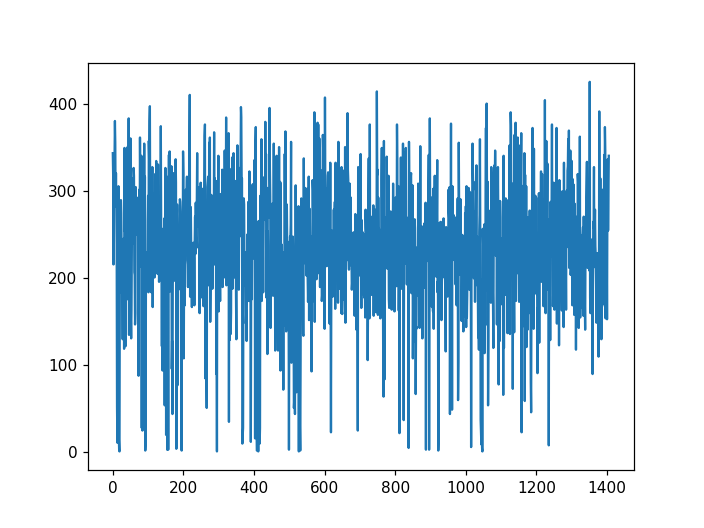

In [104]:
# number of probes histogram
fig, ax = plt.subplots()
ax.plot(cand_prob_nums)
plt.show()

In [113]:
# filter by genome counts
reload(library_tools.quality_check)

num_probes_kept = 400 # max num of probes kept for each region
filtered_pb_dict = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dict, num_probes_kept,
                                                                  hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 50
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

- Screen probes by genome counts.
-- filtering region:0, directly append 344 probes
-- filtering region:1, directly append 319 probes
-- filtering region:10, directly append 216 probes
-- filtering region:100, directly append 344 probes
-- filtering region:1000, directly append 326 probes
-- filtering region:1001, directly append 341 probes
-- filtering region:1002, directly append 381 probes
-- filtering region:1003, directly append 356 probes
-- filtering region:1004, directly append 283 probes
-- filtering region:1005, directly append 321 probes
-- filtering region:101, directly append 286 probes
-- filtering region:102, directly append 240 probes
-- filtering region:1020, directly append 52 probes
-- filtering region:1021, directly append 11 probes
-- filtering region:1023, directly append 217 probes
-- filtering region:1024, directly append 242 probes
-- filtering region:1025, directly append 306 probes
-- filtering region:1026, directly append 17 probes
-- filtering region:1027, 

In [114]:
len(filtered_pb_dict)

1352

<IPython.core.display.Javascript object>


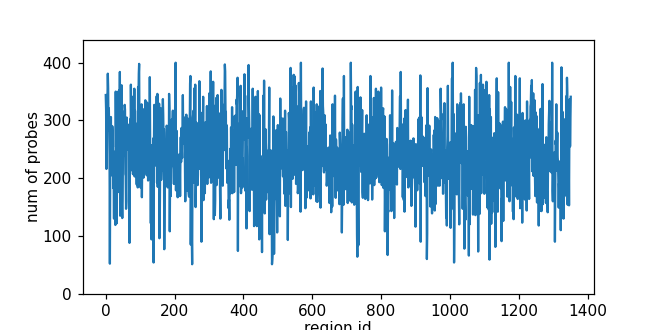

In [115]:
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dict.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_kept*1.1])
plt.show()

In [118]:
chr_2_region_savefile = os.path.join(library_folder, 'chr_2_final_region_num.pkl')
overwrite = True

filtered_reg_names = {}
for _reg, _pbde in filtered_pb_dict.items():
    if len(_pbde.kept_probes) > 0:
        filtered_reg_names[_reg] = list(_pbde.kept_probes.values())[0]['reg_name']

if not os.path.exists(chr_2_region_savefile) or overwrite:
    chr_2_region_num = {}
    for _reg, _info in filtered_reg_names.items():
        _chr = _info.split('_')[0].split(':')[0]
        if _chr not in chr_2_region_num:
            chr_2_region_num[_chr] = 1
        else:
            chr_2_region_num[_chr] += 1
    print(f"Saving into file: {chr_2_region_savefile}")

    pickle.dump(chr_2_region_num, open(chr_2_region_savefile, 'wb'))
else:
    print(f"loading from file: {chr_2_region_savefile}")
    chr_2_region_num = pickle.load(open(chr_2_region_savefile, 'rb'))

Saving into file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\chr_2_final_region_num.pkl


In [119]:
chr_2_region_num

{'1': 84,
 '2': 90,
 '14': 56,
 '15': 49,
 '16': 48,
 '17': 46,
 '18': 47,
 '19': 53,
 '20': 60,
 '21': 30,
 '22': 29,
 'X': 59,
 'Y': 14,
 '3': 77,
 '4': 74,
 '5': 69,
 '6': 64,
 '7': 59,
 '8': 55,
 '9': 53,
 '10': 65,
 '11': 61,
 '12': 62,
 '13': 48}

In [15]:
chr_2_region_num

{'1': 84,
 '2': 90,
 '3': 77,
 '4': 74,
 '5': 69,
 '6': 64,
 '7': 59,
 '8': 55,
 '9': 53,
 '10': 65,
 '11': 61,
 '12': 62,
 '13': 48,
 '14': 56,
 '15': 49,
 '16': 48,
 '17': 46,
 '18': 47,
 '19': 53,
 '20': 60,
 '21': 30,
 '22': 29,
 'X': 59,
 'Y': 14}

In [120]:
#
reg_2_start = {}

for _name, _info in filtered_reg_names.items():
    _locus = _info.split('_')[0]
    _start,_end = _locus.split(':')[1].split('-')
    reg_2_start[_name] = int(_start)
#    
chr_2_region_names = {}

for _reg, _info in filtered_reg_names.items():
    _chr = _info.split('_')[0].split(':')[0]
    if _chr not in chr_2_region_names:
        chr_2_region_names[_chr] = [_reg]
    else:
        chr_2_region_names[_chr].append(_reg)
# sort
for _chr, _regs in chr_2_region_names.items():
    _sorted_regs = sorted(_regs, key=lambda _r: reg_2_start[_r])
    chr_2_region_names[_chr] = _sorted_regs

In [122]:
print(chr_2_region_names)

{'1': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '42', '43', '44', '45', '46', '47', '57', '60', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '98'], '2': ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '137', '138', '139', '140', '141', '143', '144', '145', '146', '147', '148', '149', '150', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '1

In [123]:
overwrite_region_names = True
chr_2_region_name_savefile = os.path.join(library_folder, 'chr_2_region_names.pkl')

if not os.path.exists(chr_2_region_name_savefile) or overwrite_region_names:
    print(chr_2_region_name_savefile)
    pickle.dump(chr_2_region_names, open(chr_2_region_name_savefile, 'wb'))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\chr_2_region_names.pkl


In [124]:
list(list(filtered_pb_dict.values())[51].kept_probes.values())[0]

{'name': '15:80235001-80265000_strand_+_gene_1060_reg_1060_pb_23',
 'reg_index': 1060,
 'reg_name': '15:80235001-80265000_strand_+_gene_1060',
 'pb_index': 23,
 'strand': '+',
 'gc': 0.5714285714285715,
 'tm': 82.43016918757803,
 'map_genome': 46,
 'map_transcriptome': 0,
 'map_rep_genome': 0,
 'map_self_sequences': 26}

In [125]:
# clear memory
del(_pbde)
del(_pb_class)

<a id='3'></a>
# 3. Load and asssemble probes

<a id='3.1'></a>
## 3.1 design readout mapping dict (region_to_readout)

load directly from http://localhost:8889/notebooks/Chromatin_Analysis_Scripts/Library_design/CTP-10_Aire/CTP-10_Aire_introns_DNA-MERFISH.ipynb#3.3-assemble-probes

In [128]:
# summarize total readout usage
region_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'region_2_readout.pkl'), 'rb'))
region_2_readout_dict = {str(_r):_bs for _r,_bs in region_2_readout_dict.items()}
len(region_2_readout_dict)

1352

In [129]:
region_2_readout_dict

{'100': ['c28', 'c43', 'c97'],
 '101': ['c5', 'c12', 'c60'],
 '102': ['c15', 'c53', 'c67'],
 '103': ['c3', 'c57', 'c80'],
 '104': ['c4', 'c27', 'c87'],
 '105': ['c37', 'c47', 'c69'],
 '106': ['c1', 'c68', 'c85'],
 '107': ['c21', 'c33', 'c91'],
 '108': ['c9', 'c70', 'c94'],
 '109': ['c45', 'c56', 'c65'],
 '110': ['c13', 'c76', 'c84'],
 '111': ['c22', 'c25', 'c78'],
 '112': ['c11', 'c26', 'c49'],
 '114': ['c46', 'c62', 'c88'],
 '115': ['c6', 'c24', 'c30'],
 '116': ['c7', 'c29', 'c32'],
 '117': ['c16', 'c90', 'c95'],
 '118': ['c34', 'c44', 'c93'],
 '119': ['c19', 'c83', 'c85'],
 '120': ['c8', 'c18', 'c58'],
 '121': ['c35', 'c39', 'c72'],
 '122': ['c45', 'c57', 'c81'],
 '123': ['c41', 'c71', 'c97'],
 '124': ['c17', 'c43', 'c96'],
 '125': ['c20', 'c28', 'c36'],
 '126': ['c23', 'c31', 'c55'],
 '127': ['c53', 'c73', 'c82'],
 '128': ['c62', 'c64', 'c79'],
 '129': ['c74', 'c84', 'c95'],
 '130': ['c60', 'c61', 'c89'],
 '131': ['c0', 'c24', 'c25'],
 '132': ['c5', 'c10', 'c54'],
 '133': ['c4', 'c4

<a id='3.2'></a>
## 3.2 loading components

### primers
pick primer set 2,9

In [130]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers = library_tools.assemble.load_primers([2,9], _primer_folder=primer_folder)

- Picked primer: ID: W1A03_primer_2
Name: W1A03_primer_2
Description: W1A03_primer_2
Number of features: 0
Seq('CCCGCAATGGCTGACAACCG')
- Picked primer: ID: W1A10_primer_9
Name: W1A10_primer_9
Description: W1A10_primer_9
Number of features: 0
Seq('TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG')


### readouts

In [131]:
# collect types from region_2_readout_dict
readout_usage_by_type = {}
for _region, _infos in region_2_readout_dict.items():
    for _info in _infos:
        if _info[0] not in readout_usage_by_type:
            readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in readout_usage_by_type[_info[0]]:
            readout_usage_by_type[_info[0]].append(int(_info[1:]))

readout_usage_dict = {_type:len(_v) for _type,_v in readout_usage_by_type.items()}

In [29]:
readout_dict ={}

In [132]:
from ImageAnalysis3.classes import _allowed_kwds

readout_dict ={}
overwrite_readout_usage = True
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts'

# combo
readout_type = 'combo'
# 
_type_char = _allowed_kwds[readout_type]
_readout_start = 0
_num_color = 2

readout_dict[_type_char] = library_tools.assemble.load_readouts(readout_usage_dict[_type_char], 
                                                       _type='snr_after_630', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=_num_color, # 750,647,561
                                                       _start_id=_readout_start,
                                                       )

In [133]:
[_r.id for _r in readout_dict[_type_char]]

['NDB_784',
 'NDB_755',
 'NDB_826',
 'NDB_713',
 'NDB_865',
 'NDB_725',
 'NDB_817',
 'NDB_710',
 'NDB_652',
 'NDB_971',
 'NDB_718',
 'NDB_743',
 'NDB_847',
 'NDB_683',
 'NDB_643',
 'NDB_815',
 'NDB_760',
 'NDB_965',
 'NDB_790',
 'NDB_917',
 'NDB_778',
 'NDB_728',
 'NDB_844',
 'NDB_974',
 'NDB_961',
 'NDB_746',
 'NDB_661',
 'NDB_875',
 'NDB_901',
 'NDB_773',
 'NDB_868',
 'NDB_812',
 'NDB_1027',
 'NDB_716',
 'NDB_754',
 'NDB_860',
 'NDB_856',
 'NDB_680',
 'NDB_634',
 'NDB_737',
 'NDB_715',
 'NDB_698',
 'NDB_883',
 'NDB_863',
 'NDB_1033',
 'NDB_878',
 'NDB_631',
 'NDB_758',
 'NDB_1075',
 'NDB_653',
 'NDB_1060',
 'NDB_905',
 'NDB_805',
 'NDB_866',
 'NDB_730',
 'NDB_887',
 'NDB_880',
 'NDB_752',
 'NDB_832',
 'NDB_896',
 'NDB_835',
 'NDB_989',
 'NDB_946',
 'NDB_641',
 'NDB_721',
 'NDB_899',
 'NDB_853',
 'NDB_941',
 'NDB_838',
 'NDB_647',
 'NDB_994',
 'NDB_881',
 'NDB_1066',
 'NDB_665',
 'NDB_637',
 'NDB_734',
 'NDB_706',
 'NDB_935',
 'NDB_889',
 'NDB_788',
 'NDB_862',
 'NDB_779',
 'NDB_694',

In [134]:
# save
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
if not os.path.isfile(readout_usage_file) or overwrite_readout_usage:
    print('save')
    pickle.dump(readout_dict, open(readout_usage_file, 'wb'))

save


<a id='3.3'></a>
## 3.3 assemble probes

In [135]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

# params
assemble_params = {
    'primer_len':20,
    'num_readout_per_probe':4, 
}

In [136]:
# run assembly
cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dict, 
                                               region_2_readout_dict, readout_dict, primers, 
                                               primer_len=assemble_params['primer_len'], 
                                               num_readout_per_probe=assemble_params['num_readout_per_probe'], 
                                               unique_readout_per_probe=True,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['c']
--- assemblying 344 probes in region: 0
--- assemblying 319 probes in region: 1
--- assemblying 216 probes in region: 10
--- assemblying 344 probes in region: 100
--- assemblying 326 probes in region: 1000
--- assemblying 341 probes in region: 1001
--- assemblying 381 probes in region: 1002
--- assemblying 356 probes in region: 1003
--- assemblying 283 probes in region: 1004
--- assemblying 321 probes in region: 1005
--- assemblying 286 probes in region: 101
--- assemblying 240 probes in region: 102
--- assemblying 52 probes in region: 1020
--- assemblying 217 probes in region: 1023
--- assemblying 242 probes in region: 1024
--- assemblying 306 probes in region: 1025
--- assemblying 235 probes in region: 1029
--- assemblying 205 probes in region: 103
--- assemblying 209 probes in region: 1030
--- assemblying 290 probes in region: 1031
--- assemblying 275 probes in region: 1032
--- assemb

--- assemblying 302 probes in region: 1211
--- assemblying 278 probes in region: 1212
--- assemblying 293 probes in region: 1213
--- assemblying 317 probes in region: 1214
--- assemblying 221 probes in region: 1215
--- assemblying 216 probes in region: 1216
--- assemblying 190 probes in region: 1217
--- assemblying 235 probes in region: 1218
--- assemblying 315 probes in region: 1219
--- assemblying 270 probes in region: 122
--- assemblying 358 probes in region: 1220
--- assemblying 400 probes in region: 1221
--- assemblying 179 probes in region: 1222
--- assemblying 231 probes in region: 1224
--- assemblying 282 probes in region: 1225
--- assemblying 238 probes in region: 1226
--- assemblying 215 probes in region: 1227
--- assemblying 167 probes in region: 1228
--- assemblying 235 probes in region: 1229
--- assemblying 182 probes in region: 123
--- assemblying 223 probes in region: 1230
--- assemblying 241 probes in region: 1231
--- assemblying 237 probes in region: 1232
--- assemblyi

--- assemblying 266 probes in region: 1429
--- assemblying 186 probes in region: 143
--- assemblying 240 probes in region: 1430
--- assemblying 295 probes in region: 1434
--- assemblying 255 probes in region: 1435
--- assemblying 298 probes in region: 1436
--- assemblying 360 probes in region: 1437
--- assemblying 174 probes in region: 1438
--- assemblying 198 probes in region: 1439
--- assemblying 187 probes in region: 144
--- assemblying 236 probes in region: 1440
--- assemblying 184 probes in region: 1441
--- assemblying 248 probes in region: 1442
--- assemblying 316 probes in region: 1443
--- assemblying 314 probes in region: 1444
--- assemblying 316 probes in region: 1445
--- assemblying 274 probes in region: 1446
--- assemblying 380 probes in region: 1447
--- assemblying 267 probes in region: 1448
--- assemblying 343 probes in region: 1449
--- assemblying 178 probes in region: 145
--- assemblying 211 probes in region: 1450
--- assemblying 255 probes in region: 1451
--- assemblyin

--- assemblying 196 probes in region: 233
--- assemblying 255 probes in region: 234
--- assemblying 233 probes in region: 235
--- assemblying 182 probes in region: 236
--- assemblying 179 probes in region: 237
--- assemblying 251 probes in region: 238
--- assemblying 231 probes in region: 239
--- assemblying 279 probes in region: 24
--- assemblying 234 probes in region: 240
--- assemblying 272 probes in region: 241
--- assemblying 288 probes in region: 242
--- assemblying 165 probes in region: 243
--- assemblying 333 probes in region: 244
--- assemblying 238 probes in region: 245
--- assemblying 205 probes in region: 246
--- assemblying 234 probes in region: 247
--- assemblying 277 probes in region: 248
--- assemblying 242 probes in region: 249
--- assemblying 238 probes in region: 25
--- assemblying 172 probes in region: 250
--- assemblying 357 probes in region: 251
--- assemblying 287 probes in region: 252
--- assemblying 188 probes in region: 253
--- assemblying 282 probes in region

--- assemblying 252 probes in region: 416
--- assemblying 315 probes in region: 417
--- assemblying 200 probes in region: 418
--- assemblying 355 probes in region: 419
--- assemblying 201 probes in region: 42
--- assemblying 212 probes in region: 421
--- assemblying 298 probes in region: 422
--- assemblying 345 probes in region: 423
--- assemblying 323 probes in region: 424
--- assemblying 221 probes in region: 425
--- assemblying 350 probes in region: 426
--- assemblying 217 probes in region: 427
--- assemblying 243 probes in region: 428
--- assemblying 193 probes in region: 429
--- assemblying 235 probes in region: 43
--- assemblying 236 probes in region: 430
--- assemblying 237 probes in region: 431
--- assemblying 270 probes in region: 432
--- assemblying 357 probes in region: 435
--- assemblying 294 probes in region: 436
--- assemblying 188 probes in region: 437
--- assemblying 206 probes in region: 438
--- assemblying 310 probes in region: 439
--- assemblying 317 probes in region

--- assemblying 192 probes in region: 618
--- assemblying 282 probes in region: 619
--- assemblying 330 probes in region: 62
--- assemblying 196 probes in region: 620
--- assemblying 248 probes in region: 621
--- assemblying 247 probes in region: 622
--- assemblying 185 probes in region: 623
--- assemblying 132 probes in region: 624
--- assemblying 168 probes in region: 625
--- assemblying 118 probes in region: 626
--- assemblying 253 probes in region: 627
--- assemblying 273 probes in region: 628
--- assemblying 360 probes in region: 629
--- assemblying 241 probes in region: 63
--- assemblying 199 probes in region: 64
--- assemblying 257 probes in region: 645
--- assemblying 241 probes in region: 646
--- assemblying 219 probes in region: 647
--- assemblying 215 probes in region: 648
--- assemblying 262 probes in region: 649
--- assemblying 114 probes in region: 65
--- assemblying 241 probes in region: 650
--- assemblying 146 probes in region: 651
--- assemblying 306 probes in region: 

--- assemblying 204 probes in region: 817
--- assemblying 268 probes in region: 819
--- assemblying 255 probes in region: 820
--- assemblying 142 probes in region: 821
--- assemblying 257 probes in region: 822
--- assemblying 129 probes in region: 823
--- assemblying 288 probes in region: 824
--- assemblying 225 probes in region: 825
--- assemblying 263 probes in region: 826
--- assemblying 283 probes in region: 827
--- assemblying 377 probes in region: 828
--- assemblying 237 probes in region: 829
--- assemblying 259 probes in region: 83
--- assemblying 168 probes in region: 832
--- assemblying 204 probes in region: 833
--- assemblying 310 probes in region: 834
--- assemblying 236 probes in region: 835
--- assemblying 164 probes in region: 836
--- assemblying 302 probes in region: 837
--- assemblying 226 probes in region: 838
--- assemblying 194 probes in region: 839
--- assemblying 191 probes in region: 84
--- assemblying 264 probes in region: 840
--- assemblying 373 probes in region

# 4.Check quality


## 4.1 Load probes

Checking procedures could restart from here

In [137]:
# folder for this library
# candidate full-length probe filename
candidate_basename = 'candidate_probes.fasta' # old version
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_basename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 327516


### Manually input the following info to double check!

In [138]:
num_readout_per_probe = 4
primer_len=20
target_len=42
min_num_probes = 40
# merfish related
num_on_bits = 3

### 4.1.1 check primer usage

In [139]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 327516
True


### 4.1.2 check region probe number

In [140]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: 0 -> 344
gene: 1 -> 319
gene: 10 -> 216
gene: 100 -> 344
gene: 1000 -> 326
gene: 1001 -> 341
gene: 1002 -> 381
gene: 1003 -> 356
gene: 1004 -> 283
gene: 1005 -> 321
gene: 101 -> 286
gene: 102 -> 240
gene: 1020 -> 52
gene: 1023 -> 217
gene: 1024 -> 242
gene: 1025 -> 306
gene: 1029 -> 235
gene: 103 -> 205
gene: 1030 -> 209
gene: 1031 -> 290
gene: 1032 -> 275
gene: 1033 -> 234
gene: 1034 -> 183
gene: 1035 -> 201
gene: 1036 -> 130
gene: 1037 -> 237
gene: 1038 -> 227
gene: 1039 -> 246
gene: 104 -> 119
gene: 1040 -> 350
gene: 1041 -> 254
gene: 1042 -> 325
gene: 1043 -> 122
gene: 1044 -> 253
gene: 1045 -> 347
gene: 1046 -> 263
gene: 1047 -> 350
gene: 1048 -> 296
gene: 1049 -> 176
gene: 105 -> 352
gene: 1050 -> 267
gene: 1051 -> 384
gene: 1052 -> 135
gene: 1053 -> 351
gene: 1054 -> 320
gene: 1055 -> 268
gene: 1056 -> 361
gene: 1057 -> 155
gene: 1058 -> 131
gene: 1059 -> 164
gene: 106 -> 244
gene: 1060 -> 315
gene: 1061 -> 309
gene: 1062 -> 240
gene: 1063 -> 266
gene: 1064 -> 327
gene: 10

<IPython.core.display.Javascript object>


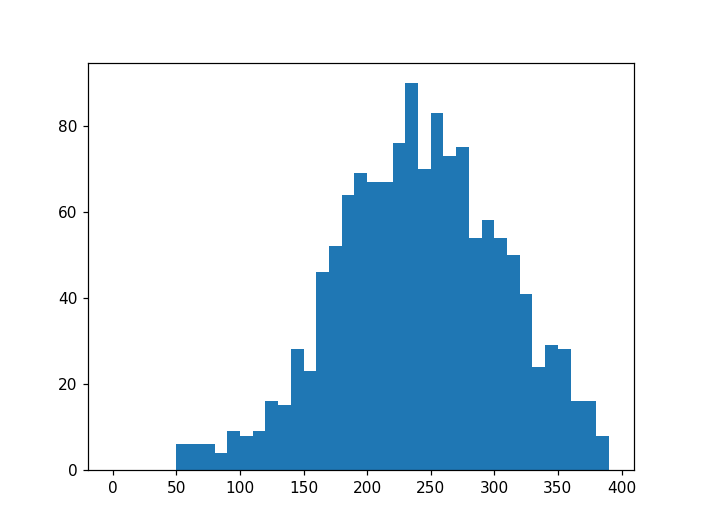

In [141]:
plt.figure()
plt.hist(list(reg_size_dic.values()), bins=np.arange(0,400,10))
plt.show()

### 4.1.3 check readout usage for each gene

In [142]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_on_bits)
print(reg2readout_check)

0 -> ['NDB_683', 'NDB_758', 'NDB_887']
1 -> ['NDB_718', 'NDB_631', 'NDB_1066']
10 -> ['NDB_844', 'NDB_812', 'NDB_637']
100 -> ['NDB_901', 'NDB_863', 'NDB_926']
1000 -> ['NDB_784', 'NDB_883', 'NDB_925']
1001 -> ['NDB_634', 'NDB_631', 'NDB_872']
1002 -> ['NDB_755', 'NDB_698', 'NDB_1033']
1003 -> ['NDB_817', 'NDB_746', 'NDB_742']
1004 -> ['NDB_683', 'NDB_878', 'NDB_896']
1005 -> ['NDB_661', 'NDB_887', 'NDB_818']
101 -> ['NDB_725', 'NDB_847', 'NDB_835']
102 -> ['NDB_815', 'NDB_866', 'NDB_941']
1020 -> ['NDB_971', 'NDB_754', 'NDB_715']
1023 -> ['NDB_868', 'NDB_832', 'NDB_929']
1024 -> ['NDB_1033', 'NDB_1075', 'NDB_872']
1025 -> ['NDB_743', 'NDB_641', 'NDB_958']
1029 -> ['NDB_680', 'NDB_896', 'NDB_818']
103 -> ['NDB_713', 'NDB_752', 'NDB_862']
1030 -> ['NDB_713', 'NDB_815', 'NDB_881']
1031 -> ['NDB_730', 'NDB_694', 'NDB_824']
1032 -> ['NDB_784', 'NDB_698', 'NDB_631']
1033 -> ['NDB_880', 'NDB_752', 'NDB_788']
1034 -> ['NDB_875', 'NDB_653', 'NDB_941']
1035 -> ['NDB_974', 'NDB_853', 'NDB_934']


### 4.1.4 check readout usage in the library

In [144]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_readout_per_probe)
print(readout2reg_check)

-- extracting probes from >region:0, region:1, region:10, region:100, region:1000, region:1001, region:1002, region:1003, region:1004, region:1005, region:101, region:102, region:1020, region:1023, region:1024, region:1025, region:1029, region:103, region:1030, region:1031, region:1032, region:1033, region:1034, region:1035, region:1036, region:1037, region:1038, region:1039, region:104, region:1040, region:1041, region:1042, region:1043, region:1044, region:1045, region:1046, region:1047, region:1048, region:1049, region:105, region:1050, region:1051, region:1052, region:1053, region:1054, region:1055, region:1056, region:1057, region:1058, region:1059, region:106, region:1060, region:1061, region:1062, region:1063, region:1064, region:1065, region:1066, region:1067, region:1068, region:1069, region:107, region:1070, region:1071, region:1072, region:1073, region:1074, region:1075, region:1076, region:1077, region:1078, region:1079, region:108, region:1080, region:1081, region:1082, re

region:300, region:302, region:303, region:304, region:305, region:306, region:307, region:308, region:309, region:31, region:310, region:311, region:312, region:313, region:314, region:315, region:316, region:317, region:318, region:319, region:32, region:320, region:321, region:322, region:323, region:324, region:325, region:326, region:327, region:328, region:329, region:33, region:330, region:331, region:332, region:333, region:334, region:335, region:336, region:337, region:338, region:339, region:34, region:340, region:341, region:342, region:343, region:344, region:345, region:346, region:347, region:348, region:349, region:35, region:350, region:351, region:352, region:353, region:354, region:355, region:356, region:357, region:358, region:359, region:36, region:360, region:361, region:362, region:363, region:364, region:365, region:366, region:367, region:368, region:37, region:370, region:371, region:372, region:373, region:374, region:375, region:376, region:377, region:379,

NDB_1027 -> ['1060', '1075', '1111', '116', '1160', '1227', '1242', '1281', '1340', '1400', '1450', '1470', '1504', '1529', '156', '193', '211', '228', '295', '313', '346', '352', '36', '376', '416', '435', '487', '500', '534', '573', '645', '668', '697', '73', '743', '753', '799', '861', '925', '966', '983']
NDB_1028 -> ['1051', '1066', '1080', '1131', '1166', '1218', '1272', '130', '1303', '1344', '1398', '1454', '1471', '1504', '1537', '17', '171', '197', '247', '309', '338', '34', '375', '396', '4', '427', '470', '491', '520', '561', '578', '617', '672', '681', '698', '745', '783', '800', '854', '920', '969']
NDB_1033 -> ['1002', '1024', '1042', '1108', '1167', '118', '1196', '1228', '1258', '1339', '1379', '1436', '1476', '1490', '153', '184', '196', '209', '251', '293', '343', '35', '358', '391', '450', '484', '497', '536', '584', '617', '649', '65', '713', '731', '756', '794', '827', '865', '888', '929', '973']
NDB_1060 -> ['1060', '1117', '1172', '1194', '1212', '1248', '1263',

### 4.1.5 check bewteen probes

In [145]:
# construct internal map
reload(check)
int_map = check._construct_internal_map(full_records, library_folder, save=False) 

In [146]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)
print(readout_count_check)

True


In [147]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

--- Sequence:loc_1:1235001-1265000_gene_0_pb_183_pos_13330_strand_+_readouts_[NDB_683_c,NDB_683_c,NDB_683_c,NDB_683_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:81, dumped
--- Sequence:loc_1:1235001-1265000_gene_0_pb_187_pos_13649_strand_+_readouts_[NDB_758_c,NDB_758_c,NDB_758_c,NDB_758_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_1:1235001-1265000_gene_0_pb_188_pos_13789_strand_+_readouts_[NDB_887_c,NDB_887_c,NDB_887_c,NDB_887_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:80, dumped
--- Sequence:loc_1:1235001-1265000_gene_0_pb_189_pos_13855_strand_+_readouts_[NDB_683_c,NDB_683_c,NDB_683_c,NDB_683_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:84, dumped
--- Sequence:loc_1:1235001-1265000_gene_0_pb_191_pos_14659_strand_-_readouts_[NDB_887_c,NDB_887_c,NDB_887_c,NDB_887_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:62, dumped
--- Sequence:loc_1:3735001-3765000_gene_1_pb_56_pos_4401_strand_-_readouts_[NDB_1066_c,NDB_1066_c,NDB_106

--- Sequence:loc_15:62235001-62265000_gene_1048_pb_100_pos_10851_strand_-_readouts_[NDB_698_c,NDB_698_c,NDB_698_c,NDB_698_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:57, dumped
--- Sequence:loc_15:62235001-62265000_gene_1048_pb_103_pos_11083_strand_-_readouts_[NDB_698_c,NDB_698_c,NDB_698_c,NDB_698_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:66, dumped
--- Sequence:loc_15:62235001-62265000_gene_1048_pb_107_pos_11397_strand_-_readouts_[NDB_751_c,NDB_751_c,NDB_751_c,NDB_751_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:80, dumped
--- Sequence:loc_15:62235001-62265000_gene_1048_pb_155_pos_16135_strand_-_readouts_[NDB_751_c,NDB_751_c,NDB_751_c,NDB_751_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_16:735001-765000_gene_1074_pb_102_pos_11145_strand_+_readouts_[NDB_725_c,NDB_725_c,NDB_725_c,NDB_725_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:68, dumped
--- Sequence:loc_16:735001-765000_gene_1074_pb_104_pos_11273_strand_-_readouts_

--- Sequence:loc_17:66735001-66765000_gene_1178_pb_160_pos_13995_strand_+_readouts_[NDB_863_c,NDB_863_c,NDB_863_c,NDB_863_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_17:66735001-66765000_gene_1178_pb_162_pos_14146_strand_+_readouts_[NDB_713_c,NDB_713_c,NDB_713_c,NDB_713_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_17:80235001-80265000_gene_1187_pb_7_pos_1300_strand_-_readouts_[NDB_788_c,NDB_788_c,NDB_788_c,NDB_788_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:55, dumped
--- Sequence:loc_18:78735001-78765000_gene_1241_pb_226_pos_19397_strand_+_readouts_[NDB_896_c,NDB_896_c,NDB_896_c,NDB_896_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_18:78735001-78765000_gene_1241_pb_236_pos_20036_strand_+_readouts_[NDB_1066_c,NDB_1066_c,NDB_1066_c,NDB_1066_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:83, dumped
--- Sequence:loc_18:78735001-78765000_gene_1241_pb_238_pos_20157_strand_+_

--- Sequence:loc_20:37485001-37515000_gene_1337_pb_226_pos_21169_strand_+_readouts_[NDB_665_c,NDB_665_c,NDB_665_c,NDB_665_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_20:48485001-48515000_gene_1348_pb_98_pos_20150_strand_+_readouts_[NDB_925_c,NDB_925_c,NDB_925_c,NDB_925_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:65, dumped
--- Sequence:loc_20:48485001-48515000_gene_1348_pb_99_pos_21022_strand_+_readouts_[NDB_743_c,NDB_743_c,NDB_743_c,NDB_743_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:59, dumped
--- Sequence:loc_20:48485001-48515000_gene_1348_pb_102_pos_22426_strand_+_readouts_[NDB_743_c,NDB_743_c,NDB_743_c,NDB_743_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:55, dumped
--- Sequence:loc_20:48485001-48515000_gene_1348_pb_111_pos_25553_strand_+_readouts_[NDB_743_c,NDB_743_c,NDB_743_c,NDB_743_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:70, dumped
--- Sequence:loc_20:48485001-48515000_gene_1348_pb_122_pos_27710_strand_+_rea

--- Sequence:loc_22:29485001-29515000_gene_1439_pb_152_pos_24719_strand_-_readouts_[NDB_940_c,NDB_940_c,NDB_940_c,NDB_940_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:60, dumped
--- Sequence:loc_22:29485001-29515000_gene_1439_pb_153_pos_24869_strand_+_readouts_[NDB_790_c,NDB_790_c,NDB_790_c,NDB_790_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:61, dumped
--- Sequence:loc_22:35485001-35515000_gene_1445_pb_73_pos_6569_strand_+_readouts_[NDB_716_c,NDB_716_c,NDB_716_c,NDB_716_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_22:35485001-35515000_gene_1445_pb_74_pos_6800_strand_+_readouts_[NDB_832_c,NDB_832_c,NDB_832_c,NDB_832_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:70, dumped
--- Sequence:loc_22:35485001-35515000_gene_1445_pb_75_pos_6856_strand_+_readouts_[NDB_961_c,NDB_961_c,NDB_961_c,NDB_961_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:70, dumped
--- Sequence:loc_22:35485001-35515000_gene_1445_pb_76_pos_6937_strand_+_readouts_

--- Sequence:loc_4:83735001-83765000_gene_307_pb_125_pos_20855_strand_-_readouts_[NDB_926_c,NDB_926_c,NDB_926_c,NDB_926_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:153, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_36_pos_4620_strand_+_readouts_[NDB_643_c,NDB_643_c,NDB_643_c,NDB_643_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:71, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_37_pos_4701_strand_-_readouts_[NDB_1027_c,NDB_1027_c,NDB_1027_c,NDB_1027_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:91, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_38_pos_5467_strand_-_readouts_[NDB_878_c,NDB_878_c,NDB_878_c,NDB_878_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:84, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_39_pos_5728_strand_+_readouts_[NDB_643_c,NDB_643_c,NDB_643_c,NDB_643_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:52, dumped
--- Sequence:loc_4:181235001-181265000_gene_346_pb_40_pos_6638_strand_-_readouts

--- Sequence:loc_7:68735001-68765000_gene_517_pb_24_pos_2347_strand_-_readouts_[NDB_974_c,NDB_974_c,NDB_974_c,NDB_974_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:53, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_25_pos_2407_strand_-_readouts_[NDB_878_c,NDB_878_c,NDB_878_c,NDB_878_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:68, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_26_pos_2479_strand_-_readouts_[NDB_866_c,NDB_866_c,NDB_866_c,NDB_866_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:79, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_29_pos_2681_strand_+_readouts_[NDB_866_c,NDB_866_c,NDB_866_c,NDB_866_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:63, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_30_pos_2755_strand_+_readouts_[NDB_974_c,NDB_974_c,NDB_974_c,NDB_974_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:63, dumped
--- Sequence:loc_7:68735001-68765000_gene_517_pb_31_pos_2825_strand_+_readouts_[NDB_878_c,NDB_8

--- Sequence:loc_11:62985001-63015000_gene_777_pb_48_pos_4612_strand_-_readouts_[NDB_716_c,NDB_716_c,NDB_716_c,NDB_716_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:97, dumped
--- Sequence:loc_11:74985001-75015000_gene_783_pb_197_pos_23135_strand_+_readouts_[NDB_1028_c,NDB_1028_c,NDB_1028_c,NDB_1028_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:129, dumped
--- Sequence:loc_1:201235001-201265000_gene_80_pb_152_pos_21019_strand_-_readouts_[NDB_721_c,NDB_721_c,NDB_721_c,NDB_721_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:66, dumped
--- Sequence:loc_1:201235001-201265000_gene_80_pb_154_pos_21355_strand_+_readouts_[NDB_737_c,NDB_737_c,NDB_737_c,NDB_737_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:58, dumped
--- Sequence:loc_1:201235001-201265000_gene_80_pb_157_pos_22005_strand_+_readouts_[NDB_737_c,NDB_737_c,NDB_737_c,NDB_737_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:72, dumped
--- Sequence:loc_1:201235001-201265000_gene_80_pb_158_pos_22153_strand_+_read

--- Sequence:loc_14:50235001-50265000_gene_969_pb_21_pos_3641_strand_-_readouts_[NDB_875_c,NDB_875_c,NDB_875_c,NDB_875_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:51, dumped
--- Sequence:loc_14:57735001-57765000_gene_974_pb_121_pos_18282_strand_+_readouts_[NDB_889_c,NDB_889_c,NDB_889_c,NDB_889_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:60, dumped
--- Sequence:loc_14:59235001-59265000_gene_975_pb_60_pos_5799_strand_+_readouts_[NDB_817_c,NDB_817_c,NDB_817_c,NDB_817_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:90, dumped
--- Sequence:loc_1:246235001-246265000_gene_98_pb_98_pos_16513_strand_+_readouts_[NDB_946_c,NDB_946_c,NDB_946_c,NDB_946_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:56, dumped
--- Sequence:loc_1:246235001-246265000_gene_98_pb_100_pos_17135_strand_-_readouts_[NDB_844_c,NDB_844_c,NDB_844_c,NDB_844_c]_primers_[W1A03_primer_2,W1A10_primer_9] got hits:54, dumped
--- Sequence:loc_14:77235001-77265000_gene_987_pb_7_pos_405_strand_+_readouts_[NDB_99

In [148]:
# clear memory
del(int_map)

### 4.1.6 finish checking, save

In [149]:
print(len(kept_records), len(cand_probes))

327063 327516


In [150]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

In [151]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)

<module 'ImageAnalysis3.library_tools.quality_check' from 'E:\\Users\\puzheng_new\\Documents\\Chromatin_Analysis_Scripts\\Library_design\\CTP-14-human_brain_genome\\..\\..\\..\\..\\Documents\\ImageAnalysis3\\library_tools\\quality_check.py'>

In [152]:
if 'kept_records' not in locals() or len(kept_records) == 0:
    kept_records = []
    with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'r') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            kept_records.append(record)
print(len(kept_records))

327063


In [153]:
blast_database = os.path.join(reference_folder, 'blast_database', 'hg38')

check.Blast_probes(kept_records, library_folder, num_threads=44, 
                   blast_db=blast_database, blast_evalue=100, overwrite=True)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\blast_database\hg38
-- number of probes loaded: 327063
-- processing region: 0 with 339 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_0.fasta
--- *blasting region: 0
--- total time for blast 0: 22.302s.
-- processing region: 1 with 306 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1.fasta
--- *blasting region: 1
--- total time for blast 1: 14.681s.
-- processing region: 10 with 216 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_10.fasta
--- *blasting region: 10
--- total time for blast 10: 14.056s.
-- processing region: 100 with 344 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human

--- total time for blast 1043: 13.599s.
-- processing region: 1044 with 253 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1044.fasta
--- *blasting region: 1044
--- total time for blast 1044: 13.597s.
-- processing region: 1045 with 347 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1045.fasta
--- *blasting region: 1045
--- total time for blast 1045: 15.639s.
-- processing region: 1046 with 263 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1046.fasta
--- *blasting region: 1046
--- total time for blast 1046: 13.001s.
-- processing region: 1047 with 350 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1047.fasta
--- *blasting region: 1047
--- 

--- total time for blast 1073: 13.600s.
-- processing region: 1074 with 266 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1074.fasta
--- *blasting region: 1074
--- total time for blast 1074: 10.206s.
-- processing region: 1075 with 256 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1075.fasta
--- *blasting region: 1075
--- total time for blast 1075: 10.883s.
-- processing region: 1076 with 293 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1076.fasta
--- *blasting region: 1076
--- total time for blast 1076: 13.714s.
-- processing region: 1077 with 88 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1077.fasta
--- *blasting region: 1077
--- t

--- total time for blast 1114: 9.357s.
-- processing region: 1115 with 253 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1115.fasta
--- *blasting region: 1115
--- total time for blast 1115: 14.674s.
-- processing region: 1116 with 184 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1116.fasta
--- *blasting region: 1116
--- total time for blast 1116: 16.571s.
-- processing region: 1117 with 288 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1117.fasta
--- *blasting region: 1117
--- total time for blast 1117: 14.012s.
-- processing region: 1118 with 231 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1118.fasta
--- *blasting region: 1118
--- t

--- total time for blast 1145: 8.923s.
-- processing region: 1146 with 94 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1146.fasta
--- *blasting region: 1146
--- total time for blast 1146: 4.739s.
-- processing region: 1147 with 257 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1147.fasta
--- *blasting region: 1147
--- total time for blast 1147: 12.955s.
-- processing region: 1148 with 101 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1148.fasta
--- *blasting region: 1148
--- total time for blast 1148: 5.540s.
-- processing region: 115 with 224 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_115.fasta
--- *blasting region: 115
--- total t

--- total time for blast 1183: 15.056s.
-- processing region: 1184 with 310 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1184.fasta
--- *blasting region: 1184
--- total time for blast 1184: 12.921s.
-- processing region: 1186 with 265 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1186.fasta
--- *blasting region: 1186
--- total time for blast 1186: 31.931s.
-- processing region: 1187 with 284 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1187.fasta
--- *blasting region: 1187
--- total time for blast 1187: 12.868s.
-- processing region: 1188 with 77 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1188.fasta
--- *blasting region: 1188
--- t

--- total time for blast 1218: 10.745s.
-- processing region: 1219 with 315 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1219.fasta
--- *blasting region: 1219
--- total time for blast 1219: 12.031s.
-- processing region: 122 with 270 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_122.fasta
--- *blasting region: 122
--- total time for blast 122: 14.132s.
-- processing region: 1220 with 358 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1220.fasta
--- *blasting region: 1220
--- total time for blast 1220: 12.276s.
-- processing region: 1221 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1221.fasta
--- *blasting region: 1221
--- tota

--- total time for blast 1249: 10.018s.
-- processing region: 125 with 251 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_125.fasta
--- *blasting region: 125
--- total time for blast 125: 16.371s.
-- processing region: 1250 with 310 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1250.fasta
--- *blasting region: 1250
--- total time for blast 1250: 11.473s.
-- processing region: 1251 with 181 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1251.fasta
--- *blasting region: 1251
--- total time for blast 1251: 14.856s.
-- processing region: 1252 with 181 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1252.fasta
--- *blasting region: 1252
--- tota

--- total time for blast 1281: 12.844s.
-- processing region: 1282 with 234 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1282.fasta
--- *blasting region: 1282
--- total time for blast 1282: 9.515s.
-- processing region: 1284 with 188 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1284.fasta
--- *blasting region: 1284
--- total time for blast 1284: 9.634s.
-- processing region: 1285 with 206 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1285.fasta
--- *blasting region: 1285
--- total time for blast 1285: 10.428s.
-- processing region: 1286 with 263 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1286.fasta
--- *blasting region: 1286
--- to

--- total time for blast 1313: 10.548s.
-- processing region: 1314 with 272 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1314.fasta
--- *blasting region: 1314
--- total time for blast 1314: 14.549s.
-- processing region: 1315 with 347 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1315.fasta
--- *blasting region: 1315
--- total time for blast 1315: 14.307s.
-- processing region: 1316 with 301 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1316.fasta
--- *blasting region: 1316
--- total time for blast 1316: 14.602s.
-- processing region: 1317 with 344 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1317.fasta
--- *blasting region: 1317
--- 

--- total time for blast 1347: 14.652s.
-- processing region: 1348 with 123 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1348.fasta
--- *blasting region: 1348
--- total time for blast 1348: 6.957s.
-- processing region: 1349 with 302 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1349.fasta
--- *blasting region: 1349
--- total time for blast 1349: 14.482s.
-- processing region: 1350 with 265 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1350.fasta
--- *blasting region: 1350
--- total time for blast 1350: 12.624s.
-- processing region: 1351 with 353 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1351.fasta
--- *blasting region: 1351
--- t

--- total time for blast 1391: 13.706s.
-- processing region: 1392 with 244 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1392.fasta
--- *blasting region: 1392
--- total time for blast 1392: 15.894s.
-- processing region: 1393 with 323 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1393.fasta
--- *blasting region: 1393
--- total time for blast 1393: 14.248s.
-- processing region: 1394 with 174 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1394.fasta
--- *blasting region: 1394
--- total time for blast 1394: 13.469s.
-- processing region: 1395 with 282 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1395.fasta
--- *blasting region: 1395
--- 

--- total time for blast 1443: 15.534s.
-- processing region: 1444 with 314 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1444.fasta
--- *blasting region: 1444
--- total time for blast 1444: 16.360s.
-- processing region: 1445 with 312 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1445.fasta
--- *blasting region: 1445
--- total time for blast 1445: 29.889s.
-- processing region: 1446 with 274 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1446.fasta
--- *blasting region: 1446
--- total time for blast 1446: 11.993s.
-- processing region: 1447 with 380 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1447.fasta
--- *blasting region: 1447
--- 

--- total time for blast 1474: 10.897s.
-- processing region: 1475 with 234 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1475.fasta
--- *blasting region: 1475
--- total time for blast 1475: 11.868s.
-- processing region: 1476 with 197 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1476.fasta
--- *blasting region: 1476
--- total time for blast 1476: 16.659s.
-- processing region: 1477 with 341 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1477.fasta
--- *blasting region: 1477
--- total time for blast 1477: 14.337s.
-- processing region: 1478 with 230 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1478.fasta
--- *blasting region: 1478
--- 

--- total time for blast 1506: 10.992s.
-- processing region: 1507 with 242 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1507.fasta
--- *blasting region: 1507
--- total time for blast 1507: 9.786s.
-- processing region: 1508 with 189 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1508.fasta
--- *blasting region: 1508
--- total time for blast 1508: 9.758s.
-- processing region: 1509 with 188 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1509.fasta
--- *blasting region: 1509
--- total time for blast 1509: 10.959s.
-- processing region: 1510 with 176 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_1510.fasta
--- *blasting region: 1510
--- to

--- total time for blast 156: 19.448s.
-- processing region: 157 with 255 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_157.fasta
--- *blasting region: 157
--- total time for blast 157: 11.701s.
-- processing region: 158 with 227 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_158.fasta
--- *blasting region: 158
--- total time for blast 158: 10.510s.
-- processing region: 159 with 231 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_159.fasta
--- *blasting region: 159
--- total time for blast 159: 9.822s.
-- processing region: 16 with 245 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_16.fasta
--- *blasting region: 16
--- total time for blast

--- total time for blast 187: 12.567s.
-- processing region: 188 with 233 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_188.fasta
--- *blasting region: 188
--- total time for blast 188: 10.894s.
-- processing region: 189 with 191 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_189.fasta
--- *blasting region: 189
--- total time for blast 189: 12.040s.
-- processing region: 19 with 391 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_19.fasta
--- *blasting region: 19
--- total time for blast 19: 15.727s.
-- processing region: 190 with 150 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_190.fasta
--- *blasting region: 190
--- total time for blast

--- total time for blast 217: 12.038s.
-- processing region: 218 with 252 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_218.fasta
--- *blasting region: 218
--- total time for blast 218: 11.127s.
-- processing region: 219 with 258 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_219.fasta
--- *blasting region: 219
--- total time for blast 219: 15.148s.
-- processing region: 22 with 303 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_22.fasta
--- *blasting region: 22
--- total time for blast 22: 13.972s.
-- processing region: 220 with 214 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_220.fasta
--- *blasting region: 220
--- total time for blast

--- total time for blast 25: 11.189s.
-- processing region: 250 with 172 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_250.fasta
--- *blasting region: 250
--- total time for blast 250: 9.275s.
-- processing region: 251 with 357 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_251.fasta
--- *blasting region: 251
--- total time for blast 251: 17.015s.
-- processing region: 252 with 287 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_252.fasta
--- *blasting region: 252
--- total time for blast 252: 14.354s.
-- processing region: 253 with 188 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_253.fasta
--- *blasting region: 253
--- total time for bla

--- total time for blast 280: 13.028s.
-- processing region: 281 with 239 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_281.fasta
--- *blasting region: 281
--- total time for blast 281: 11.015s.
-- processing region: 282 with 262 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_282.fasta
--- *blasting region: 282
--- total time for blast 282: 10.765s.
-- processing region: 283 with 293 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_283.fasta
--- *blasting region: 283
--- total time for blast 283: 15.666s.
-- processing region: 284 with 215 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_284.fasta
--- *blasting region: 284
--- total time for b

--- total time for blast 312: 12.488s.
-- processing region: 313 with 182 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_313.fasta
--- *blasting region: 313
--- total time for blast 313: 10.169s.
-- processing region: 314 with 253 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_314.fasta
--- *blasting region: 314
--- total time for blast 314: 11.588s.
-- processing region: 315 with 228 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_315.fasta
--- *blasting region: 315
--- total time for blast 315: 11.046s.
-- processing region: 316 with 183 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_316.fasta
--- *blasting region: 316
--- total time for b

--- total time for blast 343: 13.137s.
-- processing region: 344 with 234 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_344.fasta
--- *blasting region: 344
--- total time for blast 344: 10.430s.
-- processing region: 345 with 225 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_345.fasta
--- *blasting region: 345
--- total time for blast 345: 10.024s.
-- processing region: 346 with 273 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_346.fasta
--- *blasting region: 346
--- total time for blast 346: 10.344s.
-- processing region: 347 with 202 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_347.fasta
--- *blasting region: 347
--- total time for b

--- total time for blast 375: 10.095s.
-- processing region: 376 with 222 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_376.fasta
--- *blasting region: 376
--- total time for blast 376: 10.468s.
-- processing region: 377 with 340 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_377.fasta
--- *blasting region: 377
--- total time for blast 377: 13.108s.
-- processing region: 379 with 287 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_379.fasta
--- *blasting region: 379
--- total time for blast 379: 19.842s.
-- processing region: 38 with 211 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_38.fasta
--- *blasting region: 38
--- total time for blas

--- total time for blast 406: 12.584s.
-- processing region: 407 with 305 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_407.fasta
--- *blasting region: 407
--- total time for blast 407: 15.877s.
-- processing region: 408 with 162 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_408.fasta
--- *blasting region: 408
--- total time for blast 408: 11.295s.
-- processing region: 409 with 221 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_409.fasta
--- *blasting region: 409
--- total time for blast 409: 17.430s.
-- processing region: 410 with 271 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_410.fasta
--- *blasting region: 410
--- total time for b

--- total time for blast 440: 14.953s.
-- processing region: 441 with 183 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_441.fasta
--- *blasting region: 441
--- total time for blast 441: 8.192s.
-- processing region: 442 with 276 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_442.fasta
--- *blasting region: 442
--- total time for blast 442: 13.975s.
-- processing region: 443 with 241 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_443.fasta
--- *blasting region: 443
--- total time for blast 443: 11.495s.
-- processing region: 444 with 307 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_444.fasta
--- *blasting region: 444
--- total time for bl

--- total time for blast 472: 17.860s.
-- processing region: 473 with 203 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_473.fasta
--- *blasting region: 473
--- total time for blast 473: 15.078s.
-- processing region: 474 with 235 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_474.fasta
--- *blasting region: 474
--- total time for blast 474: 11.658s.
-- processing region: 475 with 263 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_475.fasta
--- *blasting region: 475
--- total time for blast 475: 11.948s.
-- processing region: 476 with 236 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_476.fasta
--- *blasting region: 476
--- total time for b

--- total time for blast 506: 12.657s.
-- processing region: 507 with 202 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_507.fasta
--- *blasting region: 507
--- total time for blast 507: 12.830s.
-- processing region: 508 with 221 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_508.fasta
--- *blasting region: 508
--- total time for blast 508: 10.776s.
-- processing region: 509 with 272 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_509.fasta
--- *blasting region: 509
--- total time for blast 509: 15.105s.
-- processing region: 510 with 336 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_510.fasta
--- *blasting region: 510
--- total time for b

--- total time for blast 543: 14.275s.
-- processing region: 544 with 276 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_544.fasta
--- *blasting region: 544
--- total time for blast 544: 14.393s.
-- processing region: 545 with 267 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_545.fasta
--- *blasting region: 545
--- total time for blast 545: 12.068s.
-- processing region: 546 with 305 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_546.fasta
--- *blasting region: 546
--- total time for blast 546: 14.944s.
-- processing region: 548 with 191 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_548.fasta
--- *blasting region: 548
--- total time for b

--- total time for blast 578: 14.839s.
-- processing region: 579 with 151 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_579.fasta
--- *blasting region: 579
--- total time for blast 579: 12.749s.
-- processing region: 580 with 202 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_580.fasta
--- *blasting region: 580
--- total time for blast 580: 9.367s.
-- processing region: 581 with 250 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_581.fasta
--- *blasting region: 581
--- total time for blast 581: 18.260s.
-- processing region: 582 with 199 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_582.fasta
--- *blasting region: 582
--- total time for bl

--- total time for blast 612: 12.898s.
-- processing region: 613 with 200 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_613.fasta
--- *blasting region: 613
--- total time for blast 613: 10.522s.
-- processing region: 614 with 277 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_614.fasta
--- *blasting region: 614
--- total time for blast 614: 12.343s.
-- processing region: 615 with 258 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_615.fasta
--- *blasting region: 615
--- total time for blast 615: 12.191s.
-- processing region: 616 with 173 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_616.fasta
--- *blasting region: 616
--- total time for b

--- total time for blast 657: 9.316s.
-- processing region: 658 with 311 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_658.fasta
--- *blasting region: 658
--- total time for blast 658: 14.533s.
-- processing region: 659 with 54 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_659.fasta
--- *blasting region: 659
--- total time for blast 659: 4.842s.
-- processing region: 66 with 127 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_66.fasta
--- *blasting region: 66
--- total time for blast 66: 8.271s.
-- processing region: 660 with 278 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_660.fasta
--- *blasting region: 660
--- total time for blast 660

--- total time for blast 689: 10.560s.
-- processing region: 69 with 128 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_69.fasta
--- *blasting region: 69
--- total time for blast 69: 7.935s.
-- processing region: 690 with 289 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_690.fasta
--- *blasting region: 690
--- total time for blast 690: 11.958s.
-- processing region: 691 with 270 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_691.fasta
--- *blasting region: 691
--- total time for blast 691: 12.350s.
-- processing region: 692 with 189 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_692.fasta
--- *blasting region: 692
--- total time for blast 

--- total time for blast 72: 16.159s.
-- processing region: 720 with 218 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_720.fasta
--- *blasting region: 720
--- total time for blast 720: 10.393s.
-- processing region: 721 with 270 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_721.fasta
--- *blasting region: 721
--- total time for blast 721: 12.045s.
-- processing region: 722 with 309 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_722.fasta
--- *blasting region: 722
--- total time for blast 722: 13.129s.
-- processing region: 723 with 73 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_723.fasta
--- *blasting region: 723
--- total time for bla

--- total time for blast 752: 14.818s.
-- processing region: 753 with 145 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_753.fasta
--- *blasting region: 753
--- total time for blast 753: 6.926s.
-- processing region: 754 with 344 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_754.fasta
--- *blasting region: 754
--- total time for blast 754: 11.577s.
-- processing region: 755 with 59 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_755.fasta
--- *blasting region: 755
--- total time for blast 755: 7.157s.
-- processing region: 756 with 319 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_756.fasta
--- *blasting region: 756
--- total time for blas

--- total time for blast 787: 13.512s.
-- processing region: 788 with 182 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_788.fasta
--- *blasting region: 788
--- total time for blast 788: 13.638s.
-- processing region: 789 with 209 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_789.fasta
--- *blasting region: 789
--- total time for blast 789: 16.602s.
-- processing region: 79 with 198 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_79.fasta
--- *blasting region: 79
--- total time for blast 79: 13.171s.
-- processing region: 790 with 91 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_790.fasta
--- *blasting region: 790
--- total time for blast 

--- total time for blast 817: 9.868s.
-- processing region: 819 with 268 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_819.fasta
--- *blasting region: 819
--- total time for blast 819: 33.025s.
-- processing region: 820 with 255 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_820.fasta
--- *blasting region: 820
--- total time for blast 820: 14.272s.
-- processing region: 821 with 142 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_821.fasta
--- *blasting region: 821
--- total time for blast 821: 8.587s.
-- processing region: 822 with 257 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_822.fasta
--- *blasting region: 822
--- total time for bla

--- total time for blast 852: 13.778s.
-- processing region: 853 with 194 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_853.fasta
--- *blasting region: 853
--- total time for blast 853: 13.035s.
-- processing region: 854 with 215 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_854.fasta
--- *blasting region: 854
--- total time for blast 854: 15.737s.
-- processing region: 855 with 199 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_855.fasta
--- *blasting region: 855
--- total time for blast 855: 15.706s.
-- processing region: 856 with 163 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_856.fasta
--- *blasting region: 856
--- total time for b

--- total time for blast 891: 9.538s.
-- processing region: 892 with 314 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_892.fasta
--- *blasting region: 892
--- total time for blast 892: 13.865s.
-- processing region: 893 with 252 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_893.fasta
--- *blasting region: 893
--- total time for blast 893: 10.892s.
-- processing region: 894 with 308 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_894.fasta
--- *blasting region: 894
--- total time for blast 894: 13.146s.
-- processing region: 895 with 294 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_895.fasta
--- *blasting region: 895
--- total time for bl

--- total time for blast 921: 8.878s.
-- processing region: 922 with 174 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_922.fasta
--- *blasting region: 922
--- total time for blast 922: 16.517s.
-- processing region: 923 with 141 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_923.fasta
--- *blasting region: 923
--- total time for blast 923: 15.412s.
-- processing region: 924 with 236 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_924.fasta
--- *blasting region: 924
--- total time for blast 924: 12.257s.
-- processing region: 925 with 214 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_925.fasta
--- *blasting region: 925
--- total time for bl

--- total time for blast 964: 11.505s.
-- processing region: 965 with 191 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_965.fasta
--- *blasting region: 965
--- total time for blast 965: 11.129s.
-- processing region: 966 with 161 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_966.fasta
--- *blasting region: 966
--- total time for blast 966: 12.232s.
-- processing region: 967 with 229 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_967.fasta
--- *blasting region: 967
--- total time for blast 967: 14.380s.
-- processing region: 968 with 228 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_968.fasta
--- *blasting region: 968
--- total time for b

--- total time for blast 997: 12.652s.
-- processing region: 999 with 341 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\blast\probe_gene_999.fasta
--- *blasting region: 999
--- total time for blast 999: 13.933s.


### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [154]:
# screen
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
num_probes_per_region = 120
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             hard_thres=target_len,
                                                                                             soft_count_th=50,
                                                                                             )

- Number of probes loaded: 327063
- Number of regions in this library: 1352
-- checking probes in region: 0
--- gene=0, id=179 removed by soft count = 135
--- gene=0, id=186 removed by hard count = 12
--- gene=0, id=200 removed by soft count = 61
--- gene=0, id=201 removed by soft count = 87
--- gene=0, id=202 removed by soft count = 232
--- number of probes: 339 , kept by blast: 334 , if remove dups: 334
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1
--- gene=1, id=67 removed by soft count = 197
--- gene=1, id=68 removed by soft count = 113
--- gene=1, id=150 removed by soft count = 106
--- gene=1, id=158 removed by soft count = 104
--- gene=1, id=161 removed by soft count = 134
--- gene=1, id=162 removed by soft count = 168
--- gene=1, id=163 removed by soft count = 144
--- gene=1, id=164 removed by soft count = 132
--- gene=1, id=165 removed by soft count = 307
--- number of probes: 306 , kept 

--- gene=1025, id=283 removed by soft count = 76
--- number of probes: 306 , kept by blast: 300 , if remove dups: 300
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1029
--- gene=1029, id=159 removed by soft count = 57
--- gene=1029, id=230 removed by soft count = 69
--- gene=1029, id=232 removed by soft count = 361
--- number of probes: 235 , kept by blast: 232 , if remove dups: 232
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 103
--- gene=103, id=21 removed by soft count = 76
--- gene=103, id=29 removed by soft count = 63
--- number of probes: 205 , kept by blast: 203 , if remove dups: 203
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1030
--- gene=1030, id=72 removed by soft count = 99
--- number of probes: 209 , kept by

--- gene=1044, id=35 removed by soft count = 301
--- gene=1044, id=74 removed by hard count = 0
--- gene=1044, id=246 removed by soft count = 72
--- gene=1044, id=248 removed by soft count = 67
--- number of probes: 253 , kept by blast: 249 , if remove dups: 249
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1045
--- number of probes: 347 , kept by blast: 347 , if remove dups: 347
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1046
--- gene=1046, id=216 removed by soft count = 60
--- gene=1046, id=217 removed by soft count = 216
--- gene=1046, id=218 removed by soft count = 157
--- number of probes: 263 , kept by blast: 260 , if remove dups: 260
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1047
--- gene=1047, id=27 removed b

--- gene=1057, id=74 removed by soft count = 172
--- gene=1057, id=106 removed by soft count = 759
--- number of probes: 155 , kept by blast: 148 , if remove dups: 147
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1058
--- gene=1058, id=1 removed by soft count = 509
--- gene=1058, id=2 removed by soft count = 203
--- gene=1058, id=36 removed by soft count = 76
--- gene=1058, id=62 removed by soft count = 106
--- gene=1058, id=69 removed by soft count = 134
--- gene=1058, id=86 removed by soft count = 82
--- gene=1058, id=87 removed by soft count = 167
--- number of probes: 131 , kept by blast: 124 , if remove dups: 124
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1059
--- gene=1059, id=2 removed by soft count = 56
--- gene=1059, id=3 removed by soft count = 62
--- gene=1059, id=4 removed by soft count = 79
---

--- gene=1071, id=13 removed by soft count = 63
--- gene=1071, id=28 removed by soft count = 51
--- gene=1071, id=194 removed by soft count = 51
--- gene=1071, id=196 removed by soft count = 359
--- gene=1071, id=238 removed by soft count = 128
--- number of probes: 291 , kept by blast: 286 , if remove dups: 286
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1072
--- gene=1072, id=74 removed by soft count = 97
--- gene=1072, id=76 removed by soft count = 80
--- gene=1072, id=82 removed by soft count = 685
--- gene=1072, id=84 removed by soft count = 124
--- gene=1072, id=86 removed by soft count = 114
--- gene=1072, id=87 removed by soft count = 94
--- gene=1072, id=256 removed by soft count = 52
--- number of probes: 259 , kept by blast: 252 , if remove dups: 252
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 10

--- gene=1091, id=34 removed by soft count = 107
--- gene=1091, id=39 removed by soft count = 127
--- gene=1091, id=41 removed by soft count = 396
--- gene=1091, id=43 removed by soft count = 203
--- gene=1091, id=44 removed by soft count = 640
--- gene=1091, id=45 removed by soft count = 385
--- gene=1091, id=47 removed by soft count = 158
--- gene=1091, id=50 removed by soft count = 162
--- gene=1091, id=65 removed by soft count = 544
--- gene=1091, id=122 removed by soft count = 142
--- gene=1091, id=143 removed by soft count = 78
--- gene=1091, id=147 removed by soft count = 606
--- gene=1091, id=160 removed by soft count = 82
--- gene=1091, id=204 removed by soft count = 355
--- gene=1091, id=205 removed by soft count = 816
--- number of probes: 226 , kept by blast: 211 , if remove dups: 211
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1092
--- gene=1092, id=25 removed by soft count = 4840
--

--- gene=1116, id=93 removed by soft count = 102
--- gene=1116, id=116 removed by soft count = 185
--- gene=1116, id=117 removed by soft count = 498
--- gene=1116, id=123 removed by soft count = 235
--- gene=1116, id=125 removed by soft count = 192
--- gene=1116, id=145 removed by soft count = 246
--- gene=1116, id=146 removed by soft count = 59
--- gene=1116, id=148 removed by soft count = 60
--- gene=1116, id=149 removed by soft count = 290
--- gene=1116, id=150 removed by soft count = 53
--- gene=1116, id=157 removed by soft count = 8907
--- gene=1116, id=158 removed by soft count = 89
--- gene=1116, id=159 removed by soft count = 75
--- gene=1116, id=161 removed by soft count = 60
--- gene=1116, id=162 removed by soft count = 81
--- number of probes: 184 , kept by blast: 162 , if remove dups: 162
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1117
--- gene=1117, id=69 removed by soft count = 57


--- gene=1130, id=158 removed by soft count = 1076
--- number of probes: 311 , kept by blast: 307 , if remove dups: 307
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1131
--- gene=1131, id=170 removed by soft count = 68
--- gene=1131, id=171 removed by soft count = 83
--- number of probes: 272 , kept by blast: 270 , if remove dups: 269
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1132
--- gene=1132, id=38 removed by soft count = 56
--- gene=1132, id=39 removed by soft count = 61
--- gene=1132, id=40 removed by soft count = 57
--- gene=1132, id=94 removed by soft count = 88
--- gene=1132, id=178 removed by soft count = 180
--- number of probes: 288 , kept by blast: 283 , if remove dups: 283
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probe

--- gene=115, id=6 removed by soft count = 843
--- gene=115, id=11 removed by soft count = 99
--- gene=115, id=101 removed by soft count = 123
--- gene=115, id=102 removed by soft count = 53
--- number of probes: 224 , kept by blast: 220 , if remove dups: 220
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1152
--- gene=1152, id=0 removed by soft count = 112
--- gene=1152, id=3 removed by soft count = 304
--- gene=1152, id=5 removed by soft count = 353
--- gene=1152, id=6 removed by soft count = 490
--- gene=1152, id=9 removed by soft count = 507
--- number of probes: 194 , kept by blast: 189 , if remove dups: 185
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1153
--- gene=1153, id=72 removed by soft count = 76
--- gene=1153, id=145 removed by soft count = 407
--- number of probes: 269 , kept by blast: 267 , if r

--- number of probes: 268 , kept by blast: 257 , if remove dups: 257
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1172
--- gene=1172, id=216 removed by soft count = 233
--- number of probes: 329 , kept by blast: 328 , if remove dups: 328
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1173
--- gene=1173, id=18 removed by soft count = 280
--- gene=1173, id=24 removed by soft count = 158
--- gene=1173, id=25 removed by soft count = 64
--- gene=1173, id=26 removed by soft count = 167
--- gene=1173, id=32 removed by soft count = 334
--- gene=1173, id=87 removed by soft count = 141
--- number of probes: 96 , kept by blast: 90 , if remove dups: 90
--- remove duplicated probes
-- number of probes kept for this region: 90
-- checking probes in region: 1174
--- gene=1174, id=6 removed by soft count = 89
--- gene=1174, id

--- gene=1191, id=92 removed by soft count = 633
--- gene=1191, id=106 removed by soft count = 85
--- gene=1191, id=107 removed by soft count = 90
--- gene=1191, id=161 removed by soft count = 130
--- gene=1191, id=162 removed by soft count = 61
--- gene=1191, id=177 removed by soft count = 181
--- gene=1191, id=178 removed by soft count = 1557
--- number of probes: 194 , kept by blast: 186 , if remove dups: 186
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1192
--- gene=1192, id=68 removed by soft count = 102
--- gene=1192, id=85 removed by soft count = 52
--- gene=1192, id=115 removed by soft count = 215
--- gene=1192, id=116 removed by soft count = 59
--- gene=1192, id=131 removed by soft count = 63
--- gene=1192, id=162 removed by soft count = 88
--- gene=1192, id=164 removed by soft count = 59
--- gene=1192, id=183 removed by soft count = 78
--- gene=1192, id=186 removed by soft count = 205
--

--- gene=1206, id=16 removed by soft count = 275
--- gene=1206, id=26 removed by soft count = 103
--- gene=1206, id=31 removed by hard count = 3
--- gene=1206, id=51 removed by soft count = 268
--- gene=1206, id=56 removed by soft count = 121
--- gene=1206, id=96 removed by soft count = 1537
--- gene=1206, id=100 removed by soft count = 93
--- gene=1206, id=102 removed by soft count = 161
--- number of probes: 108 , kept by blast: 86 , if remove dups: 86
-- number of probes kept for this region: 86
-- checking probes in region: 1207
--- gene=1207, id=18 removed by soft count = 106
--- gene=1207, id=26 removed by soft count = 60
--- gene=1207, id=32 removed by soft count = 2179
--- gene=1207, id=33 removed by soft count = 1001
--- gene=1207, id=177 removed by soft count = 52
--- number of probes: 213 , kept by blast: 208 , if remove dups: 208
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1208
--- ge

--- gene=1222, id=34 removed by soft count = 474
--- gene=1222, id=35 removed by soft count = 213
--- gene=1222, id=36 removed by soft count = 52
--- gene=1222, id=63 removed by soft count = 197
--- gene=1222, id=68 removed by soft count = 124
--- gene=1222, id=74 removed by soft count = 71
--- gene=1222, id=105 removed by soft count = 168
--- gene=1222, id=107 removed by soft count = 126
--- gene=1222, id=110 removed by soft count = 71
--- number of probes: 179 , kept by blast: 168 , if remove dups: 168
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1224
--- gene=1224, id=205 removed by soft count = 452
--- number of probes: 231 , kept by blast: 230 , if remove dups: 230
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1225
--- gene=1225, id=83 removed by soft count = 57
--- gene=1225, id=91 removed by soft count 

--- gene=1240, id=37 removed by soft count = 194
--- gene=1240, id=38 removed by soft count = 343
--- gene=1240, id=120 removed by soft count = 231
--- gene=1240, id=255 removed by soft count = 88
--- gene=1240, id=257 removed by soft count = 85
--- gene=1240, id=266 removed by soft count = 53
--- gene=1240, id=269 removed by soft count = 150
--- number of probes: 297 , kept by blast: 290 , if remove dups: 290
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1241
--- gene=1241, id=131 removed by soft count = 54
--- gene=1241, id=283 removed by soft count = 84
--- gene=1241, id=301 removed by soft count = 828
--- gene=1241, id=323 removed by soft count = 80
--- number of probes: 330 , kept by blast: 326 , if remove dups: 326
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1242
--- gene=1242, id=29 removed by soft cou

--- gene=1259, id=60 removed by soft count = 76
--- gene=1259, id=69 removed by soft count = 136
--- gene=1259, id=214 removed by soft count = 275
--- gene=1259, id=215 removed by soft count = 1289
--- number of probes: 216 , kept by blast: 212 , if remove dups: 212
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 126
--- gene=126, id=249 removed by soft count = 69
--- gene=126, id=251 removed by soft count = 51
--- gene=126, id=259 removed by soft count = 109
--- gene=126, id=263 removed by soft count = 65
--- gene=126, id=265 removed by soft count = 56
--- number of probes: 291 , kept by blast: 286 , if remove dups: 286
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1260
--- gene=1260, id=147 removed by soft count = 146
--- gene=1260, id=152 removed by soft count = 189
--- number of probes: 364 , kept by blast: 3

--- gene=1273, id=34 removed by soft count = 155
--- gene=1273, id=53 removed by soft count = 145
--- gene=1273, id=64 removed by soft count = 513
--- gene=1273, id=84 removed by soft count = 64
--- gene=1273, id=192 removed by soft count = 84
--- gene=1273, id=212 removed by hard count = 6
--- gene=1273, id=276 removed by soft count = 99
--- number of probes: 295 , kept by blast: 286 , if remove dups: 286
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1274
--- gene=1274, id=63 removed by soft count = 377
--- gene=1274, id=65 removed by soft count = 147
--- gene=1274, id=85 removed by soft count = 66
--- gene=1274, id=99 removed by soft count = 354
--- gene=1274, id=100 removed by soft count = 75
--- gene=1274, id=108 removed by soft count = 100
--- gene=1274, id=109 removed by soft count = 66
--- gene=1274, id=149 removed by soft count = 143
--- gene=1274, id=158 removed by soft count = 701
--- gen

--- gene=1291, id=254 removed by soft count = 476
--- number of probes: 273 , kept by blast: 265 , if remove dups: 265
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1292
--- number of probes: 248 , kept by blast: 248 , if remove dups: 248
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1293
--- gene=1293, id=22 removed by soft count = 1524
--- gene=1293, id=67 removed by soft count = 76
--- gene=1293, id=81 removed by soft count = 109
--- gene=1293, id=83 removed by soft count = 65
--- gene=1293, id=102 removed by soft count = 65
--- gene=1293, id=197 removed by soft count = 51
--- gene=1293, id=219 removed by soft count = 87
--- gene=1293, id=220 removed by soft count = 67
--- gene=1293, id=221 removed by soft count = 885
--- gene=1293, id=222 removed by soft count = 57
--- gene=1293, id=277 removed by soft coun

--- gene=1307, id=13 removed by soft count = 52
--- gene=1307, id=14 removed by soft count = 88
--- gene=1307, id=16 removed by soft count = 58
--- gene=1307, id=18 removed by soft count = 59
--- gene=1307, id=61 removed by soft count = 77
--- gene=1307, id=63 removed by soft count = 3097
--- gene=1307, id=64 removed by soft count = 51
--- gene=1307, id=144 removed by soft count = 4086
--- gene=1307, id=168 removed by soft count = 104
--- gene=1307, id=169 removed by soft count = 52
--- number of probes: 271 , kept by blast: 261 , if remove dups: 261
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1308
--- gene=1308, id=168 removed by soft count = 52
--- gene=1308, id=191 removed by soft count = 80
--- gene=1308, id=229 removed by soft count = 240
--- number of probes: 239 , kept by blast: 236 , if remove dups: 236
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept fo

--- gene=1321, id=176 removed by soft count = 363
--- number of probes: 321 , kept by blast: 315 , if remove dups: 315
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1322
--- gene=1322, id=131 removed by soft count = 868
--- gene=1322, id=132 removed by soft count = 349
--- gene=1322, id=133 removed by soft count = 108
--- number of probes: 310 , kept by blast: 307 , if remove dups: 307
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1323
--- gene=1323, id=0 removed by soft count = 214
--- gene=1323, id=3 removed by soft count = 117
--- gene=1323, id=7 removed by soft count = 802
--- gene=1323, id=8 removed by soft count = 310
--- gene=1323, id=11 removed by soft count = 89
--- gene=1323, id=12 removed by soft count = 229
--- gene=1323, id=35 removed by soft count = 2992
--- gene=1323, id=101 removed by soft count

--- gene=1342, id=229 removed by soft count = 154
--- number of probes: 261 , kept by blast: 251 , if remove dups: 251
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1343
--- gene=1343, id=16 removed by soft count = 249
--- gene=1343, id=45 removed by soft count = 452
--- gene=1343, id=50 removed by soft count = 239
--- gene=1343, id=62 removed by soft count = 124
--- gene=1343, id=79 removed by soft count = 765
--- gene=1343, id=86 removed by soft count = 337
--- gene=1343, id=95 removed by soft count = 64
--- gene=1343, id=98 removed by soft count = 128
--- gene=1343, id=99 removed by soft count = 313
--- gene=1343, id=159 removed by soft count = 221
--- gene=1343, id=165 removed by soft count = 114
--- number of probes: 201 , kept by blast: 190 , if remove dups: 190
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in regio

--- gene=1357, id=165 removed by soft count = 75
--- number of probes: 246 , kept by blast: 240 , if remove dups: 240
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1358
--- gene=1358, id=24 removed by soft count = 127
--- gene=1358, id=65 removed by soft count = 561
--- gene=1358, id=289 removed by soft count = 71
--- number of probes: 327 , kept by blast: 324 , if remove dups: 324
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1359
--- gene=1359, id=38 removed by soft count = 76
--- gene=1359, id=134 removed by soft count = 268
--- gene=1359, id=202 removed by soft count = 64
--- gene=1359, id=212 removed by soft count = 85
--- gene=1359, id=239 removed by soft count = 838
--- gene=1359, id=266 removed by soft count = 69
--- number of probes: 267 , kept by blast: 261 , if remove dups: 259
--- remove duplicated 

--- gene=1386, id=8 removed by soft count = 102
--- gene=1386, id=36 removed by soft count = 130
--- gene=1386, id=37 removed by soft count = 176
--- gene=1386, id=48 removed by soft count = 1000
--- gene=1386, id=49 removed by soft count = 357
--- gene=1386, id=50 removed by soft count = 274
--- gene=1386, id=104 removed by soft count = 721
--- gene=1386, id=105 removed by soft count = 875
--- gene=1386, id=107 removed by soft count = 56
--- gene=1386, id=108 removed by soft count = 93
--- gene=1386, id=113 removed by soft count = 168
--- number of probes: 128 , kept by blast: 117 , if remove dups: 117
--- remove duplicated probes
-- number of probes kept for this region: 117
-- checking probes in region: 1387
--- gene=1387, id=16 removed by soft count = 73
--- gene=1387, id=91 removed by soft count = 912
--- gene=1387, id=92 removed by soft count = 106
--- gene=1387, id=93 removed by soft count = 185
--- gene=1387, id=94 removed by soft count = 384
--- gene=1387, id=100 removed by so

--- gene=140, id=215 removed by soft count = 164
--- gene=140, id=234 removed by soft count = 217
--- number of probes: 261 , kept by blast: 258 , if remove dups: 258
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1400
--- gene=1400, id=1 removed by soft count = 56
--- gene=1400, id=65 removed by soft count = 66
--- gene=1400, id=179 removed by soft count = 121
--- number of probes: 308 , kept by blast: 305 , if remove dups: 305
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1401
--- gene=1401, id=91 removed by soft count = 73
--- gene=1401, id=113 removed by soft count = 175
--- number of probes: 268 , kept by blast: 266 , if remove dups: 266
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1402
--- gene=1402, id=0 removed by s

--- number of probes: 255 , kept by blast: 252 , if remove dups: 251
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1436
--- gene=1436, id=127 removed by soft count = 632
--- number of probes: 298 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1437
--- gene=1437, id=0 removed by soft count = 123
--- gene=1437, id=69 removed by soft count = 84
--- gene=1437, id=85 removed by soft count = 129
--- number of probes: 360 , kept by blast: 357 , if remove dups: 357
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1438
--- gene=1438, id=67 removed by soft count = 108
--- gene=1438, id=154 removed by soft count = 82
--- gene=1438, id=155 removed by soft count = 93
--- gene=1438, id=156 removed b

--- gene=1451, id=120 removed by soft count = 78
--- number of probes: 255 , kept by blast: 250 , if remove dups: 250
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1452
--- gene=1452, id=49 removed by soft count = 227
--- gene=1452, id=52 removed by soft count = 2181
--- number of probes: 113 , kept by blast: 111 , if remove dups: 109
--- remove duplicated probes
-- number of probes kept for this region: 109
-- checking probes in region: 1453
--- gene=1453, id=77 removed by soft count = 300
--- gene=1453, id=109 removed by soft count = 54
--- gene=1453, id=110 removed by soft count = 122
--- gene=1453, id=193 removed by soft count = 341
--- gene=1453, id=240 removed by soft count = 52
--- gene=1453, id=293 removed by soft count = 64
--- number of probes: 304 , kept by blast: 298 , if remove dups: 298
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region

--- gene=1468, id=6 removed by soft count = 598
--- gene=1468, id=7 removed by soft count = 81
--- gene=1468, id=9 removed by soft count = 99
--- gene=1468, id=10 removed by soft count = 114
--- gene=1468, id=12 removed by soft count = 342
--- gene=1468, id=15 removed by soft count = 224
--- gene=1468, id=19 removed by soft count = 56
--- gene=1468, id=20 removed by soft count = 324
--- gene=1468, id=21 removed by soft count = 90
--- gene=1468, id=22 removed by soft count = 126
--- gene=1468, id=25 removed by soft count = 63
--- gene=1468, id=28 removed by soft count = 149
--- gene=1468, id=29 removed by soft count = 72
--- gene=1468, id=32 removed by soft count = 146
--- gene=1468, id=34 removed by soft count = 57
--- gene=1468, id=41 removed by soft count = 81
--- gene=1468, id=42 removed by soft count = 84
--- gene=1468, id=47 removed by soft count = 55
--- gene=1468, id=54 removed by soft count = 61
--- number of probes: 180 , kept by blast: 161 , if remove dups: 161
--- remove dup

--- gene=1480, id=12 removed by soft count = 64
--- gene=1480, id=24 removed by soft count = 77
--- gene=1480, id=28 removed by soft count = 64
--- gene=1480, id=31 removed by soft count = 162
--- gene=1480, id=32 removed by soft count = 348
--- gene=1480, id=33 removed by soft count = 51
--- gene=1480, id=36 removed by soft count = 256
--- gene=1480, id=37 removed by soft count = 85
--- gene=1480, id=38 removed by soft count = 96
--- gene=1480, id=40 removed by soft count = 54
--- gene=1480, id=56 removed by soft count = 207
--- gene=1480, id=62 removed by soft count = 82
--- gene=1480, id=68 removed by soft count = 75
--- number of probes: 117 , kept by blast: 104 , if remove dups: 104
--- remove duplicated probes
-- number of probes kept for this region: 104
-- checking probes in region: 1481
--- gene=1481, id=59 removed by soft count = 83
--- gene=1481, id=82 removed by soft count = 501
--- gene=1481, id=84 removed by soft count = 92
--- gene=1481, id=92 removed by soft count = 123

--- gene=1492, id=82 removed by soft count = 72
--- gene=1492, id=83 removed by soft count = 201
--- gene=1492, id=93 removed by soft count = 79
--- gene=1492, id=152 removed by soft count = 91
--- number of probes: 238 , kept by blast: 215 , if remove dups: 215
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1493
--- gene=1493, id=0 removed by soft count = 546
--- gene=1493, id=1 removed by soft count = 278
--- gene=1493, id=10 removed by soft count = 58
--- gene=1493, id=13 removed by soft count = 248
--- gene=1493, id=14 removed by soft count = 189
--- gene=1493, id=17 removed by soft count = 223
--- gene=1493, id=24 removed by soft count = 133
--- gene=1493, id=25 removed by soft count = 83
--- gene=1493, id=26 removed by soft count = 652
--- gene=1493, id=28 removed by soft count = 109
--- gene=1493, id=29 removed by soft count = 86
--- gene=1493, id=30 removed by soft count = 93
--- gene=1493, 

--- gene=1501, id=251 removed by soft count = 1001
--- gene=1501, id=252 removed by soft count = 239
--- number of probes: 253 , kept by blast: 239 , if remove dups: 239
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1502
--- gene=1502, id=0 removed by soft count = 276
--- gene=1502, id=2 removed by soft count = 320
--- gene=1502, id=80 removed by soft count = 122
--- gene=1502, id=81 removed by soft count = 109
--- gene=1502, id=88 removed by soft count = 303
--- gene=1502, id=90 removed by soft count = 185
--- gene=1502, id=94 removed by soft count = 106
--- gene=1502, id=99 removed by soft count = 641
--- gene=1502, id=100 removed by soft count = 254
--- gene=1502, id=101 removed by soft count = 58
--- gene=1502, id=105 removed by soft count = 106
--- gene=1502, id=106 removed by soft count = 119
--- gene=1502, id=107 removed by soft count = 83
--- gene=1502, id=108 removed by soft count = 98
---

--- number of probes: 218 , kept by blast: 211 , if remove dups: 211
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1512
--- number of probes: 248 , kept by blast: 248 , if remove dups: 248
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1513
--- gene=1513, id=0 removed by soft count = 285
--- gene=1513, id=2 removed by soft count = 218
--- gene=1513, id=3 removed by soft count = 56
--- gene=1513, id=209 removed by soft count = 52
--- gene=1513, id=232 removed by soft count = 56
--- gene=1513, id=236 removed by soft count = 98
--- number of probes: 245 , kept by blast: 239 , if remove dups: 239
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1514
--- gene=1514, id=11 removed by soft count = 65
--- number of probes: 262 , kept by

--- gene=1529, id=130 removed by soft count = 165
--- gene=1529, id=151 removed by soft count = 12629
--- gene=1529, id=152 removed by soft count = 112
--- gene=1529, id=154 removed by soft count = 744
--- number of probes: 166 , kept by blast: 132 , if remove dups: 132
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 153
--- number of probes: 307 , kept by blast: 307 , if remove dups: 307
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 1530
--- gene=1530, id=1 removed by soft count = 487
--- gene=1530, id=14 removed by soft count = 67
--- gene=1530, id=36 removed by soft count = 57
--- gene=1530, id=57 removed by soft count = 55
--- gene=1530, id=62 removed by soft count = 70
--- gene=1530, id=100 removed by soft count = 70
--- gene=1530, id=103 removed by soft count = 74
--- gene=1530, id=134 removed by soft count

--- gene=1538, id=30 removed by soft count = 785
--- gene=1538, id=31 removed by soft count = 474
--- gene=1538, id=33 removed by soft count = 11068
--- gene=1538, id=42 removed by soft count = 312
--- gene=1538, id=43 removed by soft count = 505
--- gene=1538, id=52 removed by soft count = 86
--- gene=1538, id=53 removed by soft count = 61
--- gene=1538, id=56 removed by soft count = 231
--- gene=1538, id=59 removed by soft count = 373
--- gene=1538, id=92 removed by soft count = 2449
--- gene=1538, id=93 removed by soft count = 260
--- gene=1538, id=96 removed by soft count = 176
--- gene=1538, id=138 removed by soft count = 2964
--- gene=1538, id=159 removed by soft count = 1681
--- gene=1538, id=161 removed by soft count = 7822
--- gene=1538, id=163 removed by soft count = 2989
--- number of probes: 164 , kept by blast: 148 , if remove dups: 148
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 154

--- gene=164, id=133 removed by soft count = 181
--- number of probes: 303 , kept by blast: 301 , if remove dups: 301
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 165
--- gene=165, id=230 removed by soft count = 373
--- number of probes: 244 , kept by blast: 243 , if remove dups: 243
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 166
--- gene=166, id=10 removed by soft count = 275
--- gene=166, id=14 removed by soft count = 8707
--- gene=166, id=271 removed by soft count = 1650
--- number of probes: 303 , kept by blast: 300 , if remove dups: 300
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 167
--- gene=167, id=1 removed by soft count = 64
--- gene=167, id=3 removed by soft count = 66
--- gene=167, id=4 removed by soft coun

--- gene=181, id=21 removed by soft count = 61
--- gene=181, id=92 removed by soft count = 93
--- gene=181, id=187 removed by soft count = 178
--- gene=181, id=189 removed by soft count = 59
--- gene=181, id=247 removed by soft count = 138
--- number of probes: 248 , kept by blast: 243 , if remove dups: 243
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 182
--- gene=182, id=0 removed by soft count = 141
--- gene=182, id=2 removed by soft count = 184
--- gene=182, id=3 removed by soft count = 70
--- gene=182, id=4 removed by soft count = 102
--- gene=182, id=5 removed by soft count = 253
--- gene=182, id=7 removed by soft count = 67
--- gene=182, id=11 removed by soft count = 54
--- gene=182, id=12 removed by soft count = 192
--- gene=182, id=14 removed by soft count = 128
--- gene=182, id=15 removed by soft count = 117
--- gene=182, id=62 removed by soft count = 513
--- gene=182, id=65 removed by so

--- gene=197, id=166 removed by soft count = 55
--- gene=197, id=186 removed by soft count = 53
--- gene=197, id=197 removed by soft count = 422
--- gene=197, id=198 removed by soft count = 212
--- number of probes: 251 , kept by blast: 245 , if remove dups: 245
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 198
--- gene=198, id=190 removed by soft count = 104
--- gene=198, id=193 removed by soft count = 99
--- gene=198, id=194 removed by soft count = 134
--- gene=198, id=195 removed by soft count = 162
--- number of probes: 379 , kept by blast: 375 , if remove dups: 375
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 199
--- gene=199, id=7 removed by soft count = 121
--- gene=199, id=33 removed by soft count = 259
--- gene=199, id=54 removed by soft count = 56
--- gene=199, id=55 removed by soft count = 1149
--- 

--- gene=211, id=250 removed by soft count = 75
--- number of probes: 349 , kept by blast: 348 , if remove dups: 348
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 212
--- gene=212, id=104 removed by soft count = 207
--- gene=212, id=105 removed by soft count = 171
--- gene=212, id=117 removed by soft count = 234
--- gene=212, id=162 removed by soft count = 58
--- gene=212, id=203 removed by soft count = 142
--- gene=212, id=255 removed by soft count = 58
--- number of probes: 330 , kept by blast: 324 , if remove dups: 324
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 213
--- gene=213, id=26 removed by soft count = 151
--- gene=213, id=81 removed by soft count = 283
--- gene=213, id=84 removed by soft count = 579
--- gene=213, id=103 removed by soft count = 865
--- gene=213, id=104 removed by soft count = 694
--

--- number of probes: 333 , kept by blast: 333 , if remove dups: 333
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 230
--- gene=230, id=0 removed by soft count = 789
--- gene=230, id=1 removed by soft count = 186
--- gene=230, id=92 removed by soft count = 1267
--- gene=230, id=93 removed by soft count = 122
--- gene=230, id=94 removed by soft count = 3630
--- gene=230, id=152 removed by soft count = 68
--- gene=230, id=157 removed by soft count = 2464
--- gene=230, id=162 removed by soft count = 168
--- gene=230, id=165 removed by soft count = 3321
--- number of probes: 166 , kept by blast: 157 , if remove dups: 157
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 233
--- gene=233, id=58 removed by soft count = 216
--- gene=233, id=114 removed by soft count = 649
--- gene=233, id=157 removed by soft count = 207
-

--- gene=245, id=90 removed by soft count = 375
--- gene=245, id=101 removed by soft count = 221
--- gene=245, id=109 removed by soft count = 103
--- gene=245, id=114 removed by soft count = 214
--- gene=245, id=115 removed by soft count = 155
--- gene=245, id=120 removed by soft count = 165
--- gene=245, id=122 removed by soft count = 66
--- gene=245, id=124 removed by soft count = 99
--- gene=245, id=125 removed by soft count = 51
--- number of probes: 238 , kept by blast: 217 , if remove dups: 217
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 246
--- gene=246, id=48 removed by soft count = 567
--- gene=246, id=49 removed by soft count = 105
--- gene=246, id=53 removed by soft count = 312
--- gene=246, id=99 removed by soft count = 437
--- gene=246, id=129 removed by soft count = 88
--- number of probes: 205 , kept by blast: 200 , if remove dups: 200
--- remove duplicated probes
--- keep probes i

--- gene=260, id=138 removed by soft count = 190
--- gene=260, id=142 removed by soft count = 51
--- gene=260, id=144 removed by soft count = 58
--- gene=260, id=145 removed by soft count = 1327
--- number of probes: 162 , kept by blast: 149 , if remove dups: 149
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 261
--- gene=261, id=74 removed by soft count = 851
--- gene=261, id=77 removed by soft count = 63
--- gene=261, id=78 removed by soft count = 325
--- gene=261, id=106 removed by soft count = 271
--- gene=261, id=107 removed by soft count = 477
--- gene=261, id=118 removed by soft count = 288
--- gene=261, id=119 removed by soft count = 359
--- gene=261, id=131 removed by soft count = 58
--- gene=261, id=142 removed by soft count = 115
--- number of probes: 159 , kept by blast: 150 , if remove dups: 150
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this

--- gene=274, id=260 removed by soft count = 53
--- gene=274, id=261 removed by soft count = 62
--- gene=274, id=269 removed by soft count = 51
--- gene=274, id=270 removed by soft count = 119
--- gene=274, id=307 removed by soft count = 113
--- gene=274, id=310 removed by soft count = 249
--- number of probes: 312 , kept by blast: 301 , if remove dups: 301
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 275
--- gene=275, id=140 removed by hard count = 5
--- gene=275, id=182 removed by soft count = 83
--- gene=275, id=256 removed by soft count = 54
--- number of probes: 388 , kept by blast: 385 , if remove dups: 384
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 276
--- gene=276, id=20 removed by soft count = 1382
--- gene=276, id=25 removed by soft count = 483
--- gene=276, id=26 removed by soft count = 556
--- g

--- gene=288, id=98 removed by soft count = 3639
--- gene=288, id=138 removed by soft count = 57
--- gene=288, id=139 removed by soft count = 254
--- gene=288, id=141 removed by soft count = 78
--- gene=288, id=142 removed by soft count = 51
--- number of probes: 249 , kept by blast: 244 , if remove dups: 244
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 289
--- gene=289, id=90 removed by soft count = 55
--- gene=289, id=91 removed by soft count = 71
--- gene=289, id=93 removed by soft count = 98
--- gene=289, id=94 removed by soft count = 683
--- gene=289, id=123 removed by soft count = 133
--- gene=289, id=125 removed by soft count = 71
--- gene=289, id=126 removed by soft count = 161
--- gene=289, id=206 removed by soft count = 568
--- number of probes: 250 , kept by blast: 242 , if remove dups: 242
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this regi

--- gene=304, id=202 removed by soft count = 726
--- gene=304, id=212 removed by soft count = 53
--- number of probes: 232 , kept by blast: 221 , if remove dups: 221
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 305
--- gene=305, id=24 removed by soft count = 99
--- gene=305, id=67 removed by soft count = 69
--- gene=305, id=175 removed by soft count = 78
--- gene=305, id=220 removed by soft count = 106
--- number of probes: 222 , kept by blast: 218 , if remove dups: 218
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 306
--- gene=306, id=7 removed by soft count = 530
--- gene=306, id=8 removed by soft count = 375
--- gene=306, id=10 removed by soft count = 479
--- gene=306, id=12 removed by soft count = 52
--- gene=306, id=16 removed by soft count = 253
--- gene=306, id=107 removed by soft count = 425
--- gene=3

--- gene=32, id=135 removed by soft count = 85
--- gene=32, id=168 removed by soft count = 209
--- gene=32, id=169 removed by soft count = 181
--- number of probes: 190 , kept by blast: 182 , if remove dups: 182
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 320
--- gene=320, id=22 removed by soft count = 421
--- gene=320, id=27 removed by soft count = 69
--- gene=320, id=34 removed by soft count = 244
--- gene=320, id=36 removed by soft count = 284
--- gene=320, id=44 removed by soft count = 248
--- gene=320, id=118 removed by soft count = 415
--- gene=320, id=134 removed by soft count = 62
--- gene=320, id=135 removed by soft count = 338
--- gene=320, id=136 removed by soft count = 651
--- gene=320, id=137 removed by soft count = 122
--- gene=320, id=138 removed by soft count = 206
--- gene=320, id=149 removed by soft count = 1462
--- gene=320, id=151 removed by soft count = 188
--- gene=320, id=1

--- gene=330, id=217 removed by soft count = 191
--- number of probes: 218 , kept by blast: 197 , if remove dups: 197
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 331
--- gene=331, id=0 removed by soft count = 114
--- gene=331, id=1 removed by soft count = 448
--- gene=331, id=30 removed by soft count = 166
--- gene=331, id=31 removed by soft count = 167
--- gene=331, id=72 removed by soft count = 230
--- gene=331, id=73 removed by soft count = 128
--- gene=331, id=92 removed by soft count = 64
--- gene=331, id=93 removed by soft count = 308
--- gene=331, id=94 removed by soft count = 109
--- gene=331, id=97 removed by soft count = 134
--- gene=331, id=98 removed by soft count = 291
--- gene=331, id=99 removed by soft count = 208
--- gene=331, id=100 removed by soft count = 864
--- gene=331, id=101 removed by soft count = 890
--- gene=331, id=125 removed by soft count = 75
--- gene=331, id=146 rem

--- gene=345, id=50 removed by soft count = 60
--- gene=345, id=53 removed by soft count = 538
--- number of probes: 225 , kept by blast: 223 , if remove dups: 223
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 346
--- gene=346, id=35 removed by soft count = 54
--- gene=346, id=36 removed by soft count = 51
--- number of probes: 273 , kept by blast: 271 , if remove dups: 271
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 347
--- gene=347, id=12 removed by soft count = 255
--- gene=347, id=58 removed by soft count = 190
--- gene=347, id=89 removed by soft count = 226
--- gene=347, id=118 removed by soft count = 241
--- gene=347, id=164 removed by soft count = 56
--- number of probes: 202 , kept by blast: 197 , if remove dups: 197
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept f

--- gene=358, id=195 removed by soft count = 6111
--- number of probes: 216 , kept by blast: 205 , if remove dups: 205
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 359
--- gene=359, id=75 removed by soft count = 53
--- gene=359, id=77 removed by soft count = 158
--- gene=359, id=78 removed by soft count = 65
--- gene=359, id=81 removed by soft count = 452
--- gene=359, id=84 removed by soft count = 1135
--- gene=359, id=85 removed by soft count = 1095
--- gene=359, id=164 removed by soft count = 243
--- number of probes: 179 , kept by blast: 172 , if remove dups: 172
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 36
--- gene=36, id=5 removed by soft count = 75
--- gene=36, id=6 removed by soft count = 292
--- gene=36, id=108 removed by soft count = 68
--- gene=36, id=109 removed by soft count = 126
--- gene=36,

--- gene=371, id=13 removed by soft count = 724
--- gene=371, id=14 removed by soft count = 675
--- gene=371, id=27 removed by soft count = 93
--- gene=371, id=42 removed by soft count = 386
--- gene=371, id=43 removed by soft count = 2481
--- gene=371, id=52 removed by soft count = 126
--- number of probes: 84 , kept by blast: 74 , if remove dups: 74
-- number of probes kept for this region: 74
-- checking probes in region: 372
--- gene=372, id=4 removed by soft count = 80
--- gene=372, id=11 removed by soft count = 107
--- gene=372, id=13 removed by soft count = 77
--- gene=372, id=14 removed by soft count = 79
--- gene=372, id=17 removed by soft count = 87
--- gene=372, id=20 removed by soft count = 57
--- gene=372, id=29 removed by soft count = 437
--- gene=372, id=30 removed by soft count = 328
--- gene=372, id=84 removed by soft count = 575
--- gene=372, id=181 removed by soft count = 129
--- number of probes: 236 , kept by blast: 226 , if remove dups: 226
--- remove duplicated p

--- gene=390, id=1 removed by soft count = 52
--- gene=390, id=2 removed by soft count = 174
--- gene=390, id=4 removed by soft count = 3050
--- gene=390, id=5 removed by soft count = 175
--- gene=390, id=6 removed by soft count = 469
--- gene=390, id=8 removed by soft count = 95
--- gene=390, id=9 removed by soft count = 163
--- gene=390, id=13 removed by soft count = 127
--- gene=390, id=15 removed by soft count = 100
--- gene=390, id=29 removed by soft count = 83
--- gene=390, id=70 removed by soft count = 64
--- gene=390, id=90 removed by soft count = 114
--- gene=390, id=102 removed by soft count = 58
--- gene=390, id=112 removed by soft count = 70
--- gene=390, id=116 removed by soft count = 76
--- gene=390, id=136 removed by soft count = 115
--- gene=390, id=138 removed by soft count = 61
--- gene=390, id=139 removed by soft count = 2035
--- gene=390, id=140 removed by soft count = 883
--- gene=390, id=147 removed by soft count = 76
--- gene=390, id=150 removed by soft count = 5

--- gene=402, id=1 removed by soft count = 320
--- gene=402, id=11 removed by soft count = 1086
--- gene=402, id=78 removed by soft count = 120
--- gene=402, id=83 removed by soft count = 100
--- gene=402, id=89 removed by soft count = 154
--- gene=402, id=164 removed by soft count = 135
--- gene=402, id=166 removed by soft count = 583
--- number of probes: 191 , kept by blast: 184 , if remove dups: 184
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 403
--- number of probes: 377 , kept by blast: 377 , if remove dups: 377
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 404
--- gene=404, id=219 removed by soft count = 151
--- gene=404, id=222 removed by soft count = 56
--- gene=404, id=223 removed by soft count = 100
--- gene=404, id=224 removed by soft count = 289
--- gene=404, id=225 removed by soft count = 74
---

--- gene=418, id=34 removed by soft count = 574
--- gene=418, id=120 removed by soft count = 85
--- gene=418, id=121 removed by soft count = 171
--- gene=418, id=123 removed by soft count = 65
--- gene=418, id=124 removed by soft count = 287
--- gene=418, id=151 removed by soft count = 550
--- gene=418, id=152 removed by soft count = 112
--- gene=418, id=154 removed by soft count = 357
--- gene=418, id=193 removed by soft count = 249
--- number of probes: 200 , kept by blast: 191 , if remove dups: 191
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 419
--- gene=419, id=64 removed by soft count = 88
--- gene=419, id=128 removed by soft count = 157
--- gene=419, id=129 removed by soft count = 568
--- gene=419, id=155 removed by soft count = 179
--- gene=419, id=294 removed by soft count = 84
--- number of probes: 355 , kept by blast: 350 , if remove dups: 350
--- remove duplicated probes
--- keep probe

--- gene=432, id=88 removed by soft count = 137
--- gene=432, id=209 removed by soft count = 105
--- gene=432, id=211 removed by soft count = 88
--- gene=432, id=212 removed by soft count = 101
--- gene=432, id=215 removed by soft count = 51
--- gene=432, id=227 removed by soft count = 81
--- gene=432, id=228 removed by soft count = 58
--- gene=432, id=269 removed by soft count = 177
--- number of probes: 270 , kept by blast: 262 , if remove dups: 262
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 435
--- gene=435, id=130 removed by soft count = 61
--- number of probes: 357 , kept by blast: 356 , if remove dups: 356
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 436
--- gene=436, id=8 removed by soft count = 124
--- gene=436, id=11 removed by soft count = 211
--- gene=436, id=12 removed by soft count = 97
--- gen

--- gene=45, id=98 removed by soft count = 901
--- number of probes: 187 , kept by blast: 179 , if remove dups: 179
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 450
--- gene=450, id=39 removed by soft count = 86
--- gene=450, id=41 removed by soft count = 61
--- gene=450, id=42 removed by soft count = 95
--- gene=450, id=44 removed by soft count = 589
--- gene=450, id=45 removed by soft count = 1811
--- gene=450, id=46 removed by soft count = 1287
--- gene=450, id=47 removed by soft count = 446
--- gene=450, id=63 removed by soft count = 85
--- gene=450, id=64 removed by soft count = 57
--- gene=450, id=65 removed by soft count = 437
--- gene=450, id=67 removed by soft count = 744
--- gene=450, id=68 removed by soft count = 204
--- gene=450, id=71 removed by soft count = 115
--- gene=450, id=72 removed by soft count = 271
--- gene=450, id=145 removed by soft count = 59
--- number of probes: 268 , 

--- gene=461, id=88 removed by soft count = 397
--- gene=461, id=146 removed by soft count = 69
--- gene=461, id=195 removed by soft count = 608
--- number of probes: 209 , kept by blast: 204 , if remove dups: 204
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 462
--- gene=462, id=9 removed by soft count = 115
--- gene=462, id=23 removed by soft count = 158
--- gene=462, id=27 removed by soft count = 236
--- gene=462, id=124 removed by soft count = 99
--- gene=462, id=125 removed by soft count = 73
--- gene=462, id=126 removed by soft count = 79
--- gene=462, id=129 removed by soft count = 61
--- gene=462, id=132 removed by soft count = 62
--- gene=462, id=136 removed by soft count = 85
--- gene=462, id=138 removed by soft count = 55
--- gene=462, id=139 removed by soft count = 57
--- gene=462, id=140 removed by soft count = 79
--- number of probes: 170 , kept by blast: 158 , if remove dups: 158
---

--- gene=475, id=0 removed by soft count = 101
--- gene=475, id=65 removed by soft count = 89
--- gene=475, id=66 removed by soft count = 65
--- gene=475, id=73 removed by soft count = 103
--- gene=475, id=109 removed by soft count = 431
--- number of probes: 263 , kept by blast: 258 , if remove dups: 258
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 476
--- gene=476, id=49 removed by soft count = 33510
--- gene=476, id=65 removed by soft count = 99
--- gene=476, id=66 removed by soft count = 576
--- gene=476, id=67 removed by soft count = 433
--- gene=476, id=68 removed by soft count = 108
--- number of probes: 236 , kept by blast: 231 , if remove dups: 231
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 477
--- gene=477, id=6 removed by soft count = 397
--- gene=477, id=128 removed by soft count = 137
--- gene=

--- gene=493, id=4 removed by soft count = 1124
--- gene=493, id=15 removed by soft count = 60
--- gene=493, id=43 removed by soft count = 1141
--- gene=493, id=53 removed by soft count = 185
--- gene=493, id=82 removed by soft count = 115
--- number of probes: 239 , kept by blast: 230 , if remove dups: 230
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 494
--- gene=494, id=0 removed by soft count = 144
--- gene=494, id=1 removed by soft count = 143
--- gene=494, id=2 removed by soft count = 66
--- gene=494, id=7 removed by soft count = 837
--- gene=494, id=268 removed by soft count = 164
--- gene=494, id=290 removed by soft count = 714
--- number of probes: 293 , kept by blast: 287 , if remove dups: 287
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 495
--- gene=495, id=220 removed by soft count = 143
--- gene=4

--- gene=508, id=15 removed by soft count = 83
--- gene=508, id=36 removed by soft count = 69
--- gene=508, id=41 removed by soft count = 67
--- gene=508, id=42 removed by soft count = 66
--- gene=508, id=46 removed by soft count = 149
--- gene=508, id=90 removed by soft count = 98
--- gene=508, id=93 removed by soft count = 51
--- gene=508, id=134 removed by soft count = 63
--- gene=508, id=142 removed by soft count = 53
--- gene=508, id=156 removed by soft count = 56
--- gene=508, id=170 removed by soft count = 89
--- number of probes: 221 , kept by blast: 210 , if remove dups: 210
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 509
--- gene=509, id=18 removed by soft count = 56
--- gene=509, id=19 removed by soft count = 52
--- gene=509, id=80 removed by soft count = 1044
--- gene=509, id=81 removed by soft count = 3951
--- gene=509, id=82 removed by soft count = 57
--- gene=509, id=94 removed by 

--- gene=525, id=127 removed by soft count = 329
--- number of probes: 216 , kept by blast: 211 , if remove dups: 211
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 526
--- gene=526, id=134 removed by soft count = 190
--- gene=526, id=150 removed by soft count = 163
--- gene=526, id=151 removed by soft count = 9041
--- gene=526, id=152 removed by soft count = 3819
--- gene=526, id=153 removed by soft count = 524
--- gene=526, id=154 removed by soft count = 272
--- number of probes: 223 , kept by blast: 217 , if remove dups: 217
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 527
--- gene=527, id=54 removed by soft count = 55
--- gene=527, id=66 removed by soft count = 69
--- gene=527, id=67 removed by soft count = 146
--- gene=527, id=93 removed by soft count = 73
--- gene=527, id=210 removed by soft count = 64
--

--- number of probes: 248 , kept by blast: 244 , if remove dups: 244
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 542
--- gene=542, id=53 removed by soft count = 120
--- gene=542, id=67 removed by hard count = 3
--- gene=542, id=184 removed by soft count = 124
--- gene=542, id=188 removed by soft count = 109
--- number of probes: 227 , kept by blast: 223 , if remove dups: 222
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 543
--- gene=543, id=5 removed by soft count = 66
--- gene=543, id=236 removed by soft count = 977
--- number of probes: 302 , kept by blast: 300 , if remove dups: 300
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 544
--- gene=544, id=3 removed by soft count = 102
--- gene=544, id=13 removed by soft count 

--- gene=560, id=104 removed by soft count = 409
--- gene=560, id=140 removed by soft count = 65
--- gene=560, id=199 removed by soft count = 62
--- gene=560, id=216 removed by soft count = 129
--- number of probes: 261 , kept by blast: 257 , if remove dups: 250
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 561
--- gene=561, id=39 removed by soft count = 1343
--- gene=561, id=41 removed by soft count = 8743
--- gene=561, id=42 removed by soft count = 304
--- gene=561, id=171 removed by soft count = 60
--- number of probes: 240 , kept by blast: 236 , if remove dups: 236
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 562
--- gene=562, id=24 removed by soft count = 1444
--- gene=562, id=137 removed by soft count = 54
--- gene=562, id=139 removed by soft count = 53
--- gene=562, id=182 removed by soft count = 102
--

--- gene=570, id=79 removed by soft count = 354
--- gene=570, id=81 removed by soft count = 74
--- gene=570, id=83 removed by soft count = 180
--- gene=570, id=86 removed by soft count = 86
--- gene=570, id=90 removed by soft count = 1107
--- gene=570, id=93 removed by soft count = 416
--- gene=570, id=97 removed by soft count = 79
--- gene=570, id=101 removed by soft count = 52
--- number of probes: 104 , kept by blast: 46 , if remove dups: 46
-- number of probes kept for this region: 46
-- checking probes in region: 571
--- gene=571, id=6 removed by soft count = 64
--- gene=571, id=17 removed by soft count = 114
--- gene=571, id=22 removed by soft count = 56
--- gene=571, id=28 removed by soft count = 101
--- gene=571, id=34 removed by soft count = 54
--- gene=571, id=35 removed by soft count = 174
--- gene=571, id=45 removed by soft count = 114
--- gene=571, id=53 removed by soft count = 56
--- gene=571, id=55 removed by soft count = 288
--- gene=571, id=58 removed by soft count = 1

--- gene=578, id=210 removed by soft count = 62
--- gene=578, id=211 removed by soft count = 121
--- gene=578, id=212 removed by soft count = 89
--- gene=578, id=213 removed by soft count = 463
--- gene=578, id=214 removed by soft count = 11773
--- gene=578, id=215 removed by soft count = 176
--- gene=578, id=216 removed by soft count = 364
--- gene=578, id=227 removed by soft count = 66
--- gene=578, id=233 removed by soft count = 115
--- gene=578, id=235 removed by soft count = 99
--- gene=578, id=236 removed by soft count = 151
--- gene=578, id=241 removed by soft count = 87
--- number of probes: 246 , kept by blast: 234 , if remove dups: 234
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 579
--- gene=579, id=1 removed by soft count = 264
--- gene=579, id=3 removed by soft count = 80
--- gene=579, id=5 removed by soft count = 197
--- gene=579, id=6 removed by soft count = 88
--- gene=579, id=7 re

--- number of probes: 275 , kept by blast: 274 , if remove dups: 274
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 590
--- gene=590, id=88 removed by soft count = 68
--- gene=590, id=114 removed by soft count = 86
--- gene=590, id=143 removed by soft count = 117
--- gene=590, id=144 removed by soft count = 98
--- gene=590, id=148 removed by soft count = 914
--- gene=590, id=149 removed by soft count = 388
--- gene=590, id=164 removed by soft count = 57
--- number of probes: 225 , kept by blast: 218 , if remove dups: 218
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 591
--- number of probes: 283 , kept by blast: 283 , if remove dups: 283
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 592
--- gene=592, id=26 removed by soft co

--- gene=605, id=0 removed by soft count = 3596
--- gene=605, id=160 removed by soft count = 113
--- number of probes: 187 , kept by blast: 185 , if remove dups: 185
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 606
--- gene=606, id=56 removed by soft count = 81
--- gene=606, id=113 removed by soft count = 76
--- gene=606, id=149 removed by soft count = 84
--- gene=606, id=167 removed by soft count = 71
--- gene=606, id=175 removed by soft count = 73
--- gene=606, id=184 removed by soft count = 373
--- number of probes: 293 , kept by blast: 287 , if remove dups: 287
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 607
--- gene=607, id=108 removed by soft count = 194
--- gene=607, id=109 removed by soft count = 149
--- gene=607, id=110 removed by soft count = 97
--- gene=607, id=111 removed by soft count = 290
--- 

--- gene=625, id=0 removed by soft count = 69
--- gene=625, id=1 removed by soft count = 119
--- gene=625, id=6 removed by soft count = 56
--- gene=625, id=105 removed by soft count = 126
--- gene=625, id=106 removed by soft count = 168
--- number of probes: 168 , kept by blast: 163 , if remove dups: 163
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 626
--- gene=626, id=0 removed by soft count = 385
--- gene=626, id=1 removed by soft count = 70
--- gene=626, id=2 removed by soft count = 13782
--- gene=626, id=18 removed by soft count = 1605
--- gene=626, id=47 removed by soft count = 617
--- gene=626, id=54 removed by soft count = 65
--- gene=626, id=56 removed by soft count = 56
--- gene=626, id=89 removed by soft count = 106
--- gene=626, id=96 removed by soft count = 9064
--- gene=626, id=105 removed by soft count = 73
--- gene=626, id=107 removed by soft count = 608
--- gene=626, id=108 removed

--- gene=653, id=342 removed by soft count = 65
--- number of probes: 373 , kept by blast: 372 , if remove dups: 372
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 654
--- gene=654, id=49 removed by soft count = 218
--- gene=654, id=63 removed by soft count = 444
--- gene=654, id=140 removed by soft count = 76
--- gene=654, id=151 removed by soft count = 52
--- number of probes: 271 , kept by blast: 267 , if remove dups: 265
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 655
--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 656
--- gene=656, id=54 removed by soft count = 87
--- gene=656, id=75 removed by soft count = 376
--- gene=656, id=80 removed by soft count

--- gene=67, id=66 removed by soft count = 183
--- gene=67, id=113 removed by soft count = 104
--- gene=67, id=114 removed by soft count = 711
--- number of probes: 269 , kept by blast: 266 , if remove dups: 266
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 670
--- gene=670, id=52 removed by soft count = 58
--- gene=670, id=223 removed by soft count = 131
--- gene=670, id=268 removed by soft count = 171
--- number of probes: 311 , kept by blast: 308 , if remove dups: 308
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 671
--- gene=671, id=9 removed by soft count = 51
--- gene=671, id=125 removed by soft count = 242
--- gene=671, id=131 removed by soft count = 79
--- gene=671, id=180 removed by soft count = 306
--- gene=671, id=182 removed by soft count = 141
--- gene=671, id=183 removed by soft count = 185
--- nu

--- gene=687, id=28 removed by soft count = 58
--- gene=687, id=33 removed by soft count = 66
--- gene=687, id=34 removed by soft count = 51
--- gene=687, id=38 removed by soft count = 82
--- gene=687, id=40 removed by soft count = 110
--- gene=687, id=42 removed by soft count = 76
--- gene=687, id=48 removed by soft count = 55
--- gene=687, id=49 removed by soft count = 58
--- gene=687, id=51 removed by soft count = 55
--- gene=687, id=57 removed by soft count = 53
--- gene=687, id=58 removed by soft count = 54
--- gene=687, id=62 removed by soft count = 307
--- gene=687, id=64 removed by soft count = 51
--- gene=687, id=65 removed by soft count = 77
--- gene=687, id=66 removed by soft count = 57
--- gene=687, id=68 removed by soft count = 61
--- gene=687, id=69 removed by soft count = 59
--- gene=687, id=71 removed by soft count = 86
--- gene=687, id=72 removed by soft count = 67
--- gene=687, id=74 removed by soft count = 90
--- gene=687, id=75 removed by soft count = 134
--- gene=6

--- gene=699, id=48 removed by soft count = 171
--- gene=699, id=51 removed by soft count = 381
--- gene=699, id=52 removed by soft count = 1851
--- gene=699, id=54 removed by soft count = 153
--- gene=699, id=55 removed by soft count = 64
--- gene=699, id=58 removed by soft count = 247
--- gene=699, id=59 removed by soft count = 108
--- gene=699, id=60 removed by soft count = 58
--- gene=699, id=61 removed by soft count = 101
--- gene=699, id=64 removed by soft count = 151
--- gene=699, id=65 removed by soft count = 65
--- number of probes: 66 , kept by blast: 47 , if remove dups: 47
-- number of probes kept for this region: 47
-- checking probes in region: 7
--- gene=7, id=104 removed by soft count = 281
--- gene=7, id=162 removed by hard count = 0
--- gene=7, id=238 removed by soft count = 61
--- gene=7, id=249 removed by soft count = 56
--- gene=7, id=253 removed by soft count = 265
--- number of probes: 341 , kept by blast: 336 , if remove dups: 336
--- remove duplicated probes
--

--- number of probes: 234 , kept by blast: 227 , if remove dups: 227
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 711
--- gene=711, id=194 removed by soft count = 238
--- gene=711, id=214 removed by soft count = 320
--- number of probes: 290 , kept by blast: 288 , if remove dups: 288
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 712
--- gene=712, id=2 removed by soft count = 68
--- gene=712, id=27 removed by soft count = 154
--- gene=712, id=43 removed by soft count = 98
--- gene=712, id=115 removed by soft count = 95
--- gene=712, id=142 removed by soft count = 159
--- gene=712, id=149 removed by soft count = 143
--- gene=712, id=154 removed by soft count = 91
--- number of probes: 201 , kept by blast: 194 , if remove dups: 194
--- remove duplicated probes
--- keep probes in the center
-- number of probes kep

--- gene=73, id=107 removed by soft count = 147
--- gene=73, id=108 removed by soft count = 268
--- gene=73, id=109 removed by soft count = 620
--- gene=73, id=185 removed by soft count = 114
--- number of probes: 198 , kept by blast: 191 , if remove dups: 191
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 730
--- number of probes: 379 , kept by blast: 379 , if remove dups: 379
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 731
--- gene=731, id=119 removed by soft count = 654
--- number of probes: 174 , kept by blast: 173 , if remove dups: 172
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 732
--- gene=732, id=0 removed by soft count = 89
--- gene=732, id=4 removed by soft count = 236
--- gene=732, id=6 removed by soft count =

--- gene=748, id=196 removed by soft count = 52
--- number of probes: 254 , kept by blast: 246 , if remove dups: 246
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 749
--- gene=749, id=0 removed by soft count = 546
--- gene=749, id=1 removed by soft count = 63
--- gene=749, id=2 removed by soft count = 134
--- gene=749, id=3 removed by soft count = 141
--- gene=749, id=4 removed by soft count = 426
--- gene=749, id=34 removed by soft count = 55
--- gene=749, id=35 removed by soft count = 62
--- gene=749, id=65 removed by soft count = 54
--- gene=749, id=73 removed by soft count = 188
--- number of probes: 199 , kept by blast: 190 , if remove dups: 190
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 75
--- gene=75, id=2 removed by soft count = 244
--- gene=75, id=30 removed by soft count = 241
--- gene=75, id=81 re

--- gene=759, id=213 removed by soft count = 54
--- gene=759, id=217 removed by soft count = 72
--- number of probes: 306 , kept by blast: 304 , if remove dups: 304
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 76
--- gene=76, id=1 removed by soft count = 285
--- gene=76, id=3 removed by soft count = 406
--- gene=76, id=4 removed by soft count = 90
--- gene=76, id=5 removed by soft count = 432
--- gene=76, id=6 removed by soft count = 279
--- gene=76, id=7 removed by soft count = 417
--- gene=76, id=8 removed by soft count = 111
--- gene=76, id=9 removed by soft count = 293
--- gene=76, id=10 removed by soft count = 363
--- gene=76, id=11 removed by soft count = 232
--- gene=76, id=12 removed by soft count = 488
--- gene=76, id=13 removed by soft count = 493
--- gene=76, id=14 removed by soft count = 288
--- gene=76, id=15 removed by soft count = 389
--- gene=76, id=17 removed by soft count = 425
-

--- gene=774, id=92 removed by soft count = 60
--- gene=774, id=112 removed by soft count = 90
--- gene=774, id=113 removed by soft count = 240
--- gene=774, id=114 removed by soft count = 100
--- gene=774, id=133 removed by soft count = 107
--- gene=774, id=134 removed by soft count = 96
--- gene=774, id=135 removed by soft count = 123
--- gene=774, id=137 removed by soft count = 264
--- gene=774, id=140 removed by soft count = 51
--- gene=774, id=141 removed by soft count = 246
--- gene=774, id=143 removed by soft count = 91
--- gene=774, id=146 removed by soft count = 79
--- gene=774, id=190 removed by soft count = 59
--- gene=774, id=196 removed by soft count = 328
--- number of probes: 202 , kept by blast: 171 , if remove dups: 171
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 775
--- gene=775, id=0 removed by soft count = 1471
--- gene=775, id=1 removed by soft count = 12738
--- gene=775, id=

--- gene=788, id=120 removed by soft count = 4304
--- number of probes: 182 , kept by blast: 174 , if remove dups: 173
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 789
--- gene=789, id=30 removed by soft count = 124
--- gene=789, id=57 removed by soft count = 2456
--- gene=789, id=81 removed by soft count = 9818
--- gene=789, id=89 removed by soft count = 51
--- gene=789, id=95 removed by soft count = 397
--- gene=789, id=173 removed by soft count = 242
--- gene=789, id=174 removed by soft count = 112
--- number of probes: 209 , kept by blast: 202 , if remove dups: 202
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 79
--- gene=79, id=6 removed by soft count = 153
--- gene=79, id=7 removed by soft count = 227
--- gene=79, id=9 removed by soft count = 551
--- gene=79, id=11 removed by soft count = 110
--- gene=79

--- gene=800, id=131 removed by soft count = 446
--- gene=800, id=144 removed by soft count = 95
--- gene=800, id=146 removed by soft count = 801
--- number of probes: 196 , kept by blast: 185 , if remove dups: 184
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 801
--- gene=801, id=55 removed by soft count = 180
--- gene=801, id=120 removed by soft count = 76
--- gene=801, id=123 removed by soft count = 54
--- gene=801, id=124 removed by soft count = 63
--- gene=801, id=171 removed by soft count = 54
--- gene=801, id=173 removed by soft count = 61
--- number of probes: 320 , kept by blast: 314 , if remove dups: 314
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 802
--- gene=802, id=3 removed by soft count = 63
--- gene=802, id=12 removed by soft count = 64
--- number of probes: 257 , kept by blast: 255 , if remov

--- number of probes: 268 , kept by blast: 263 , if remove dups: 262
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 820
--- gene=820, id=28 removed by soft count = 410
--- gene=820, id=29 removed by soft count = 383
--- gene=820, id=34 removed by soft count = 8096
--- gene=820, id=35 removed by soft count = 319
--- gene=820, id=53 removed by soft count = 139
--- gene=820, id=56 removed by soft count = 137
--- gene=820, id=58 removed by soft count = 188
--- gene=820, id=60 removed by soft count = 81
--- number of probes: 255 , kept by blast: 247 , if remove dups: 247
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 821
--- gene=821, id=107 removed by soft count = 86
--- gene=821, id=117 removed by soft count = 1684
--- gene=821, id=131 removed by soft count = 95
--- gene=821, id=134 removed by soft count = 895
--- g

--- gene=836, id=11 removed by soft count = 91
--- gene=836, id=48 removed by soft count = 1046
--- gene=836, id=79 removed by soft count = 87
--- number of probes: 164 , kept by blast: 156 , if remove dups: 156
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 837
--- gene=837, id=223 removed by soft count = 311
--- number of probes: 302 , kept by blast: 301 , if remove dups: 301
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 838
--- gene=838, id=45 removed by soft count = 899
--- gene=838, id=173 removed by soft count = 221
--- gene=838, id=174 removed by soft count = 259
--- gene=838, id=175 removed by soft count = 319
--- number of probes: 226 , kept by blast: 222 , if remove dups: 222
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in r

--- gene=851, id=65 removed by soft count = 149
--- gene=851, id=67 removed by soft count = 1758
--- gene=851, id=68 removed by soft count = 284
--- gene=851, id=70 removed by soft count = 68
--- gene=851, id=80 removed by soft count = 105
--- gene=851, id=116 removed by soft count = 300
--- gene=851, id=125 removed by soft count = 61
--- gene=851, id=126 removed by soft count = 199
--- number of probes: 241 , kept by blast: 233 , if remove dups: 233
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 852
--- gene=852, id=19 removed by soft count = 138
--- number of probes: 279 , kept by blast: 278 , if remove dups: 278
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 853
--- gene=853, id=18 removed by soft count = 59
--- gene=853, id=26 removed by soft count = 63
--- gene=853, id=28 removed by soft count = 58
--- gene=

--- gene=864, id=159 removed by soft count = 227
--- gene=864, id=160 removed by soft count = 2268
--- number of probes: 250 , kept by blast: 244 , if remove dups: 244
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 865
--- gene=865, id=0 removed by soft count = 57
--- gene=865, id=2 removed by soft count = 199
--- gene=865, id=119 removed by soft count = 58
--- gene=865, id=120 removed by soft count = 88
--- gene=865, id=123 removed by soft count = 129
--- gene=865, id=125 removed by soft count = 70
--- gene=865, id=126 removed by soft count = 128
--- gene=865, id=144 removed by soft count = 107
--- gene=865, id=145 removed by soft count = 102
--- gene=865, id=146 removed by soft count = 105
--- gene=865, id=197 removed by soft count = 344
--- gene=865, id=199 removed by soft count = 81
--- gene=865, id=200 removed by soft count = 90
--- gene=865, id=202 removed by soft count = 126
--- gene=865, id=

--- gene=876, id=58 removed by soft count = 703
--- gene=876, id=59 removed by soft count = 318
--- gene=876, id=60 removed by soft count = 269
--- gene=876, id=70 removed by soft count = 165
--- gene=876, id=71 removed by soft count = 269
--- gene=876, id=96 removed by soft count = 798
--- gene=876, id=97 removed by soft count = 196
--- gene=876, id=98 removed by soft count = 135
--- gene=876, id=139 removed by soft count = 1698
--- gene=876, id=225 removed by soft count = 221
--- gene=876, id=247 removed by soft count = 72
--- number of probes: 262 , kept by blast: 251 , if remove dups: 251
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 877
--- gene=877, id=74 removed by soft count = 54
--- gene=877, id=75 removed by soft count = 231
--- gene=877, id=76 removed by soft count = 79
--- gene=877, id=77 removed by soft count = 559
--- gene=877, id=119 removed by soft count = 122
--- gene=877, id=196 r

--- number of probes: 211 , kept by blast: 210 , if remove dups: 209
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 9
--- gene=9, id=159 removed by soft count = 104
--- number of probes: 264 , kept by blast: 263 , if remove dups: 263
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 90
--- gene=90, id=18 removed by soft count = 71
--- gene=90, id=45 removed by soft count = 744
--- gene=90, id=91 removed by soft count = 58
--- gene=90, id=97 removed by soft count = 102
--- gene=90, id=100 removed by soft count = 148
--- gene=90, id=107 removed by soft count = 166
--- gene=90, id=111 removed by soft count = 101
--- gene=90, id=112 removed by soft count = 87
--- number of probes: 118 , kept by blast: 110 , if remove dups: 110
--- remove duplicated probes
-- number of probes kept for this region: 110
-- checking probes 

--- gene=910, id=116 removed by soft count = 612
--- gene=910, id=117 removed by soft count = 294
--- gene=910, id=118 removed by soft count = 116
--- gene=910, id=119 removed by soft count = 265
--- gene=910, id=120 removed by soft count = 1217
--- gene=910, id=121 removed by soft count = 345
--- gene=910, id=122 removed by soft count = 174
--- gene=910, id=125 removed by soft count = 70
--- gene=910, id=131 removed by soft count = 195
--- gene=910, id=134 removed by soft count = 1473
--- number of probes: 155 , kept by blast: 120 , if remove dups: 120
--- remove duplicated probes
-- number of probes kept for this region: 120
-- checking probes in region: 911
--- gene=911, id=39 removed by soft count = 212
--- gene=911, id=56 removed by soft count = 70
--- number of probes: 187 , kept by blast: 185 , if remove dups: 185
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 912
--- number of probes: 230 , 

--- gene=923, id=80 removed by soft count = 452
--- gene=923, id=81 removed by soft count = 1499
--- gene=923, id=82 removed by soft count = 2697
--- gene=923, id=131 removed by soft count = 101
--- number of probes: 141 , kept by blast: 132 , if remove dups: 132
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 924
--- gene=924, id=99 removed by soft count = 123
--- gene=924, id=100 removed by soft count = 140
--- gene=924, id=115 removed by soft count = 110
--- gene=924, id=179 removed by soft count = 82
--- number of probes: 236 , kept by blast: 232 , if remove dups: 232
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 925
--- gene=925, id=10 removed by soft count = 164
--- gene=925, id=111 removed by soft count = 348
--- gene=925, id=113 removed by soft count = 74
--- gene=925, id=146 removed by soft count = 309
-

--- gene=95, id=206 removed by soft count = 107
--- gene=95, id=207 removed by soft count = 402
--- gene=95, id=208 removed by soft count = 76
--- gene=95, id=210 removed by soft count = 65
--- gene=95, id=212 removed by soft count = 545
--- number of probes: 214 , kept by blast: 196 , if remove dups: 195
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 950
--- gene=950, id=55 removed by soft count = 787
--- gene=950, id=96 removed by soft count = 98
--- gene=950, id=165 removed by soft count = 398
--- gene=950, id=166 removed by soft count = 353
--- gene=950, id=167 removed by soft count = 1332
--- gene=950, id=168 removed by soft count = 2273
--- gene=950, id=174 removed by soft count = 157
--- gene=950, id=177 removed by soft count = 285
--- number of probes: 178 , kept by blast: 170 , if remove dups: 170
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this r

--- gene=963, id=7 removed by soft count = 368
--- gene=963, id=8 removed by soft count = 419
--- gene=963, id=9 removed by soft count = 94
--- gene=963, id=10 removed by soft count = 435
--- gene=963, id=11 removed by soft count = 370
--- gene=963, id=12 removed by soft count = 199
--- gene=963, id=13 removed by soft count = 187
--- gene=963, id=14 removed by soft count = 350
--- gene=963, id=15 removed by soft count = 63
--- gene=963, id=16 removed by soft count = 559
--- gene=963, id=17 removed by soft count = 381
--- gene=963, id=18 removed by soft count = 163
--- gene=963, id=19 removed by soft count = 506
--- gene=963, id=20 removed by soft count = 57
--- gene=963, id=21 removed by soft count = 853
--- gene=963, id=40 removed by soft count = 176
--- gene=963, id=41 removed by soft count = 69
--- gene=963, id=42 removed by soft count = 105
--- gene=963, id=43 removed by soft count = 91
--- gene=963, id=45 removed by soft count = 98
--- gene=963, id=66 removed by soft count = 87
--

--- gene=973, id=83 removed by soft count = 1321
--- gene=973, id=173 removed by soft count = 993
--- gene=973, id=197 removed by soft count = 53
--- gene=973, id=222 removed by soft count = 110
--- gene=973, id=261 removed by soft count = 55
--- number of probes: 270 , kept by blast: 265 , if remove dups: 265
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 974
--- gene=974, id=162 removed by soft count = 74
--- gene=974, id=187 removed by soft count = 351
--- number of probes: 208 , kept by blast: 206 , if remove dups: 206
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 975
--- number of probes: 314 , kept by blast: 314 , if remove dups: 314
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 976
--- gene=976, id=21 removed by soft 

--- gene=989, id=8 removed by soft count = 208
--- gene=989, id=9 removed by soft count = 183
--- gene=989, id=29 removed by soft count = 65
--- gene=989, id=30 removed by soft count = 119
--- gene=989, id=51 removed by soft count = 115
--- gene=989, id=78 removed by soft count = 121
--- gene=989, id=79 removed by soft count = 625
--- gene=989, id=80 removed by soft count = 921
--- gene=989, id=82 removed by soft count = 718
--- number of probes: 154 , kept by blast: 143 , if remove dups: 143
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 990
--- gene=990, id=27 removed by soft count = 65
--- gene=990, id=31 removed by soft count = 118
--- gene=990, id=74 removed by soft count = 72
--- gene=990, id=223 removed by soft count = 107
--- gene=990, id=250 removed by soft count = 131
--- gene=990, id=251 removed by soft count = 173
--- gene=990, id=252 removed by soft count = 54
--- number of probes: 281 

# 5. Summary Table and plots

In [155]:
blasted_records = []
with open(os.path.join(library_folder, 'blast_full_probes.fasta'), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        blasted_records.append(record)
print(len(blasted_records))

159879


In [156]:
import re

region_info_dict = {
    'gene_name':[],
    'locus_info':[],
    'chr':[],
    #'chr_order':[],
    'num_probes':[],
    'readouts': [],
    #'type':[],
}

probe_name_re_string = r'loc_(?P<loc>.+)_gene_(?P<gene>.+)_pb_(?P<pb>[0-9]+)_pos_(?P<pos>[0-9]+)(.+)_readouts_\[(?P<readouts>.+?)\]_primers_\[(?P<fwd_primers>.+?),(?P<rev_primers>.+?)\]'

for _pb in blasted_records:
    
    _match = re.match(probe_name_re_string, _pb.id, )
    # append all if not exist
    if _match.groupdict()['gene'] not in region_info_dict['gene_name']:
        # append new
        region_info_dict['gene_name'].append(_match.groupdict()['gene'])
        region_info_dict['locus_info'].append(_match.groupdict()['loc'])
        region_info_dict['chr'].append(_match.groupdict()['loc'].split(':')[0])
        region_info_dict['num_probes'].append(1)
        region_info_dict['readouts'].append(list(np.unique(_match.groupdict()['readouts'].split(','))))
    else:
        _ind = region_info_dict['gene_name'].index(_match.groupdict()['gene'])
        region_info_dict['num_probes'][_ind] += 1
        for _rd in np.unique(_match.groupdict()['readouts'].split(',')):
            if _rd not in region_info_dict['readouts'][_ind]:
                region_info_dict['readouts'][_ind].append(_rd)
        
    #break

In [157]:
region_info_df = pd.DataFrame(region_info_dict)
region_info_df

,gene_name,locus_info,chr,num_probes,readouts
0,0,1:1235001-1265000,1,120,"[NDB_683_c, NDB_758_c, NDB_887_c]"
1,1,1:3735001-3765000,1,120,"[NDB_631_c, NDB_1066_c, NDB_718_c]"
2,10,1:26235001-26265000,1,120,"[NDB_812_c, NDB_637_c, NDB_844_c]"
3,100,2:3735001-3765000,2,120,"[NDB_863_c, NDB_926_c, NDB_901_c]"
4,1000,14:96735001-96765000,14,120,"[NDB_784_c, NDB_883_c, NDB_925_c]"
...,...,...,...,...,...
1347,994,14:87735001-87765000,14,120,"[NDB_929_c, NDB_680_c, NDB_899_c]"
1348,995,14:89235001-89265000,14,120,"[NDB_758_c, NDB_788_c, NDB_958_c]"
1349,996,14:90735001-90765000,14,120,"[NDB_725_c, NDB_805_c, NDB_752_c]"
1350,997,14:92235001-92265000,14,120,"[NDB_965_c, NDB_946_c, NDB_665_c]"


In [158]:
# Add additional information
_types = []
for _g in region_info_df['gene_name']:
    if 'hSE-' in _g:
        _types.append('SE')
    elif 'enhancer-' in _g:
        _types.append('enhancer')
    else:
        _types.append('genome')
# add to this df
region_info_df['type'] = _types

region_info_df['chr_order'] = -1
for _chr in np.unique(region_info_df['chr']):
    _reg_starts = [int(_info.split(':')[1].split('-')[0])
                   for _info in region_info_df.loc[region_info_df['chr']==_chr,
                                                   'locus_info']
                  ]
    _reg_orders = np.array(_reg_starts).argsort().argsort().astype(np.int32)
    region_info_df.loc[region_info_df['chr']==_chr,'chr_order'] = _reg_orders

In [159]:
region_info_df

,gene_name,locus_info,chr,num_probes,readouts,type,chr_order
0,0,1:1235001-1265000,1,120,"[NDB_683_c, NDB_758_c, NDB_887_c]",genome,0
1,1,1:3735001-3765000,1,120,"[NDB_631_c, NDB_1066_c, NDB_718_c]",genome,1
2,10,1:26235001-26265000,1,120,"[NDB_812_c, NDB_637_c, NDB_844_c]",genome,10
3,100,2:3735001-3765000,2,120,"[NDB_863_c, NDB_926_c, NDB_901_c]",genome,0
4,1000,14:96735001-96765000,14,120,"[NDB_784_c, NDB_883_c, NDB_925_c]",genome,50
...,...,...,...,...,...,...,...
1347,994,14:87735001-87765000,14,120,"[NDB_929_c, NDB_680_c, NDB_899_c]",genome,45
1348,995,14:89235001-89265000,14,120,"[NDB_758_c, NDB_788_c, NDB_958_c]",genome,46
1349,996,14:90735001-90765000,14,120,"[NDB_725_c, NDB_805_c, NDB_752_c]",genome,47
1350,997,14:92235001-92265000,14,120,"[NDB_965_c, NDB_946_c, NDB_665_c]",genome,48


In [160]:
overwrite_region_info = True
region_info_filename = os.path.join(library_folder, r'summary_region_info.csv')

if not os.path.exists(region_info_filename) or overwrite_region_info:
    print(f"saving region info to file: {region_info_filename}")
    region_info_df.to_csv(region_info_filename, index=False)

saving region info to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_genome_library\summary_region_info.csv


## Generate summary plots

In [161]:
import ImageAnalysis3.library_tools.quality_check as check
# get region size dict
min_num_probes = 50
reg_size_dic, len_check = check._check_region_size(blasted_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: 0 -> 120
gene: 1 -> 120
gene: 10 -> 120
gene: 100 -> 120
gene: 1000 -> 120
gene: 1001 -> 120
gene: 1002 -> 120
gene: 1003 -> 120
gene: 1004 -> 120
gene: 1005 -> 120
gene: 101 -> 120
gene: 102 -> 120
gene: 1020 -> 49
gene: 1023 -> 120
gene: 1024 -> 120
gene: 1025 -> 120
gene: 1029 -> 120
gene: 103 -> 120
gene: 1030 -> 120
gene: 1031 -> 120
gene: 1032 -> 120
gene: 1033 -> 120
gene: 1034 -> 120
gene: 1035 -> 120
gene: 1036 -> 120
gene: 1037 -> 120
gene: 1038 -> 120
gene: 1039 -> 120
gene: 104 -> 96
gene: 1040 -> 120
gene: 1041 -> 120
gene: 1042 -> 120
gene: 1043 -> 105
gene: 1044 -> 120
gene: 1045 -> 120
gene: 1046 -> 120
gene: 1047 -> 120
gene: 1048 -> 120
gene: 1049 -> 120
gene: 105 -> 120
gene: 1050 -> 120
gene: 1051 -> 120
gene: 1052 -> 120
gene: 1053 -> 120
gene: 1054 -> 120
gene: 1055 -> 120
gene: 1056 -> 120
gene: 1057 -> 120
gene: 1058 -> 120
gene: 1059 -> 120
gene: 106 -> 120
gene: 1060 -> 120
gene: 1061 -> 120
gene: 1062 -> 120
gene: 1063 -> 120
gene: 1064 -> 120
gene: 106

In [162]:
plt.style.use('default')
#plt.style.use('dark_background')

<IPython.core.display.Javascript object>


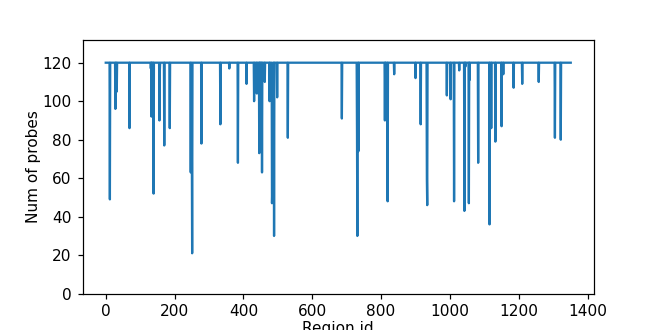

In [163]:
# Plot number of probes per region
plt.figure(figsize=(6,3), dpi=100)
plt.plot(list(reg_size_dic.values()))
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"Num of probes", labelpad=1)
plt.xlabel(f"Region id", labelpad=1)
plt.ylim([0, np.max(list(reg_size_dic.values()))*1.1])
plt.savefig(os.path.join(report_folder, 'afterblast_nProbes_per_region.png'),
            transparent=True, dpi=300)
plt.show()

## number and location on each chr

In [164]:
chrs = []
chr_2_centers = {}
chr_2_types = {}
for _loc_name, _type in zip(region_info_df['locus_info'], region_info_df['type']):
    _chr = _loc_name.split(':')[0]
    _start, _end = _loc_name.split(':')[1].split('-')
    _center = (int(_start)+int(_end))/2
    if _chr not in chrs:
        chrs.append(_chr)
    # create
    if _chr not in chr_2_centers:
        chr_2_centers[_chr] = []
        chr_2_types[_chr] = []
    # append
    if _center not in chr_2_centers[_chr]:
        chr_2_centers[_chr].append(_center)
        chr_2_types[_chr].append(_type)
# region number
chr_2_region_num = {_chr:len(cts) for _chr, cts in chr_2_centers.items()}

In [165]:
# Load chromosome sizes
import pandas as pd
from ImageAnalysis3.structure_tools.distance import sort_chr

sorted_chrs = sorted(chrs, key=lambda _c: sort_chr(_c))

chrom_size_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\hg38.chrom.sizes',
            delimiter='\t', header=None)

chr_2_len = {}
for _chr in chrs:
    chr_2_len[_chr] = chrom_size_df.loc[chrom_size_df[0]==f'chr{_chr}', 1].values[0]


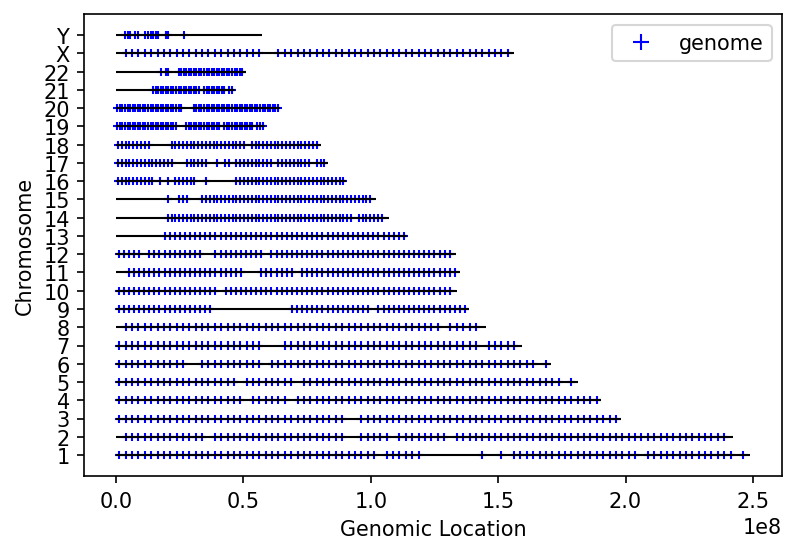

In [166]:
%matplotlib inline
color_map = {
    'genome':'blue',
}
#plt.style.use('dark_background')
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6,4),dpi=150)
for _i, _chr in enumerate(sorted_chrs):
    ax.hlines(_i, 0, chr_2_len[_chr], color='black', linewidth=1)
    ax.scatter(chr_2_centers[_chr], 
               np.ones(len(chr_2_centers[_chr]))* _i, 
               marker='+', linewidth=1,
               s=15, c=[color_map[_t] for _t in chr_2_types[_chr]],
               )
# create legend patch
legend_element = [Line2D([0],[0], color=[0,0,0,0], 
                         label=_type, marker='+', markersize=8,
                         markeredgecolor=_c, markerfacecolor=_c,)
                  for _type,_c in color_map.items()]
ax.legend(handles=legend_element)
ax.set_yticks(np.arange(len(sorted_chrs)))
ax.set_yticklabels(sorted_chrs)
#ax.set_xlim([0, chr_2_len['1']])
ax.set_xlabel("Genomic Location")
ax.set_ylabel("Chromosome")
#ax.legend([_sc])
plt.savefig(os.path.join(report_folder, 'target_location_summary.png'), 
            dpi=300, transparent=True)
plt.show()

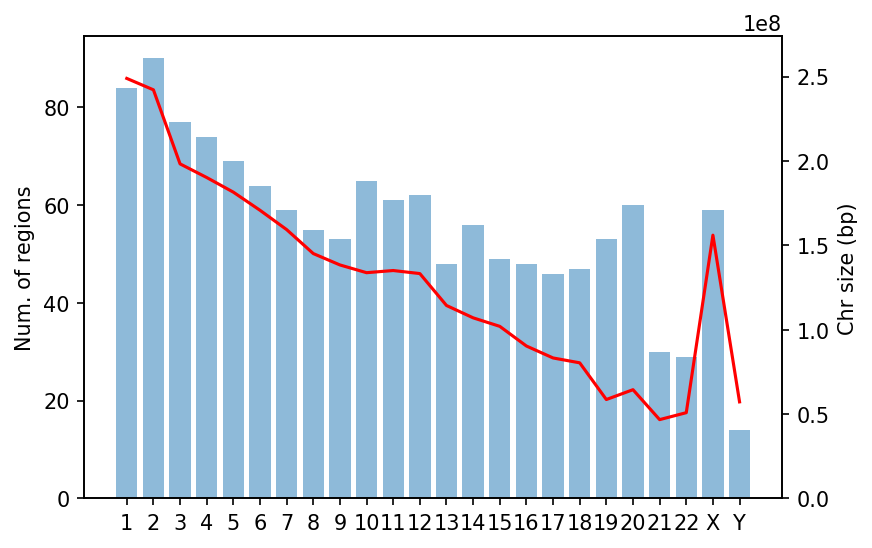

In [167]:
fig, ax1 = plt.subplots(figsize=(6,4),dpi=150)
ax2 = ax1.twinx()
_bar_p = ax1.bar(sorted_chrs, 
                 [chr_2_region_num[_c] for _c in sorted_chrs], alpha=0.5)
ax1.set_ylabel("Num. of regions")
ax2.plot(sorted_chrs, [chr_2_len[_c] for _c in sorted_chrs], color='r')
ax2.set_ylim([0, np.max(list(chr_2_len.values()))*1.1])
ax2.set_ylabel("Chr size (bp)")
plt.savefig(os.path.join(report_folder, 'target_chr_stat_summary.png'), 
            dpi=300, transparent=True)
plt.show()

# Create count table

In [169]:
from ImageAnalysis3 import library_tools
from tqdm import tqdm
overwrite_table = False
# library
library_table_file = os.path.join(reference_folder, 'ctp14-human_genome_library_17w.npy')

if not os.path.exists(library_table_file) or overwrite_table:
    # library
    _library_filenames = [os.path.join(library_folder, 'blast_full_probes.fasta')]
    print(len(_library_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=library_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_library_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=44) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {library_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\ctp14-human_genome_library_17w.npy already exist, skip.
